In [1]:
import numpy as np
import scipy as sc
import math
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy import constants as const
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck15
from astropy.cosmology import WMAP9 as cosmo
from scipy.stats import binned_statistic
import matplotlib.backends.backend_pdf


import pymc3
import  logistic
import run_covering_2
import warnings
warnings.filterwarnings('ignore')

import groups_tools as gid #the important homemade module

%load_ext autoreload
%autoreload 2

# Initial setups

In [2]:
plt.rcParams['text.usetex']=True
plt.rcParams['font.size']=16
plt.rcParams['lines.linewidth']=1.5
plt.rcParams['axes.linewidth']=2.0
plt.rcParams['image.interpolation']='none'
plt.rcParams['xtick.labelsize']='medium'
plt.rcParams['ytick.labelsize']='medium'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.minor.size']=4.0
plt.rcParams['xtick.major.size']=8.0
plt.rcParams['ytick.minor.size']=4.0
plt.rcParams['ytick.major.size']=8.0
plt.rcParams['legend.numpoints']=1
plt.rcParams['image.origin']='lower'
plt.rcParams['font.family']='serif'
plt.rcParams['font.serif']='Computer Modern'

In [3]:
plt.rcParams['xtick.labelsize']='medium'
plt.rcParams['ytick.labelleft']= True
plt.rcParams['ytick.labelsize']='medium'
plt.rcParams['xtick.minor.visible']=False
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.minor.size']=4.0
plt.rcParams['xtick.major.size']=8.0
plt.rcParams['ytick.minor.size']=4
plt.rcParams['ytick.major.size']=8
plt.rcParams['ytick.left']= True
plt.rcParams['ytick.major.left']= True

# Data imports

In [4]:
G = pd.read_csv("G_referee_modif.csv", index_col = False)
R = pd.read_csv("R_referee_modif.csv", index_col = False)

In [5]:
Abs = pd.read_csv("MgII_all_absorption")
fields_info = pd.read_csv("fields_info_ebv.csv")

### Number of galaxies (for the article)

In [6]:
R["QSO_is_behind"] = (R["zqso_sdss_x"] >= R["Z"] + 3e6/const.c.value)
Rok = R[R["QSO_is_behind"]==True]
len(Rok)

1210

In [7]:
Rok.columns

Index(['ID', 'field_id', 'DATASET', 'FROM', 'Z', 'ZCONF', 'is_QSO', 'is_star',
       'DR1_id', 'DR1_nbmatch',
       ...
       'lambda_oii_b', 'lambda_mgii_a', 'lambda_mgii_b', 'REW_2796',
       'sig_REW_2796', 'z_absorption', 'z_absorption_dist',
       'vel_absorption_dist', 'bool_absorption', 'QSO_is_behind'],
      dtype='object', length=142)

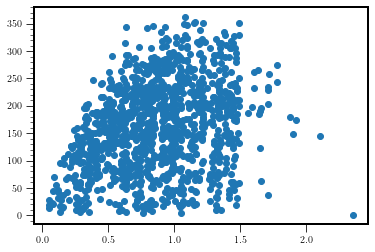

In [8]:
plt.scatter(Rok["Z"], Rok["B_KPC"])
#plt.ylim((5, 15))

In [9]:
np.min(Rok["Z"])

0.051

In [10]:
np.max(Rok["Z"])

2.3569999999999998

# column densities

In [11]:
G["NHI"], G["sigma_NHI"] = gid.Fukugita(G["REW_2796"], G["sig_REW_2796"], G["center_z"])
G["NHI_limit"], _ = gid.Fukugita(G["detection_limit"], 1, G["center_z"])

# Halo Mass from M*

In [12]:
G["Mhalo"] = gid.Behroozi(np.log10(G["Mstar"]), G["center_z"])

# Rvir of the closest galaxy

In [13]:
G["bmin_norm_kpc_2"] = 0
G["Rvir_closest"] = 0

In [14]:
#R["Rvir_subhalo"] = gid.get_Rvir(R["Msubhalo"], R["Z"])

for i, g in G.iterrows():
    r = R[R["group_id"] == g["group_id"]]
    bmin = r["B_KPC"].min()
    rmin = r[r["B_KPC"] == bmin]
    
    rvir_min = gid.get_Rvir(rmin["Msubhalo"], rmin["Z"])
    rvir_min = rvir_min.values[0]
    bmin = g["b_min_kpc"]
    #print(rvir_min)
    G.loc[i, "b_min_kpc_norm_2"] = bmin/rvir_min
    G.loc[i, "Rvir_closest"] = rvir_min

# Vlos min max & spread

In [15]:
for i, g in G.iterrows():
    grpid = g["group_id"]
    rr = R[R["group_id"] == grpid]
    rr = rr[rr["outlier"] == False]
    vmin = rr["vlos_to_gcenter"].min()
    vmax = rr["vlos_to_gcenter"].max()
    zmin = rr["Z"].min()
    zmax = rr["Z"].max()
    vspread = vmax-vmin
    G.loc[i, "vlos_min"] = vmin
    G.loc[i, "vlos_max"] = vmax
    G.loc[i, "z_min"] = zmin
    G.loc[i, "z_max"] = zmax
    G.loc[i, "vlos_spread"] = vspread

# Virial velocity

In [16]:
K = (1*u.kpc).to(u.m)
K.value

3.085677581491367e+19

In [17]:
G["Vvir_sigma2"] = (const.G.value*G["Mvir_sigma2"]*const.M_sun.value/G["Rvir_sigma2"]/K.value)**0.5
G["Vvir_sigma3"] = (const.G.value*G["Mvir_sigma3"]*const.M_sun.value/G["Rvir_sigma3"]/K.value)**0.5
G["Vvir_sigma2"] = G["Vvir_sigma2"]/1000 #back in km/s
G["Vvir_sigma3"] = G["Vvir_sigma3"]/1000 #back in km/s

# Groups selection

In [18]:
G["bool_abs_01"] = (G["REW_2796"] > 0.1)*1
G["bool_abs_03"] = (G["REW_2796"] > 0.3)*1
G["bool_abs_1"] = (G["REW_2796"] > 1)*1

In [19]:
len(G)
len(G[G["N_gal"]>=3])

123

In [20]:
#G = G.rename(columns = {"Rvir":"Rvir_vel_disp"})

Text(0.5, 0, 'M1/M2 ratio')

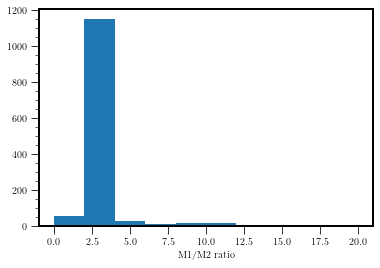

In [21]:
plt.hist(G["m1_m2_ratio"], range = (0,20));
plt.xlabel("M1/M2 ratio")

In [22]:
#f1 = G["N100"] <= 1
#f3 = G["N100_los"] <= 2
#f4 = G["N100_los"] <= 1
f5 = G["N_gal"] == 1
f6 = G["N_gal"]  > 1
f7 = G["N100_los"] > 1
f8 = G["bool_absorption"] == 1
f9 = G["N_gal"] >= 5
f99 = G["N_gal"] >= 3
f10 = G["bool_absorption"] == 0
f11 = G["N_gal"] >= 2
f12 = G["MgII_2796_lim"] == np.inf
f13 = G["MgII_2796_lim"] != np.inf
f14 = G["QSO_is_behind"] == True
#f24 = G["ID"].isin(good_grp)

f15 = R["B_KPC"] <= 100
f16 = R["N100_los"] <= 2
f17 = R["N100_los"] <= 1
f18 = R["N50_neighb"] == 0
f19 = R["Z"] >= 4700/2796 - 1
f20 = R["Z"] <= 9300/2796 - 1
f21 = R["bool_absorption"] == 0
f22 = R["bool_absorption"] == 1
f23 = R["B_KPC"]>= 5 # remove the QSOs
#fweirds = G["Rvir_recomputed"] >= 10

In [23]:
G_abs = G[f8 & f14 & f13]
G_noabs = G[f10 & f14 & f13]
G2 = G[f7 & f13 & f14]
G2_abs = G[f8 & f7 & f14 & f13]
G2_noabs = G[f10 & f7 & f14 & f13]
G5_raw = G[f9]
G5 = G[f9 & f13 & f14]
#G5 = gid.create_id(G5, "N_gal")
G5_abs = G5[G5["bool_absorption"] == 1]
G5_noabs = G5[G5["bool_absorption"] == 0]
G3 = G[f99 & f13 & f14]
G3_abs = G3[G3["bool_absorption"] == 1]
G3_noabs = G3[G3["bool_absorption"] == 0]

R_ilane_abs = R[f22 & f15 & f17 & f18 & f23]
R_ilane_noabs = R[f21 & f15 & f17 & f18  & f23]
R_ilane2_abs = R[f22 & f17 & f18  & f23]
R_ilane2_noabs = R[f21 & f17 & f18  & f23]

The number of groups of more than 5 galaxies is originally:

In [24]:
len(G5_raw)

32

# statistics on absorbers & galaxies

In [25]:
len(R)

2020

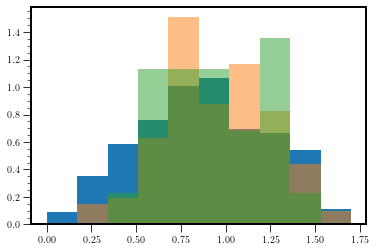

In [26]:
plt.hist(R["Z"], range = (0,1.7), density = True);
plt.hist(Abs["z_abs"], range = (0,1.7), density = True, alpha = 0.5);
plt.hist(G5["center_z"], range = (0,1.7), density = True, alpha = 0.5);

In [27]:
Abs.columns

Index(['field_name', 'z_abs', 'REW_2796', 'sig_REW_2796'], dtype='object')

But we have to remove the groups that are behind the QSO:

Finally the number of groups of more than 5 galaxies is:

In [28]:
print("nb of groups of more than 5 gal: ", len(G5))
print("nb of groups of more than 3 gal: ", len(G3))

nb of groups of more than 5 gal:  26
nb of groups of more than 3 gal:  90


### exports the groups

In [29]:
#gid.plot_groups(R, G3, Nmin = 1, save = True,  filename = "FoF_G3_groups_caust.pdf")

# Mass of the groups

In [30]:
len(G5)

26

In [31]:
print(np.min(np.log10(G5["Mvir_sigma2"])))
print(np.max(np.log10(G5["Mvir_sigma2"])))
print(np.median(np.log10(G5["Mvir_sigma2"])))

10.726187183000865
13.719026815640284
12.346054727074716


In [32]:
print(np.min(G5["center_z"]))
print(np.max(G5["center_z"]))
print(np.median(G5["center_z"]))

0.46399999999999997
1.4322860299315043
0.95621


In [33]:
len(G[(G["N_gal"]>=5) & (G["QSO_is_behind"]==True) & (G["MgII_2796_lim"] != np.inf)])

26

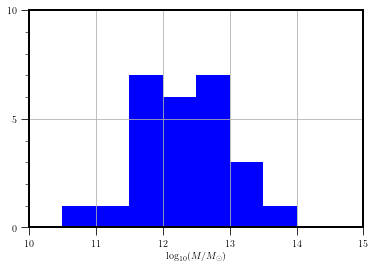

In [34]:
#plt.figure(figsize = (6,4))
plt.hist(np.log10(G5["Mvir_sigma2"]), bins = 10, range=(10, 15), color = "blue");
plt.xlabel("$\log_{10}(M/M_{\odot}$)")
plt.yticks([0,5,10]);
plt.xlim((10,15))
plt.grid()

# Phase space

In [35]:
r = np.linspace(0, 800,100)[1:]*u.kpc #0 has a singularity
z = 1
Mvir = 1e12
Rvir = gid.get_Rvir(1e12, z)
vesc = gid.NFW_escape_vel_from_Mvir(r, Mvir*u.solMass, z = z)
Vvir = (const.G*Mvir*const.M_sun/(Rvir*u.kpc))**0.5 #in km/s
Vvir = Vvir.to(u.km/u.s)
Vvir = Vvir.value
print(Rvir, Vvir)

156.28710893311342 165.88952578162505


(0.0, 2.5)

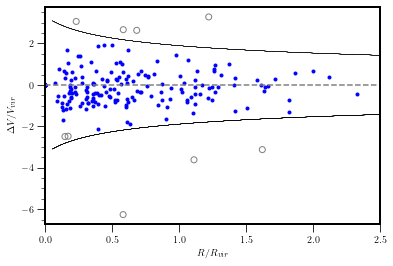

In [36]:
#plt.figure(figsize = (6,5))
plt.axhline(color = "gray", linestyle = '--')
for i, g in G5.iterrows():
    grpid = g.group_id
    galaxies = R[R["group_id"] == grpid]
    galaxies_clean = galaxies[galaxies["outlier"] == False]
    galaxies_out = galaxies[galaxies["outlier"] == True]
    #plt.scatter(galaxies["r_to_gcenter"], galaxies["vlos_to_gcenter"], c = "lightgray")
    plt.scatter(galaxies_clean["r_to_gcenter"]/g["Rvir_sigma2"], galaxies_clean["vlos_to_gcenter"]/g["Vvir_sigma2"], \
                c = 'blue', marker = ".")
    plt.scatter(galaxies_out["r_to_gcenter"]/g["Rvir_sigma2"], galaxies_out["vlos_to_gcenter"]/g["Vvir_sigma2"], \
                marker = "o", facecolors = "none", edgecolors = "gray")
    plt.plot(r/Rvir, vesc/Vvir, c = "black", linestyle = "--", linewidth = 0.1)
    plt.plot(r/Rvir, -vesc/Vvir, c = "black", linewidth = 0.1)
plt.xlabel("$R/R_{vir}$")
plt.ylabel("$\Delta V/V_{vir}$")
plt.xlim((0,2.5))
#plt.ylim((-1550,1550))
#plt.yticks(np.arange(-3, 4)*500);

Text(0, 0.5, '$\\Delta v$ $(km/s)$')

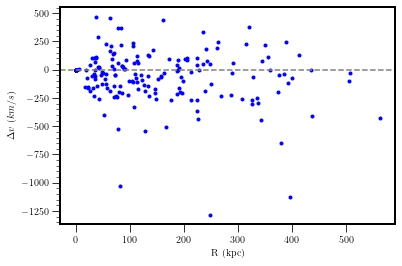

In [37]:
#plt.figure(figsize = (6,5))
plt.axhline(color = "gray", linestyle = '--')
for i, g in G5.iterrows():
    grpid = g.group_id
    galaxies = R[R["group_id"] == grpid]
    galaxies_clean = galaxies[galaxies["outlier"] == False]
    #plt.scatter(galaxies["r_to_gcenter"], galaxies["vlos_to_gcenter"], c = "lightgray")
    plt.scatter(galaxies_clean["r_to_gcenter"], galaxies_clean["vlos_to_gcenter"], c = 'blue', marker = ".")
plt.xlabel("R (kpc)")
plt.ylabel("$\Delta v$ $(km/s)$")
#plt.xlim((0, 2))
#plt.ylim((-1500,1500))

(2.0, 22.0)

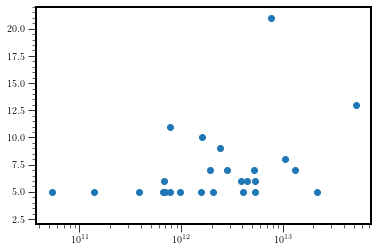

In [38]:
plt.scatter(G5["Mvir_sigma2"], G5["N_gal"])
plt.xscale("log")
plt.ylim((2, 22))

Ggood = G3[G3["ID"].isin(good_grp)]
Ggood_noabs = G_noabs[G_noabs["ID"].isin(good_grp)]
Ggood_abs = G_abs[G_abs["ID"].isin(good_grp)]
Ggood_noabs = G_noabs[G_noabs["ID"].isin(good_grp)]
len(Ggood_abs)+len(Ggood_noabs)
len(Ggood)

we have less good groups because some of them are behind QSO or in no UVES coverage zone

# Absorptions

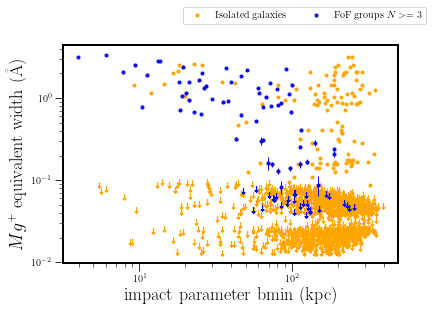

In [39]:
plt.rcParams['lines.linewidth']=1.0
plt.scatter(R_ilane2_abs["B_KPC"], R_ilane2_abs["REW_2796"], c = "orange", marker = ".", label = "Isolated galaxies", alpha = 1)
plt.scatter(R_ilane2_noabs["B_KPC"], R_ilane2_noabs["detection_limit"], marker = "$\downarrow$", c = "orange", alpha = 1)

plt.errorbar(G3_abs["b_min_kpc"], G3_abs["REW_2796"], yerr = G3_abs["sig_REW_2796"], fmt = 'none',c = "blue")
plt.scatter(G3_abs["b_min_kpc"], G3_abs["REW_2796"], marker = ".", label = "FoF groups $N >= 3$", c = "blue")
plt.scatter(G3_noabs["b_min_kpc"], G3_noabs["detection_limit"], marker = "$\downarrow$", c = "blue")
#plt.errorbar(G5_abs["b_min_kpc"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none',c = "blue")
#plt.scatter(G5_abs["b_min_kpc"], G5_abs["REW_2796"], marker = ".", label = "groups N >= 5", c = "blue")
#plt.scatter(G5_noabs["b_min_kpc"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "blue")
#plt.scatter(G_good_fof_abs["b_min_kpc"], G_good_fof_abs["REW_2796"], marker = "o", label = "Score $> 0.75$", c = "red")
#plt.scatter(G_good_fof_noabs["b_min_kpc"], G_good_fof_noabs["detection_limit"], marker = "v", c = "red")

plt.xlabel("impact parameter bmin (kpc)", size = 18)
plt.ylabel("$Mg^+$ equivalent width (\AA)", size = 18)
#plt.grid()
plt.legend(bbox_to_anchor=(1.1,1.2), ncol = 2)
plt.xscale("log")

plt.yscale("log")

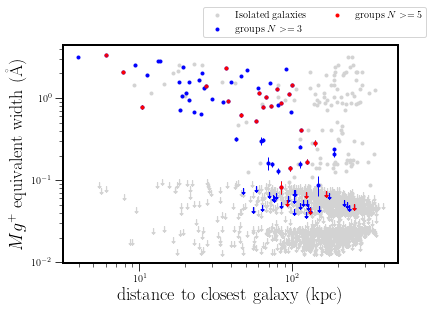

In [40]:
plt.rcParams['lines.linewidth']=1.0
plt.scatter(R_ilane2_abs["B_KPC"], R_ilane2_abs["REW_2796"], c = "lightgray", marker = ".", label = "Isolated galaxies", alpha = 1)
plt.scatter(R_ilane2_noabs["B_KPC"], R_ilane2_noabs["detection_limit"], marker = "$\downarrow$", c = "lightgray", alpha = 1)

plt.errorbar(G3_abs["b_min_kpc"], G3_abs["REW_2796"], yerr = G3_abs["sig_REW_2796"], fmt = 'none',c = "blue")
plt.scatter(G3_abs["b_min_kpc"], G3_abs["REW_2796"], marker = ".", label = "groups $N >= 3$", c = "blue")
plt.scatter(G3_noabs["b_min_kpc"], G3_noabs["detection_limit"], marker = "$\downarrow$", c = "blue")
plt.errorbar(G5_abs["b_min_kpc"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none',c = "red")
plt.scatter(G5_abs["b_min_kpc"], G5_abs["REW_2796"], marker = ".", label = "groups $N >= 5$", c = "red")
plt.scatter(G5_noabs["b_min_kpc"], G5_noabs["detection_limit"], marker = "$\downarrow$", c = "red")
#plt.scatter(G_good_fof_abs["b_min_kpc"], G_good_fof_abs["REW_2796"], marker = "o", label = "Score $> 0.75$", c = "red")
#plt.scatter(G_good_fof_noabs["b_min_kpc"], G_good_fof_noabs["detection_limit"], marker = "v", c = "red")

plt.xlabel("distance to closest galaxy (kpc)", size = 18)
plt.ylabel("$Mg^+$ equivalent width (\AA)", size = 18)
#plt.grid()
plt.legend(bbox_to_anchor=(1.1,1.2), ncol = 2)
plt.xscale("log")

plt.yscale("log")

we can try to look at the interloper at the bottom left:

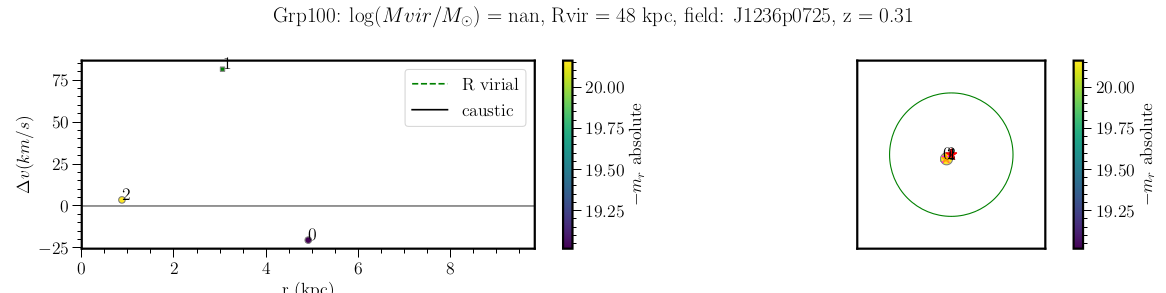

We have 3 galaxies very close. Is it a doublon? Or bad PSF substraction?

After investigation it is not a group. We have a bad match feline - white and sources to be splitted. In fact there is only 2 object at this redshift.

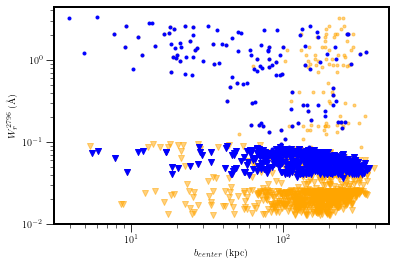

In [41]:
plt.scatter(R_ilane2_abs["B_KPC"], R_ilane2_abs["REW_2796"], c = "orange", marker = ".", label = "Isolated galaxies", alpha = 0.5)
plt.scatter(R_ilane2_noabs["B_KPC"], R_ilane2_noabs["detection_limit"], marker = "v", c = "orange", alpha = 0.5)


#plt.errorbar(G3_abs["b_center_kpc"], G3_abs["REW_2796"], yerr = G3_abs["sig_REW_2796"], fmt = 'none',c = "blue")
plt.scatter(G_abs["b_min_kpc"], G_abs["REW_2796"], marker = ".", label = "groups N >= 5", c = "blue")
plt.scatter(G_noabs["b_min_kpc"], G_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "blue")

#plt.scatter(Ggood_abs["b_center_kpc"], Ggood_abs["REW_2796"], marker = "o", label = "groups N >= 5", c = "red")
#plt.scatter(Ggood_noabs["b_center_kpc"], Ggood_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "red")
plt.xlabel("$b_{center}$ (kpc)")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")

In [42]:
len(G5_abs[G5_abs["REW_2796"]>=1])

9

# Normalized by Rvir

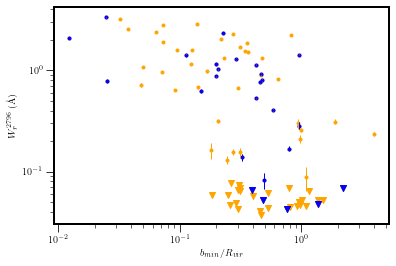

In [43]:
plt.errorbar(G3_abs["b_min_kpc_norm2"], G3_abs["REW_2796"], yerr = G3_abs["sig_REW_2796"], fmt = 'none',c = "orange")
plt.scatter(G3_abs["b_min_kpc_norm2"], G3_abs["REW_2796"], marker = ".", label = "groups N >= 5", c = "orange")
plt.scatter(G3_noabs["b_min_kpc_norm2"], G3_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "orange")

plt.errorbar(G5_abs["b_min_kpc_norm2"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none',c = "blue")
plt.scatter(G5_abs["b_min_kpc_norm2"], G5_abs["REW_2796"], marker = ".", label = "groups N >= 5", c = "blue")
plt.scatter(G5_noabs["b_min_kpc_norm2"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "blue")
#plt.scatter(G_good_fof_abs["b_min_kpc_norm"], G_good_fof_abs["REW_2796"], marker = "o", label = "groups N >= 5", c = "red")
#plt.scatter(G_good_fof_noabs["b_min_kpc_norm"], G_good_fof_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "red")

#plt.scatter(Ggood_abs["b_min_kpc_norm"], Ggood_abs["REW_2796"], marker = "o", label = "groups N >= 5", c = "red")
#plt.scatter(Ggood_noabs["b_min_kpc_norm"], Ggood_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "red")

plt.xlabel("$b_{min}/R_{vir}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")

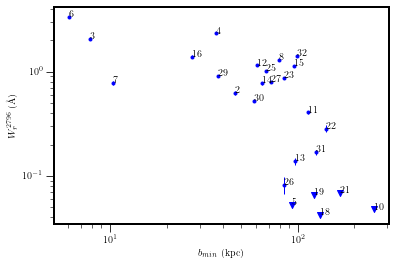

In [44]:

#plt.title("FoF groups ($N >= 5$)")
plt.errorbar(G5_abs["b_min_kpc"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none',c = "blue")
plt.scatter(G5_abs["b_min_kpc"], G5_abs["REW_2796"], marker = ".", label = "groups N >= 5", c = "blue")
plt.scatter(G5_noabs["b_min_kpc"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "blue")

#plt.errorbar(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none',c = "blue")
#plt.scatter(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], marker = ".", label = "groups N >= 5", c = "blue")
#plt.scatter(G5_noabs["b_center_kpc_norm"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "blue")

#plt.scatter(G_good_fof_abs["b_center_kpc_norm"], G_good_fof_abs["REW_2796"], marker = "o", label = "groups N >= 5", c = "red")
#plt.scatter(G_good_fof_noabs["b_center_kpc_norm"], G_good_fof_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "red")


#plt.scatter(Ggood_abs["b_center_kpc_norm"], Ggood_abs["REW_2796"], marker = "o", label = "groups N >= 5", c = "red")
#plt.scatter(Ggood_noabs["b_center_kpc_norm"], Ggood_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "red")

X = np.array(G5_abs["b_min_kpc"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_min_kpc"])
Y = np.array(G5_noabs["detection_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{min}$ (kpc)")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")

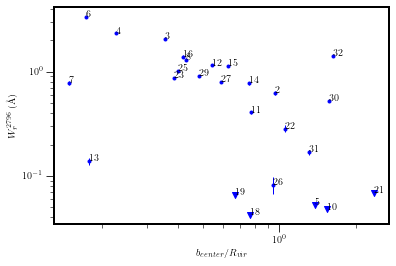

In [45]:

#plt.title("FoF groups ($N >= 5$)")
plt.errorbar(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none',c = "blue")
plt.scatter(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], marker = ".", label = "groups N >= 5", c = "blue")
plt.scatter(G5_noabs["b_center_kpc_norm2"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "blue")

#plt.errorbar(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none',c = "blue")
#plt.scatter(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], marker = ".", label = "groups N >= 5", c = "blue")
#plt.scatter(G5_noabs["b_center_kpc_norm"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "blue")

#plt.scatter(G_good_fof_abs["b_center_kpc_norm"], G_good_fof_abs["REW_2796"], marker = "o", label = "groups N >= 5", c = "red")
#plt.scatter(G_good_fof_noabs["b_center_kpc_norm"], G_good_fof_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "red")


#plt.scatter(Ggood_abs["b_center_kpc_norm"], Ggood_abs["REW_2796"], marker = "o", label = "groups N >= 5", c = "red")
#plt.scatter(Ggood_noabs["b_center_kpc_norm"], Ggood_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "red")

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_center_kpc_norm2"])
Y = np.array(G5_noabs["detection_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")

Text(0, 0.5, '$W_r^{2796}$ (\\AA)')

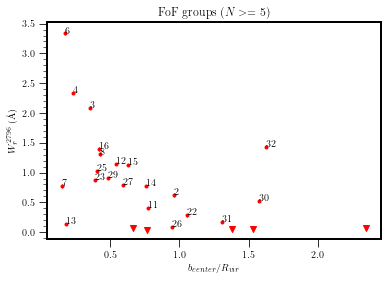

In [46]:

plt.title("FoF groups ($N >= 5$)")
plt.errorbar(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none',c = "red")
plt.scatter(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], marker = ".", label = "groups N >= 5", c = "red")
plt.scatter(G5_noabs["b_center_kpc_norm2"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "red")

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
#plt.xscale("log")
#plt.yscale("log")

In [47]:
g8 = G[G["ID"] == 9]
g8

index    field_id  group_id  N_gal    mean_z   mean_ra  mean_dec  \
8      8  J0015m0751      1178      7  0.872727  3.898029 -7.853334   

   b_min_kpc   Mvir_sigma2   Mvir_sigma3  ...    vlos_min   vlos_max    z_min  \
8       1.11  1.091049e+12  3.650289e+11  ... -155.253267  84.829105  0.87209   

     z_max  vlos_spread  Vvir_sigma2  Vvir_sigma3  bool_abs_01  bool_abs_03  \
8  0.87359   240.082372   165.962028   115.213426            0            0   

   bool_abs_1  
8           0  

[1 rows x 93 columns]

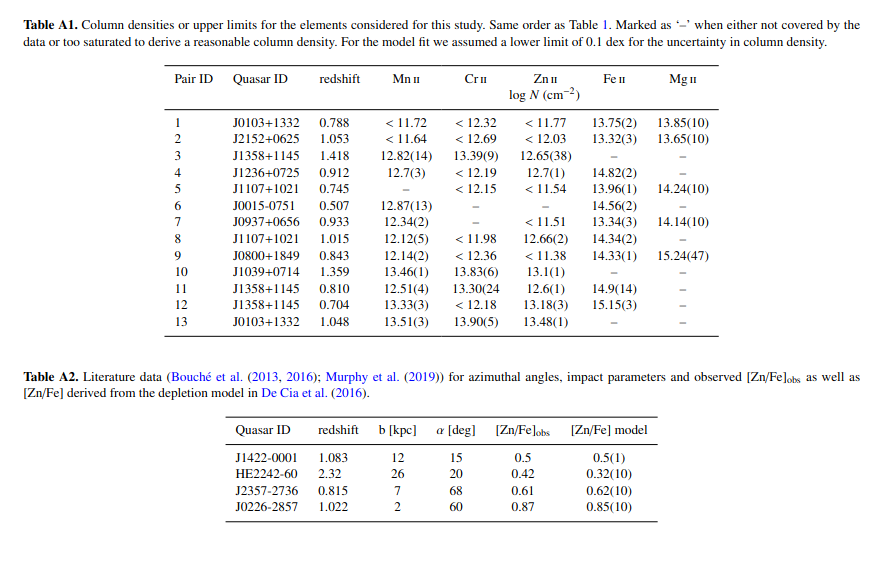

## Kinematics of the groups

In [48]:
def plot_groups_modif(R, G, Nmin = 5, save = False,  filename = "none"):
	if save == True:
		if filename == "none":
			from datetime import datetime
			d = datetime.now()
			name = str(d.year)+str(d.month)+str(d.day)+"_groups.pdf"
		else:
			name = filename
		pdf = matplotlib.backends.backend_pdf.PdfPages(name)

	G_filt = G[G["N_gal"]>= Nmin]

	for i, g in G_filt.iterrows():
		#try:
		df = R[R["group"] == g["group_id"]]	
		z_mean = g["mean_z"]
		ra_mean = g["mean_ra"]*u.degree
		dec_mean = g["mean_dec"]*u.degree

		if ~np.isnan(g["center_z"]):
			z_center = g["center_z"]
			ra_center =  g["center_ra"]*u.degree
			dec_center = g["center_dec"]*u.degree
		else: 
			z_center = g["mean_z"]
			ra_center =  g["mean_ra"]*u.degree
			dec_center = g["mean_dec"]*u.degree

		ra_qso = (df["ra_qso"].mean())*u.degree
		dec_qso = (df["dec_qso"].mean())*u.degree
		rho0, Rs = gid.get_nfw_param(g["Mvir"], z_mean)
		r = np.linspace(1,3000, num = 10000 )
		M = gid.nfw_cumsum(r, rho0, Rs)
		V = gid.get_esc_v(M, r)

		C = const.c.to('km/s').value
		deg_to_rad = 1*u.degree.to(u.radian)
		
		ra2 = df["RA"]*u.degree
		dec2 = df["DEC"]*u.degree
		c1 = SkyCoord(ra_center, dec_center)
		c2 = SkyCoord(ra2, dec2)
		sep = c1.separation(c2)
		df["r_to_gcenter"] = sep.radian*Distance(unit=u.kpc, z = z_center).value/((1+z_center)**2)
		df["vlos_to_gcenter"] = (df["Z"]-z_center)*C
		
		Rvir = g["Rvir_recomputed"]

		ra = df["RA"]
		dec = df["DEC"]
		vlos = df["vlos_to_gcenter"]
		rcenter = df["r_to_gcenter"]

		df_filt = df[df["outlier"] == False]
		df_out = df[df["outlier"] == True]


		ra = np.array(ra)
		dec = np.array(dec)
		vlos = np.array(vlos)
		rcenter = np.array(rcenter)
		
		fig = plt.figure(figsize = (15,4))
		title = "Grp"+str(g["ID"])\
				+":   log($Mvir/M_{\odot}$) = "\
				+str(round(np.log10(g["Mvir"]),1))\
				+",     Rvir = "+str(round(g["Rvir_recomputed"]))\
				+" kpc" \
				+", field: "+str(g["field_id"])\
				+", z = " +str(np.round(g["center_z"], 2))
		plt.suptitle(title, fontweight = "bold")
		plt.subplot(121)
		plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
					c = "green", edgecolor = 'grey', marker = "s", s = 15)
		if "Psat" in df.columns:
			plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
					c = df["Psat"], edgecolor = 'grey', vmin = 0, vmax = 1, s = df['mass10']/1e8 + 80)
			cbar = plt.colorbar(label =	 "Psat")
		else:
			plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
					c = -df["m_abs_r"], edgecolor = 'grey', s = df['mass10']/1e8 + 80)
			cbar = plt.colorbar(label =	 "$- m_r$ absolute")
		plt.scatter(df_out["r_to_gcenter"], df_out["vlos_to_gcenter"], s = df_out['mass10']/1e8 + 80, facecolors='none', edgecolors='r')
		plt.axvline(Rvir, ls = "--", c = "green", label = "R virial")
		plt.plot(r, V, c = "black", label = "caustic")
		plt.plot(r, -V, c = "black")
		try:
			plt.xlim((0,(np.max(df["r_to_gcenter"]))*2))
		except: 
			print("no center!")
		#plt.ylim((-1500,1500))
		plt.xlabel("r (kpc)")
		plt.ylabel("$\Delta v (km/s)$")
		plt.axhline(c = "grey")
		plt.legend()
		for i in range(len(df)):
			plt.annotate(str(i), (rcenter[i], vlos[i]))

		kpc_per_arcmin = cosmo.kpc_proper_per_arcmin(z_mean)
		arcmin = 1/60
		plt.subplot(122)
		r100 = 100/kpc_per_arcmin.value/60
		plt.scatter(ra_qso.value, dec_qso.value, marker = "*", s = 100, c = "red")
		rectangle = plt.Rectangle((ra_qso.value - arcmin/2,dec_qso.value - arcmin/2), arcmin, arcmin, fc=None ,ec=None, lw = 0, fill = False)
		plt.gca().add_patch(rectangle)
		circle = plt.Circle((ra_qso.value,dec_qso.value),r100, fill = False,ec="green")
		plt.gca().add_patch(circle)
		plt.scatter(df["RA"],df["DEC"], \
					c = "green", edgecolor = 'grey', marker = "s", s = 15)
		plt.scatter(df["RA"],df["DEC"], \
			c = df["vlos_to_gcenter"], edgecolor = 'grey', s = 100, cmap = "seismic", vmin = -1000, vmax = 1000)
		plt.colorbar(label = "$- m_r$ absolute")
		plt.xticks([])
		plt.yticks([])
		plt.scatter(df_out["RA"], df_out["DEC"], s=150, facecolors='none', edgecolors='r')
		plt.scatter(ra_qso.value, dec_qso.value, marker = "*", s = 100, c = "red")
		plt.scatter(ra_mean.value, dec_mean.value, marker = "x", s = 40, c = "magenta")
		plt.scatter(ra_center.value, dec_center.value, marker = "*", s = 60, c = "orange")
		plt.gca().set_aspect('equal', adjustable='box')
		for i in range(len(df)):
			plt.annotate(str(i), (ra[i], dec[i]))
		fig.tight_layout()

		if save == True:
			pdf.savefig(fig)

		#except Exception as e:  
		#	print(e)

	if save == True:
		pdf.close()

	return


In [49]:
#plot_groups_modif(R, G5, Nmin = 3, save = False)

# Correlation with halo masses

Text(0.5, 0, '$M/M_{\\odot}$')

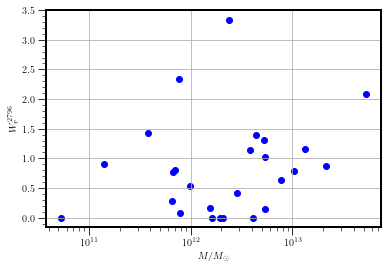

In [50]:
#plt.scatter(G3["Mvir_vel_disp"], G3["REW_2796"], marker = "o", c = "orange")
plt.scatter(G5["Mvir_sigma2"], G5["REW_2796"], marker = "o", c = "blue")
plt.xscale('log')
plt.grid()
plt.ylabel("$W^{2796}_r$")
plt.xlabel("$M/M_{\odot}$")

Text(0, 0.5, '$log(M/M_{\\odot})$')

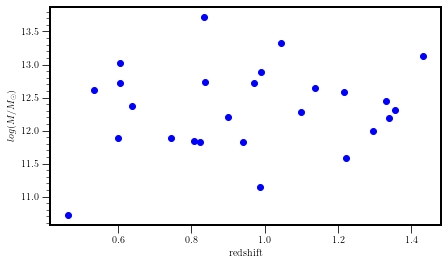

In [51]:
plt.figure(figsize = (7,4))
#plt.errorbar(G5_abs["b_min_kpc"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none',c = "blue")
#plt.scatter(G5_abs["b_min_kpc"], G5_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
#           c = np.log10(G5_abs["Mvir_vel_disp"]), vmin = 11, vmax = 14)
#plt.colorbar(label = "log($M/M_{\odot}$)")
#plt.scatter(G5_noabs["b_min_kpc"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5", \
#           c = np.log10(G5_noabs["Mvir_vel_disp"]), vmin = 11, vmax = 14)

#plt.scatter(R["Z"], R["mass"])
#plt.scatter(G3["center_z"], np.log10(G3["Mvir_vel_disp"]), marker = ".")
plt.scatter(G5["center_z"], np.log10(G5["Mvir_sigma2"]), color = "blue")

#X = np.array(G5_abs["b_min_kpc"])
#Y = np.array(G5_abs["REW_2796"])
#txt = np.array(G5_abs["ID"])

#for i in range(len(G5_abs)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
#X = np.array(G5_noabs["b_min_kpc"])
#Y = np.array(G5_noabs["detection_limit"])
#txt = np.array(G5_noabs["ID"])

#for i in range(len(G5_noabs)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))

#plt.ylim((5, 15))


plt.xlabel("redshift")
plt.ylabel("$log(M/M_{\odot})$")
#plt.grid()
#plt.xscale("log")
#plt.yscale("log")

Text(0, 0.5, '$log(M*/M_{\\odot})$')

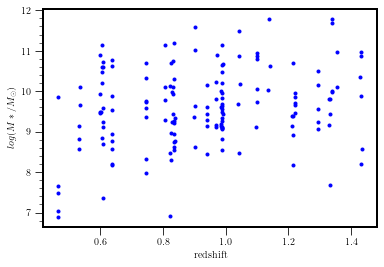

In [52]:
#plt.figure(figsize = (6,5))
#plt.axhline(color = "gray", linestyle = '--')
for i, g in G5.iterrows():
    grpid = g.group_id
    galaxies = R[R["group_id"] == grpid]
    galaxies_clean = galaxies[galaxies["outlier"] == False]
    #plt.scatter(galaxies["r_to_gcenter"], galaxies["vlos_to_gcenter"], c = "lightgray")
    plt.scatter(galaxies_clean["Z"], galaxies_clean["mass"], c = 'blue', marker = ".")
plt.xlabel("redshift")
plt.ylabel("$log(M*/M_{\odot})$")
#plt.xlim((0, 2))
#plt.ylim((-1500,1500))

Text(0, 0.5, '$SDSS r$')

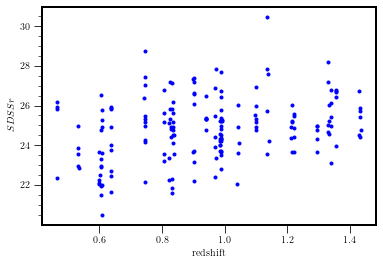

In [53]:
#plt.figure(figsize = (6,5))
#plt.axhline(color = "gray", linestyle = '--')
for i, g in G5.iterrows():
    grpid = g.group_id
    galaxies = R[R["group_id"] == grpid]
    galaxies_clean = galaxies[galaxies["outlier"] == False]
    #plt.scatter(galaxies["r_to_gcenter"], galaxies["vlos_to_gcenter"], c = "lightgray")
    plt.scatter(galaxies_clean["Z"], galaxies_clean["SDSS_r"], c = 'blue', marker = ".")
plt.xlabel("redshift")
plt.ylabel("$SDSS r$")
#plt.xlim((0, 2))
#plt.ylim((-1500,1500))

Text(0, 0.5, '$SDSS r$')

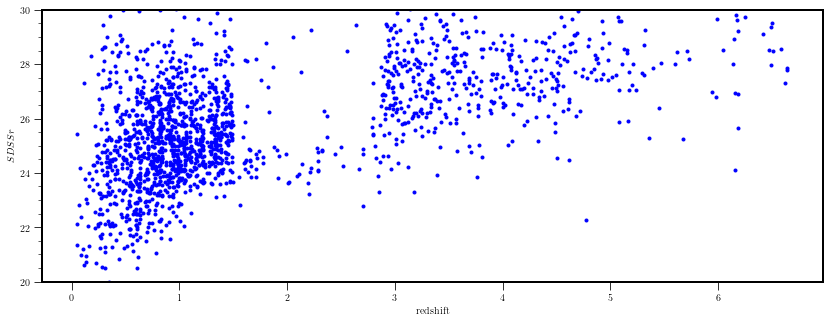

In [54]:
plt.figure(figsize=(14,5))
plt.scatter(R["Z"], R["SDSS_r"], c = 'blue', marker = ".")
plt.ylim((20, 30))
plt.xlabel("redshift")
plt.ylabel("$SDSS r$")

Text(0, 0.5, '$mass$')

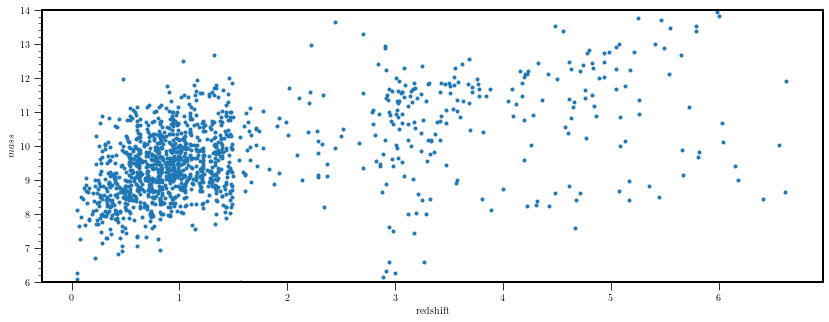

In [55]:
plt.figure(figsize=(14,5))
plt.scatter(R["Z"], R["mass"], marker = ".")
plt.ylim((6, 14))
plt.xlabel("redshift")
plt.ylabel("$mass$")

In [56]:
d10 = 10*u.pc
d10 = d10.to(u.m)
R["m_abs_r"] = R["SDSS_r"] + 2.5*np.log10((R["dist_lum"]/d10.value)**2) 

Text(0, 0.5, '$SDSS r$')

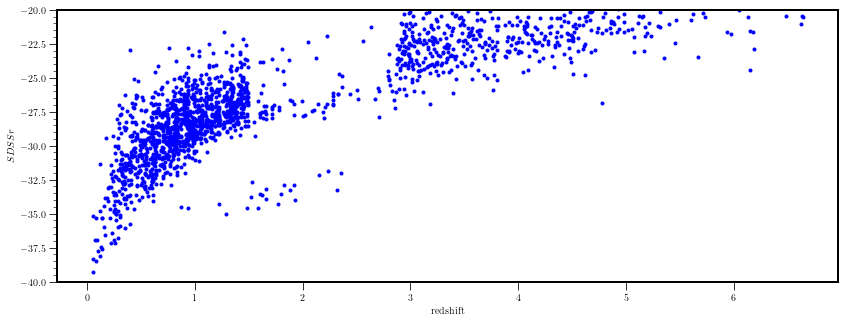

In [57]:
plt.figure(figsize=(14,5))
plt.scatter(R["Z"], R["m_abs_r"], c = 'blue', marker = ".")
plt.ylim((-40, -20))
plt.xlabel("redshift")
plt.ylabel("$SDSS r$")

In [58]:
Z = np.linspace(0.1, 6, 30)
Mlim_rel =  27 # at z = 1
mlim_abs = Mlim_rel + 2.5*np.log10((Distance(unit=u.m, z = Z).value/d10.value/((1+Z)**2))**2)
mlim_abs

array([64.97329696, 66.90166009, 67.58140683, 67.91768355, 68.0998223 ,
       68.19877127, 68.24817558, 68.26623151, 68.26364374, 68.24708954,
       68.22091783, 68.18805666, 68.15052968, 68.10976521, 68.06678865,
       68.02234629, 67.97698726, 67.93111904, 67.88504586, 67.83899569,
       67.79313965, 67.74760594, 67.70249024, 67.65786332, 67.61377677,
       67.5702674 , 67.5273605 , 67.48507246, 67.44341267, 67.40238513])

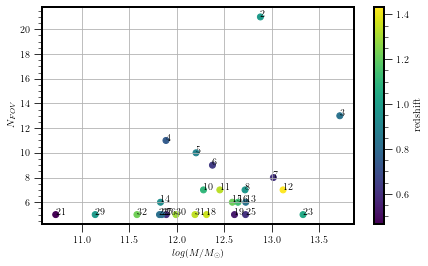

In [59]:
plt.figure(figsize = (7,4))
plt.scatter(np.log10(G5["Mvir_sigma2"]), G5["N_gal"], c = G5["center_z"])
plt.colorbar(label = "redshift")


X = np.array(np.log10(G5["Mvir_sigma2"]))
Y = np.array(G5["N_gal"],)
txt = np.array(G5["ID"])

for i in range(len(G5)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    

plt.xlabel("$log(M/M_{\odot})$")
plt.ylabel("$N_{FOV}$")
plt.grid()

In [60]:
G5.columns

Index(['index', 'field_id', 'group_id', 'N_gal', 'mean_z', 'mean_ra',
       'mean_dec', 'b_min_kpc', 'Mvir_sigma2', 'Mvir_sigma3', 'Rvir_sigma2',
       'Rvir_sigma3', 'Mstar', 'm1_m2_ratio', 'center_ra', 'center_dec',
       'center_z', 'center_ra_err', 'center_dec_err', 'center_z_err',
       'Mvir_sigma2_error', 'Rvir_sigma2_error', 'Mvir_sigma3_error',
       'Rvir_sigma3_error', 'Rmax', 'sigma_v', 'sigma_v_error', 'ID',
       'EXPTIME(s)', 'PSF_qso', 'Comments_qso', 'zqso_sdss', 'depth_qso',
       'ebv_sfd_qso', 'ebv_sandf_qso', 'ebv_planck_qso', 'HST_qso', 'rmag_qso',
       'ra_qso', 'dec_qso', 'N100', 'N200', 'N100_los', 'dist', 'b_center_kpc',
       'b_geomcenter_kpc', 'b_center_err', 'b_min_kpc_norm2',
       'b_center_kpc_norm2', 'b_geomcenter_kpc_norm2', 'b_min_kpc_norm2_err',
       'b_center_kpc_norm2_err', 'b_geomcenter_kpc_norm2_err',
       'b_min_kpc_norm3', 'b_center_kpc_norm3', 'b_geomcenter_kpc_norm3',
       'b_min_kpc_norm3_err', 'b_center_kpc_norm3_err',
   

# Bmin or Bcenter ?

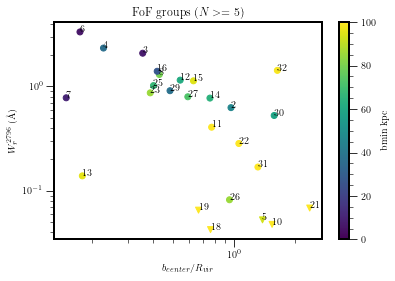

In [61]:
plt.title("FoF groups ($N >= 5$)")
#plt.errorbar(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none')
plt.scatter(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c = G5_abs["b_min_kpc"], vmin = 0, vmax = 100)
plt.scatter(G5_noabs["b_center_kpc_norm2"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5", \
             c = G5_noabs["b_min_kpc"], vmin = 0, vmax = 100)
plt.colorbar(label = "bmin kpc")

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_center_kpc_norm2"])
Y = np.array(G5_noabs["detection_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")

# Fit of the MgII decrease

In [62]:
from scipy.optimize import minimize
from scipy import integrate

The fit is performed using the method described in Hogg 2010 but also taking into accout the upper limit as in Dutta 2020 and Rubin 2018. The idea is to take into account the uncertainties along the 2 axis by taking the distance to the linear relation. 

First, when we look at the uncertainties we can see that there is a nan values:

In [63]:
G5_abs[["b_min_kpc","b_center_kpc_norm2", "REW_2796", "sig_REW_2796"]]

b_min_kpc  b_center_kpc_norm2  REW_2796  sig_REW_2796
1       46.37            0.963220     0.627         0.030
2        7.77            0.354076     2.085         0.016
3       36.59            0.226956     2.336         0.010
5        6.06            0.173869     3.335         0.025
6       10.36            0.148748     0.779         0.037
7       79.59            0.427539     1.303         0.028
10     113.48            0.773294     0.407         0.012
11      60.96            0.541460     1.150           NaN
12      96.06            0.178625     0.139         0.011
13      64.36            0.758720     0.774         0.022
14      95.16            0.629321     1.133         0.017
15      27.24            0.417291     1.399         0.036
21     141.71            1.053020     0.284         0.022
22      84.85            0.385689     0.869         0.017
24      67.41            0.400024     1.020         0.013
25      84.86            0.947106     0.082         0.015
26      72.37            0.590455     0.797         0.015
28      37.77            0.482583     0.911         0.021
29      58.22            1.571653     0.527         0.009
30     125.53            1.306956     0.169         0.010
31      99.21            1.629254     1.427         0.009

In [64]:
G5_noabs[["b_center_kpc_norm2", "REW_2796", "sig_REW_2796", "detection_limit"]]

b_center_kpc_norm2  REW_2796  sig_REW_2796  detection_limit
4             1.376444       0.0           0.0         0.052611
9             1.534437       0.0           0.0         0.047620
17            0.763724       0.0           0.0         0.042440
18            0.666459       0.0           0.0         0.065211
20            2.350602       0.0           0.0         0.068306

we affect a value:

In [65]:
idx = G5_abs.index[G5_abs["sig_REW_2796"].isnull()].to_list()
G5_abs.loc[idx, "sig_REW_2796" ] = 0.05
G5_abs[["b_min_kpc","b_center_kpc_norm2", "REW_2796", "sig_REW_2796"]]

b_min_kpc  b_center_kpc_norm2  REW_2796  sig_REW_2796
1       46.37            0.963220     0.627         0.030
2        7.77            0.354076     2.085         0.016
3       36.59            0.226956     2.336         0.010
5        6.06            0.173869     3.335         0.025
6       10.36            0.148748     0.779         0.037
7       79.59            0.427539     1.303         0.028
10     113.48            0.773294     0.407         0.012
11      60.96            0.541460     1.150         0.050
12      96.06            0.178625     0.139         0.011
13      64.36            0.758720     0.774         0.022
14      95.16            0.629321     1.133         0.017
15      27.24            0.417291     1.399         0.036
21     141.71            1.053020     0.284         0.022
22      84.85            0.385689     0.869         0.017
24      67.41            0.400024     1.020         0.013
25      84.86            0.947106     0.082         0.015
26      72.37            0.590455     0.797         0.015
28      37.77            0.482583     0.911         0.021
29      58.22            1.571653     0.527         0.009
30     125.53            1.306956     0.169         0.010
31      99.21            1.629254     1.427         0.009

In [66]:
Abs = pd.read_csv("MgII_all_absorption")

The likelihood from Dutta is composed of 2 terms:

\begin{equation}
    L(W) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma_i^2}}\exp\left(-\frac{1}{2}\left[\frac{W_i - W(R_i)}{\sigma_i}\right]^2\right)
\times \prod_{i=1}^m \int_{-\infty}^{W_i} \frac{dW'}{\sqrt{2\pi\sigma_i^2}}\exp\left(-\frac{1}{2}\left[\frac{W' - W(R_i)}{\sigma_i}\right]^2\right)
\end{equation}

The first one is the classic one for points that have MgII detection. The second term is there to take into account the points that have an upper detection limit. To compute this second term we can use the erf function, defined as:

\begin{equation}
    erf(z) = \frac{2}{\pi}\int_0^{z} e^{-t^2}dt
\end{equation}

For that we Pose, for each subterm i: 
\begin{equation}
    x = \frac{W'-W(R_i)}{\sqrt{2}\sigma_i}
\end{equation}

hence we have:
\begin{equation}
    dx = \frac{dW'}{\sqrt{2}\sigma_i}
\end{equation}

And for $W' = Wi$ we have 
\begin{equation}
    x = \frac{W_i-W(R_i)}{\sqrt{2}\sigma_i}\equiv{}X
\end{equation}

In consequence:
\begin{equation}
    I = \frac{\sqrt{2}\sigma_i}{\sqrt{2\pi\sigma_i^2}}\int_{-\infty}^{X} e^{-x^2}dx
\end{equation}

So: 
\begin{equation}
    I = \frac{1}{\sqrt{\pi}}\left[\int_{-\infty}^{0} e^{-x^2}dx + \int_{0}^{X} e^{-x^2}dx\right]
\end{equation}
\begin{equation}
    I = \frac{1}{\sqrt{\pi}}\left[\frac{\sqrt{\pi}}{2}+ \frac{\sqrt{\pi}}{2} erf(X)\right]
\end{equation}
\begin{equation}
    I = \frac{1}{2}\left[1+ erf(X)\right]
\end{equation}


So Finally, the total likelihood is: 
\begin{equation}
    L(W) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma_i^2}}\exp\left(-\frac{1}{2}\left[\frac{W_i - W(R_i)}{\sigma_i}\right]^2\right)
\times \prod_{i=1}^m \frac{1}{2}\left[1+ erf(X_i)\right]
\end{equation}



We also have to take into accout an intrisic scatter $\sigma_c$. For that we use the method described in Chen 2010. We first assume a value and then we iter to refine the intrisic scatter.
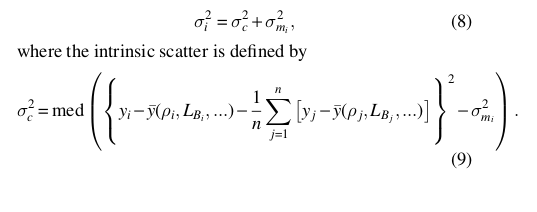

In [67]:
def calc_sigma_intrisic(yi, modeled_yi, sigma_mi):
    """
    compute the intrisic scatter from the comparison between data and model.
    It must be used iteratively until convergence to an intrisic scatter value.
    """

    
    mean_residual = np.mean(yi-modeled_yi)
    
    intrisic_i = (yi - modeled_yi - mean_residual)**2 - sigma_mi**2
    sigma_intri = np.median(intrisic_i)
    
    print("yi = ", yi)
    print("modeled_yi = ", modeled_yi)
    print("sigma_mi = ", sigma_mi)
    print("mean_residual = ", mean_residual)
    print("sigma_intrisic = ", sigma_intri**0.5)
    
    return sigma_intri**0.5

### for bcenter/Rvir

We define the input data:

In [68]:
x1 = np.array(G5_abs["b_center_kpc_norm2"])
x2 = np.array(G5_noabs["b_center_kpc_norm2"])
y1 = np.array(np.log(G5_abs["REW_2796"]))
y2 = np.array(np.log(G5_noabs["detection_limit"]))
sig_x1 = np.array(G5_abs["b_center_kpc_norm2_err"])
sig_x2 = np.array(G5_noabs["b_center_kpc_norm2_err"])
sig_y1 = np.array(G5_abs["sig_REW_2796"]/G5_abs["REW_2796"])
sig_y2 = np.array(np.ones(len(x2))*0.3)

the y-uncertainties for the point with no detection are not defined in the catalog but we must affect a value. When we look at the plots above we can see that the uncertainty increase when the REW decrease (which is logical). if we plot the uncertainty as a function of the REW (see below) we can assume that a value of ~ 0.3 is of the good order of magnitude.

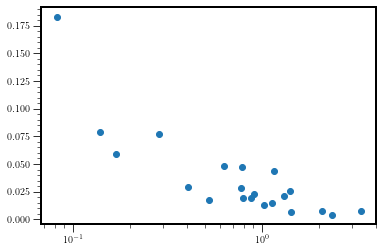

In [69]:
plt.scatter(G5_abs["REW_2796"], G5_abs["sig_REW_2796"]/G5_abs["REW_2796"])
plt.xscale("log")
#plt.yscale("log")

With the method from **David Hogg 2010**:

In [70]:
 def model(param, x):
    # y = ax +b
    return param[0] + param[1]*x

def logL_Hogg_only_abs(param):
    print("param = ", param[0], param[1])
    theta = np.arctan(param[1])
    print("theta = ", theta)

    N = len(x1)
    LL = 0
    
    for i in range(N):
        xi = x1[i]
        yi = y1[i]
        sig_xi = sig_x1[i]
        sig_yi = sig_y1[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
    
        LL += -Deltai_2/Sigmai_2/2
    
    return -LL

def logL_Hogg_all(param):
    print("param = ", param[0], param[1])
    theta = np.arctan(param[1])
    print("theta = ", theta)

    N1 = len(x1)
    N2 = len(x2)
    LL = 0
    
    for i in range(N1):
        xi = x1[i]
        yi = y1[i]
        sig_xi = sig_x1[i]
        sig_yi = sig_y1[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
    
        LL += -Deltai_2/Sigmai_2/2
    
    for i in range(N2):
        xi = x2[i]
        yi = y2[i]
        sig_xi = sig_x2[i]
        sig_yi = sig_y2[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
    
        LL += -Deltai_2/Sigmai_2/2
    
    return -LL


def logL_Hogg_with_lim(param):
    print("param = ", param[0], param[1])
    theta = np.arctan(param[1])
    print("theta = ", theta)

    N1 = len(x1)
    LL = 0
    
    for i in range(N1):
        xi = x1[i]
        yi = y1[i]
        sig_xi = sig_x1[i]
        sig_yi = sig_y1[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
    
        LL += -Deltai_2/Sigmai_2/2
        
    N2 = len(x2)
    for i in range(N2):
        xi = x2[i]
        yi = y2[i]
        sigi = sig_y2[i]
        X = (yi - model(param, xi))/sigi/((2**0.5))
        #X = (yi - model(param, xi))
        I = 0.5*(1 + math.erf(X))
        #print(param, " xi: ", xi, " yi: ", yi, ", model yi = ", model(param, xi), "yi - ymodel = ",yi - model(param, xi) )
        #print("I = ", I)
        #LL2i.append(np.log(I))
        LL += np.log(I)
    
    return -LL


def logL_Hogg_total(param):
    print("param = ", param[0], param[1])
    theta = np.arctan(param[1])
    #print("theta = ", theta)

    LL1i = []
    LL2i = []
    
    N1 = len(x1)
    LL = 0
    
    for i in range(N1):
        xi = x1[i]
        yi = y1[i]
        sig_xi = sig_x1[i]
        sig_yi = sig_y1[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
    
        LL += -Deltai_2/Sigmai_2/2
        LL1i.append(-Deltai_2/Sigmai_2/2)
        
    N2 = len(x2)
    for i in range(N2):
        xi = x2[i]
        yi = y2[i]
        sig_xi = sig_x2[i]
        sig_yi = sig_y2[i]
        
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
        X = -(Deltai_2/Sigmai_2/2)**0.5
        I = 0.5*(1 + math.erf(X))
        LL += np.log(I)
        print(" X = ", X, "----  I = ", I, "--- log(I) = ", np.log(I))
        LL2i.append(np.log(I))
        
    print("LL = ", LL)
    print("LL1 terms: ", LL1i)
    print("LL2 terms: ", LL2i)
    
    X = np.linspace(0.05, 1.5, 50)
    plt.figure()
    plt.scatter(x1,y1)
    plt.scatter(x2,y2)
    plt.plot(X, model(param, X), linewidth = 1.5, c = "green")    
    return -LL

param =  1.0 -3.0
theta =  -1.2490457723982544
param =  1.0000000149011612 -3.0
theta =  -1.2490457723982544
param =  1.0 -2.999999985098839
theta =  -1.2490457709081384
param =  2.0092371521338994 -2.9607524427173217
theta =  -1.2450742758432218
param =  2.0092371670350606 -2.9607524427173217
theta =  -1.2450742758432218
param =  2.0092371521338994 -2.9607524278161605
theta =  -1.2450742743174101
param =  1.3516015086544737 -2.986326801067108
theta =  -1.2476728215751764
param =  1.351601523555635 -2.986326801067108
theta =  -1.2476728215751764
param =  1.3516015086544737 -2.9863267861659466
theta =  -1.2476728200727627
param =  1.7952411656942293 -5.145292437231976
theta =  -1.3788369898526578
param =  1.7952411805953905 -5.145292437231976
theta =  -1.3788369898526578
param =  1.7952411656942293 -5.145292422330815
theta =  -1.3788369893102852
param =  1.8958294823803004 -5.202958140011002
theta =  -1.380913478180677
param =  1.8958294972814616 -5.202958140011002
theta =  -1.380913478

param =  2.009282601096196 -3.038060887069231
 X =  -0.765457021039434 ----  I =  0.13951083318755025 --- log(I) =  -1.9696130234774607
 X =  -0.28717605559188936 ----  I =  0.34232417654884456 --- log(I) =  -1.0719971062327533
 X =  -3.319525018065243 ----  I =  1.3361849691695404e-06 --- log(I) =  -13.525692042455933
 X =  -3.4937451446069145 ----  I =  3.8881040542726453e-07 --- log(I) =  -14.760174001788041
 X =  -1.0485875357900383 ----  I =  0.06904694142822465 --- log(I) =  -2.672968695137221
LL =  -160.76936335083002
LL1 terms:  [-1.0533789770412303, -0.9401079533430388, -10.77858511653859, -0.5071026145450023, -78.92249077236856, -1.6520439161707507, -0.05389703459589638, -0.028736810643317016, -15.275042204689779, -0.003495208725087037, -0.002459415221199173, -1.2075288034839549, -0.004440240976043949, -6.702926740701319, -3.917741784991991, -2.88997800407595, -0.5870378657128366, -0.16391012780027858, -1.9156575421585758, -0.011583589078779308, -0.15077375887642339]
LL2 term

param =  1.986319583964365 -4.974395895479079
 X =  -1.229726935985798 ----  I =  0.041008894145217134 --- log(I) =  -3.1939663054326703
 X =  -1.20096390415641 ----  I =  0.04471431268210435 --- log(I) =  -3.1074616343833243
 X =  -1.041712434073246 ----  I =  0.07034803831920944 --- log(I) =  -2.6543003803988734
 X =  -1.2214427245569126 ----  I =  0.04204964227291158 --- log(I) =  -3.168904399783395
 X =  -1.8563433513780192 ----  I =  0.004329065624953221 --- log(I) =  -5.442403551257843
LL =  -69.6131468966685
LL1 terms:  [-10.758677733354373, -2.3094625765962187, -0.0014383387162922737, -0.01706077306331953, -21.658753242766863, -0.511473399173409, -0.05949578205105238, -0.15269452703075337, -4.587796846341631, -1.9577270229715726, -1.9549743490906204, -0.4976386807529364, -1.394703540348703, -0.11365912391590403, -0.0013324447077220057, -0.02123605058705701, -0.5872762208889049, -0.015562928526692261, -4.265119640555997, -0.9630738980522672, -0.21695350592011287]
LL2 terms:  [-3

param =  2.2439724785977124 -5.636704378933503
 X =  -1.4677732893408904 ----  I =  0.018958775787723647 --- log(I) =  -3.96548835239791
 X =  -1.374685437695354 ----  I =  0.0259417695821188 --- log(I) =  -3.6519008841430827
 X =  -0.7590229770370315 ----  I =  0.1415412255729891 --- log(I) =  -1.955164257526507
 X =  -0.9510677425541311 ----  I =  0.0893105343296306 --- log(I) =  -2.4156358324397162
 X =  -1.9439930879040865 ----  I =  0.0029868511579114743 --- log(I) =  -5.813535570949051
LL =  -69.04506889373549
LL1 terms:  [-11.34863811753437, -1.639382564458036, -0.19070509692126392, -0.0068097559059015, -20.84848445992262, -0.45037433225435974, -0.07411696508282987, -0.14899031105781607, -3.909885132492992, -2.0517454289894057, -1.9286173853066337, -0.4227872712624763, -1.6199513028633559, -0.09044619976265207, -0.0017863110629613027, -0.11693515754068927, -0.641594989386619, -0.017251829584761506, -4.399811369914581, -1.1204671865141975, -0.21456282846068583]
LL2 terms:  [-3.96

param =  2.2460655253069106 -5.6756471264813015
 X =  -1.4875180474712089 ----  I =  0.01770370025493817 --- log(I) =  -4.0339816072997765
 X =  -1.3889639917726353 ----  I =  0.02474813597999348 --- log(I) =  -3.6990051067433325
 X =  -0.7352784168416827 ----  I =  0.14920695616758395 --- log(I) =  -1.9024209691921687
 X =  -0.9267267339675422 ----  I =  0.09499824160773307 --- log(I) =  -2.3538968969451806
 X =  -1.9515368094318883 ----  I =  0.0028910428969748936 --- log(I) =  -5.8461379779483975
LL =  -69.03764199158041
LL1 terms:  [-11.48809334755674, -1.6956420035264064, -0.16690303480338511, -0.005701238885182116, -20.481165522788473, -0.4747702393302798, -0.07651166660872477, -0.15290239038663608, -3.844990110500535, -2.086745965054576, -1.9624307684942512, -0.444044076091458, -1.6493959886266487, -0.07858427685845927, -0.003653433116827546, -0.12929199301686892, -0.6640569048257315, -0.018532205203616158, -4.425943797731495, -1.137637269963944, -0.21520320008132118]
LL2 terms:

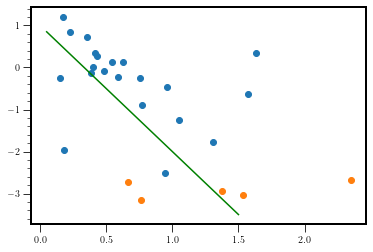

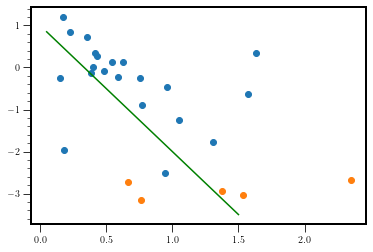

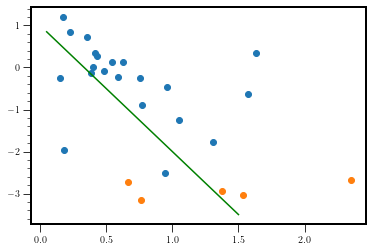

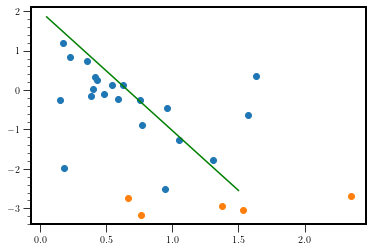

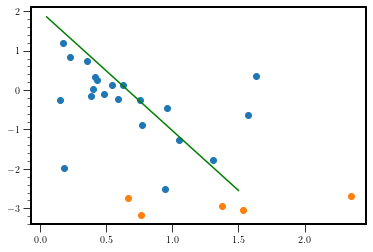

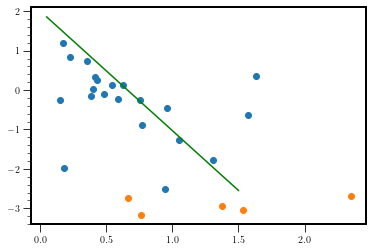

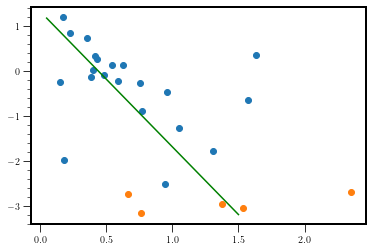

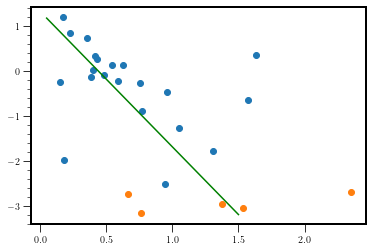

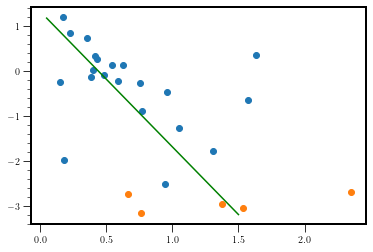

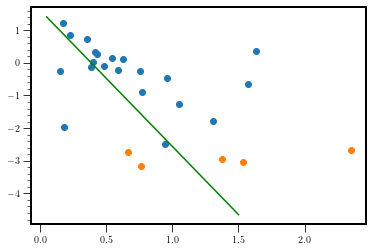

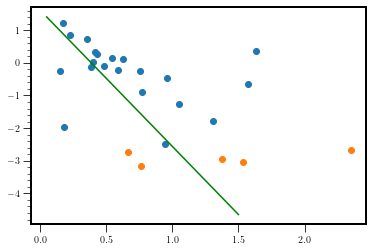

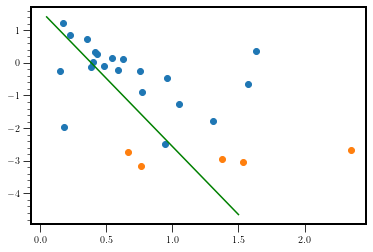

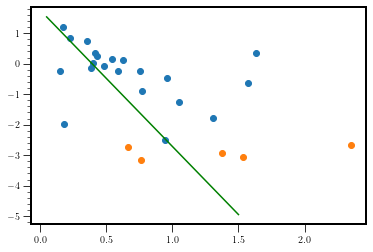

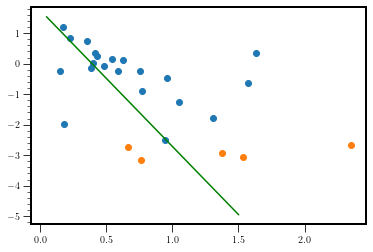

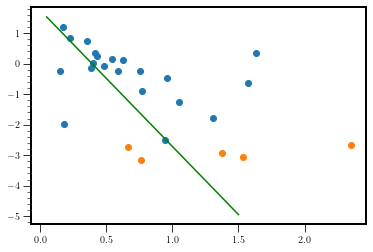

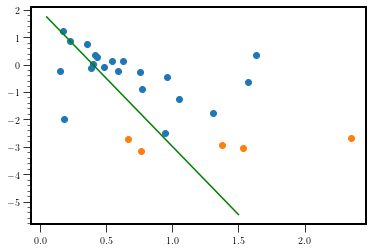

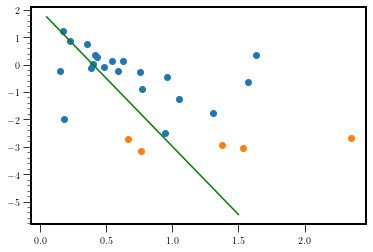

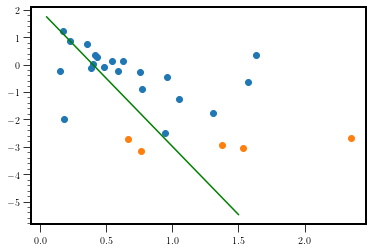

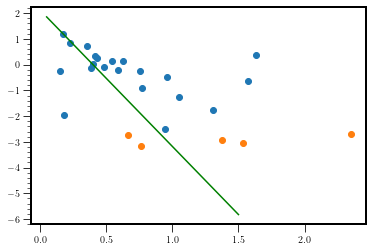

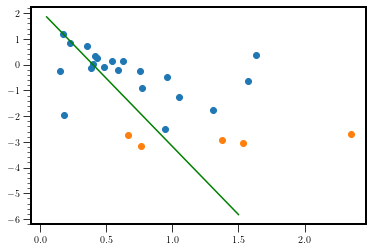

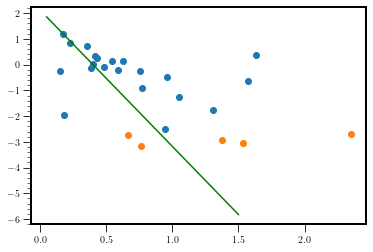

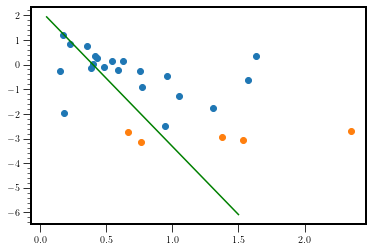

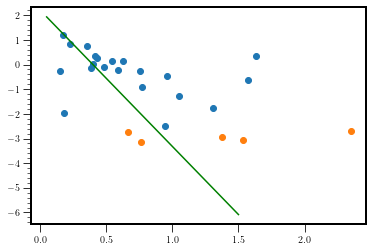

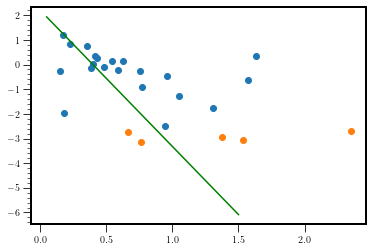

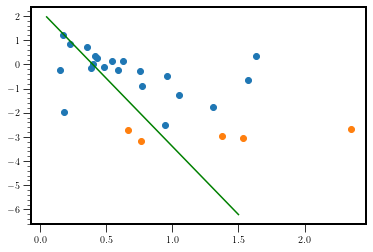

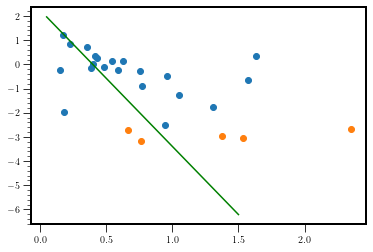

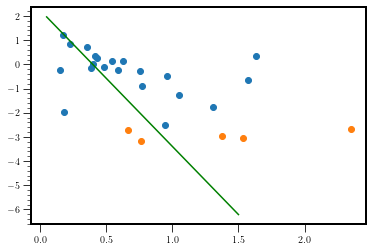

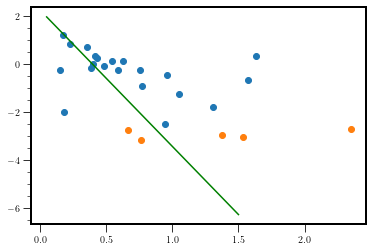

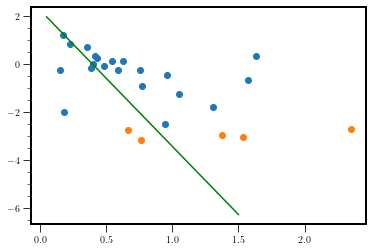

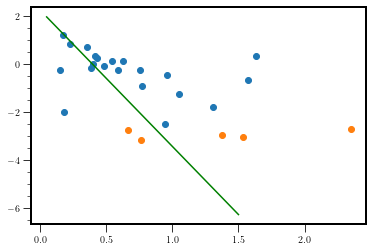

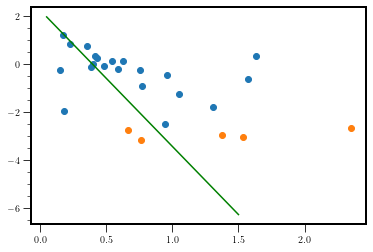

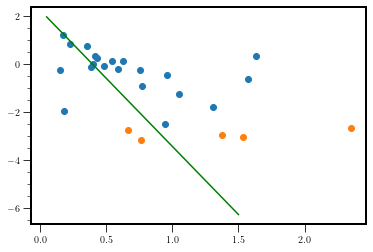

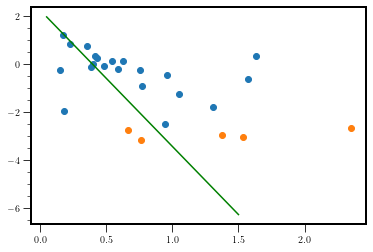

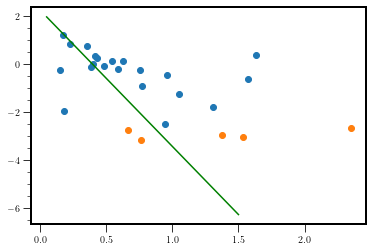

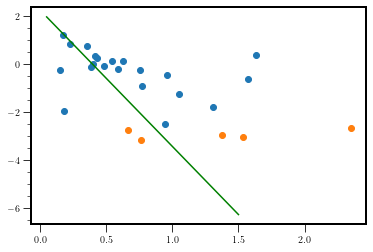

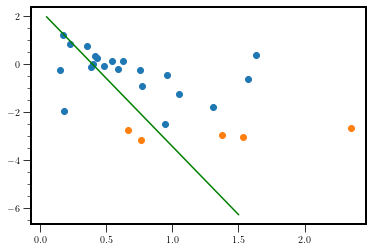

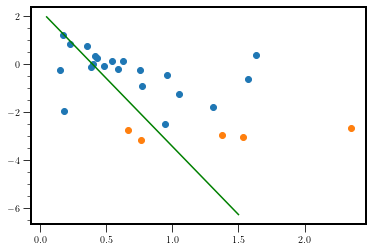

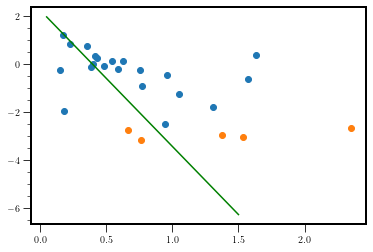

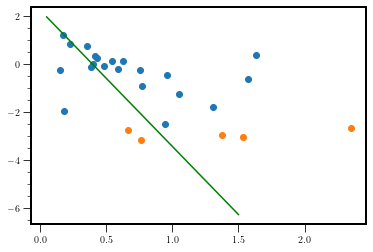

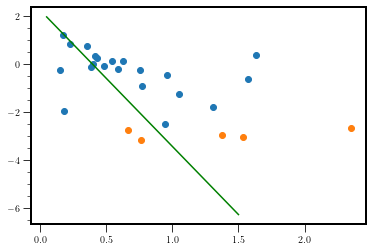

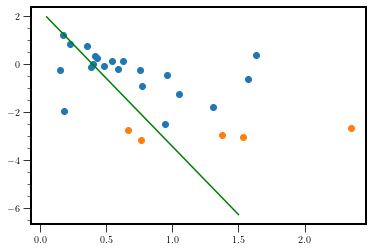

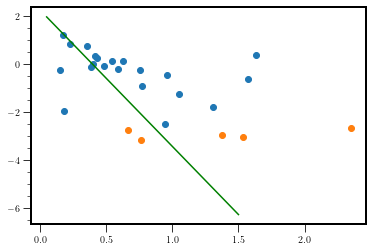

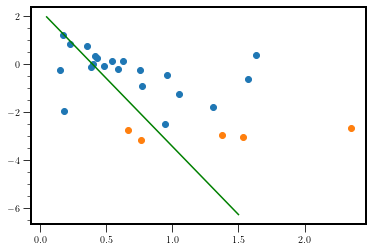

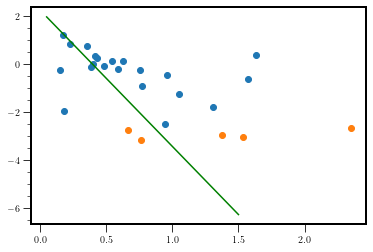

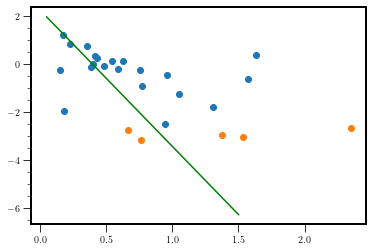

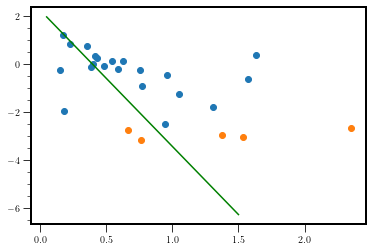

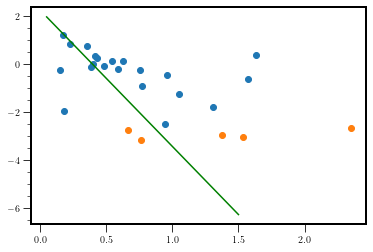

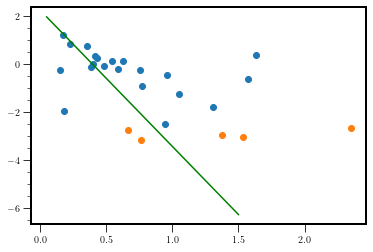

In [71]:
#LL_model_Hogg_only_abs = minimize(logL_Hogg_only_abs, np.array([1,-3]), method='L-BFGS-B')
#LL_model_Hogg_all = minimize(logL_Hogg_all, np.array([1,-3]), method='L-BFGS-B')
#LL_model_Hogg_with_lim = minimize(logL_Hogg_with_lim, np.array([1,-3]), method='L-BFGS-B')
#LL_model_Hogg_total = minimize(logL_Hogg_total, np.array([1,-3]), method='L-BFGS-B')

LL_model_Hogg_only_abs = minimize(logL_Hogg_only_abs, np.array([1,-3]), method='BFGS')
LL_model_Hogg_all = minimize(logL_Hogg_all, np.array([1,-3]), method='BFGS')
LL_model_Hogg_with_lim = minimize(logL_Hogg_with_lim, np.array([1,-3]), method='BFGS')
LL_model_Hogg_total = minimize(logL_Hogg_total, np.array([1,-3]), method='BFGS')

In [72]:
calc_sigma_intrisic(y1, model(LL_model_Hogg_total['x'], x1), sig_y1)

yi =  [-0.46680874  0.73476886  0.84844006  1.20447268 -0.24974423  0.2646693
 -0.89894209  0.13976194 -1.97328135 -0.25618341  0.12486898  0.3357577
 -1.25878104 -0.14041215  0.01980263 -2.50103603 -0.2269006  -0.09321238
 -0.64055473 -1.77785656  0.35557434]
modeled_yi =  [-3.22081464  0.23646439  0.95794813  1.25925029  1.40182652 -0.18048758
 -2.14286043 -0.82705947  1.23225571 -2.06014485 -1.32572754 -0.12232418
 -3.73048655  0.0570369  -0.02432216 -3.12935472 -1.1051396  -0.49289671
 -6.67405299 -5.17173219 -7.00097466]
sigma_mi =  [0.04784689 0.00767386 0.00428082 0.00749625 0.04749679 0.02148887
 0.02948403 0.04347826 0.07913669 0.02842377 0.01500441 0.02573267
 0.07746479 0.01956272 0.0127451  0.18292683 0.01882058 0.02305159
 0.0170778  0.0591716  0.00630694]
mean_residual =  1.2194285471939033
sigma_intrisic =  1.175234651416659


1.175234651416659

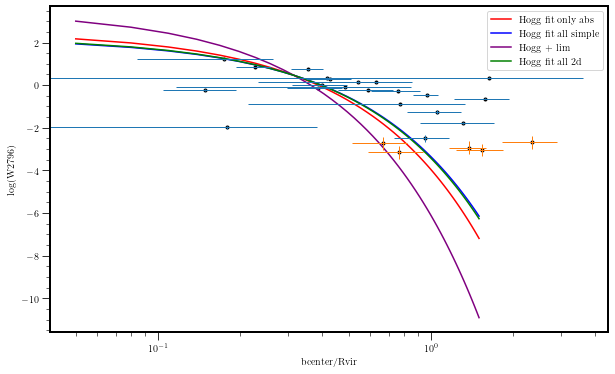

In [73]:
plt.figure(figsize = (10,6))
X = np.linspace(0.05, 1.5, 50)

plt.plot(X, model(LL_model_Hogg_only_abs['x'], X), linewidth = 1.5, c = "red", label = "Hogg fit only abs")
plt.plot(X, model(LL_model_Hogg_all['x'], X), linewidth = 1.5, c = "blue", label = "Hogg fit all simple")
plt.plot(X, model(LL_model_Hogg_with_lim['x'], X), linewidth = 1.5, c = "purple", label = "Hogg + lim")
plt.plot(X, model(LL_model_Hogg_total['x'], X), linewidth = 1.5, c = "green", label = "Hogg fit all 2d")

plt.errorbar(x1,y1,xerr =sig_x1, yerr=sig_y1, fmt = " ")
plt.errorbar(x2,y2,xerr =sig_x2, yerr=sig_y2, fmt = " ")

x = np.array(G5_noabs["b_center_kpc_norm2"])
y = np.array(np.log(G5_noabs["detection_limit"])) 
plt.scatter(x, y, c = "black", marker = ".")

x = np.array(G5_abs["b_center_kpc_norm2"])
y = np.array(np.log(G5_abs["REW_2796"]))
plt.scatter(x, y, c = "black", marker = ".")

plt.xscale("log")
#plt.yscale("log")
plt.xlabel("bcenter/Rvir")
plt.ylabel("log(W2796)")
plt.legend()

Final plot for the MgII EW:

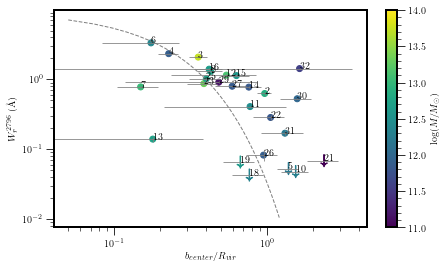

In [74]:
plt.figure(figsize = (7,4))
X = np.linspace(0.05, 1.2, 50)
plt.plot(X, np.exp(model(LL_model_Hogg_total['x'], X)), linewidth = 1.0, c = "gray", label = "best fit", \
         linestyle = "--")

plt.errorbar(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], xerr = G5_abs["b_center_kpc_norm2_err"],\
             yerr = G5_abs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8)
plt.scatter(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c = np.log10(G5_abs["Mvir_sigma2"]), vmin = 11, vmax = 14)
plt.colorbar(label = "log($M/M_{\odot}$)")

plt.errorbar(G5_noabs["b_center_kpc_norm2"], G5_noabs["detection_limit"], xerr = G5_noabs["b_center_kpc_norm2_err"], \
             yerr = G5_noabs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8)
plt.scatter(G5_noabs["b_center_kpc_norm2"], G5_noabs["detection_limit"], marker = "$\downarrow$", s = 150,\
            label = "groups N >= 5", c = np.log10(G5_noabs["Mvir_sigma2"]),vmin = 11, vmax = 14)

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_center_kpc_norm2"])
Y = np.array(G5_noabs["detection_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")
#plt.xlim((0.1,5))

In [75]:
x1 = np.array(G5_abs["b_center_kpc_norm2"])
x2 = np.array(G5_noabs["b_center_kpc_norm2"])
y1 = np.array(np.log(G5_abs["REW_2796"]))
y2 = np.array(np.log(G5_noabs["detection_limit"]))
sig_x1 = np.array(G5_abs["b_center_kpc_norm2_err"])
sig_x2 = np.array(G5_noabs["b_center_kpc_norm2_err"])
sig_y1 = np.array(G5_abs["sig_REW_2796"]/G5_abs["REW_2796"])
sig_y2 = np.array(np.ones(len(x2))*0.3)

In [76]:
def logL_Hogg_total(param):
    theta = np.arctan(param[1])
    #print(sig_y1[0])
    N1 = len(x1)
    LL = 0
    
    for i in range(N1):
        xi = x1[i]
        yi = y1[i]
        sig_xi = sig_x1[i]
        sig_yi = sig_y1[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
        LL += -Deltai_2/Sigmai_2/2
        
    N2 = len(x2)
    for i in range(N2):
        xi = x2[i]
        yi = y2[i]
        sig_xi = sig_x2[i]
        sig_yi = sig_y2[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
        X = -(Deltai_2/Sigmai_2/2)**0.5
        I = 0.5*(1 + math.erf(X))
        LL += np.log(I)    
    return -LL

In [77]:
N = 5
sigma_intrinsic_start = 0
sigma_intrinsic = sigma_intrinsic_start
sigma_intrisic_list = [sigma_intrinsic]
for i in range(N):
    print("N = ", i)
    sig_y1_mi = np.array(G5_abs["sig_REW_2796"]/G5_abs["REW_2796"])
    sig_y1 = (sig_y1_mi**2 + sigma_intrinsic**2)**0.5
    LL_model_Hogg_total = minimize(logL_Hogg_total, np.array([1.5,-4]), method='BFGS')
    sigma_intrinsic = calc_sigma_intrisic(y1, model(LL_model_Hogg_total['x'], x1), sig_y1_mi)
    print(sigma_intrinsic)
    sigma_intrisic_list.append(sigma_intrinsic)

N =  0
yi =  [-0.46680874  0.73476886  0.84844006  1.20447268 -0.24974423  0.2646693
 -0.89894209  0.13976194 -1.97328135 -0.25618341  0.12486898  0.3357577
 -1.25878104 -0.14041215  0.01980263 -2.50103603 -0.2269006  -0.09321238
 -0.64055473 -1.77785656  0.35557434]
modeled_yi =  [-3.22081456  0.23646432  0.95794803  1.25925017  1.4018264  -0.18048763
 -2.1428604  -0.82705949  1.2322556  -2.06014482 -1.32572754 -0.12232423
 -3.73048644  0.05703684 -0.02432222 -3.12935464 -1.10513961 -0.49289674
 -6.67405276 -5.17173203 -7.00097441]
sigma_mi =  [0.04784689 0.00767386 0.00428082 0.00749625 0.04749679 0.02148887
 0.02948403 0.04347826 0.07913669 0.02842377 0.01500441 0.02573267
 0.07746479 0.01956272 0.0127451  0.18292683 0.01882058 0.02305159
 0.0170778  0.0591716  0.00630694]
mean_residual =  1.219428539218781
sigma_intrisic =  1.1752345862382918
1.1752345862382918
N =  1
yi =  [-0.46680874  0.73476886  0.84844006  1.20447268 -0.24974423  0.2646693
 -0.89894209  0.13976194 -1.97328135 

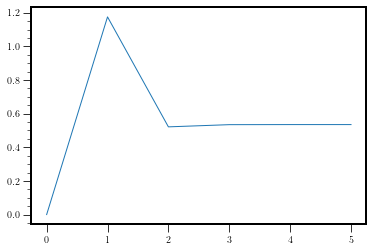

In [78]:
plt.plot(sigma_intrisic_list)

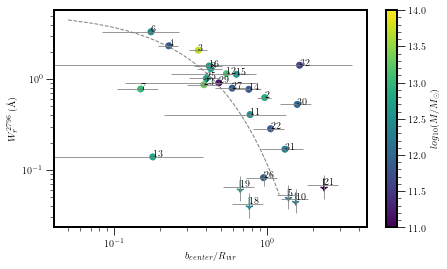

In [79]:
plt.figure(figsize = (7,4))
X = np.linspace(0.05, 1.2, 50)
plt.plot(X, np.exp(model(LL_model_Hogg_total['x'], X)), linewidth = 1.0, c = "gray", label = "best fit", \
         linestyle = "--")

plt.errorbar(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], xerr = G5_abs["b_center_kpc_norm2_err"],\
             yerr = G5_abs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8)
plt.scatter(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c = np.log10(G5_abs["Mvir_sigma2"]), vmin = 11, vmax = 14)
plt.colorbar(label = "$log_{10}(M/M_{\odot}$)")

plt.errorbar(G5_noabs["b_center_kpc_norm2"], G5_noabs["detection_limit"], xerr = G5_noabs["b_center_kpc_norm2_err"], \
             yerr = (np.ones(len(G5_noabs["sig_REW_2796"]))*0.3*G5_noabs["detection_limit"]),\
             fmt = 'none',c = "gray", linewidth = 0.8)
plt.scatter(G5_noabs["b_center_kpc_norm2"], G5_noabs["detection_limit"], marker = "$\downarrow$", s = 150,\
            label = "groups N >= 5", c = np.log10(G5_noabs["Mvir_sigma2"]),vmin = 11, vmax = 14)

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_center_kpc_norm2"])
Y = np.array(G5_noabs["detection_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")
#plt.xlim((0.1,5))

In [80]:
LL_model_Hogg_total

      fun: 36.51305856087389
 hess_inv: array([[ 0.10035783, -0.13917065],
       [-0.13917065,  0.25671429]])
      jac: array([9.53674316e-07, 1.43051147e-06])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([ 1.6992711 , -3.86216431])

In [81]:
sig_y2

array([0.3, 0.3, 0.3, 0.3, 0.3])

In [82]:
0.17904898**0.5

0.4231417965646977

In [83]:
0.33272378**0.5

0.5768221389648632

The 0.1 A EW is reached for: 

In [84]:
np.exp(model(LL_model_Hogg_total['x'], 1.026))

0.10400570957264371

## Now for the plot with bmin

In [85]:
x1 = np.array(G5_abs["b_min_kpc"])
x2 = np.array(G5_noabs["b_min_kpc"])
y1 = np.array(np.log(G5_abs["REW_2796"]))
y2 = np.array(np.log(G5_noabs["detection_limit"]))
#sig_x1 = np.ones(len(x1))*10
#sig_x2 = np.ones(len(x2))*10
sig_x1 = np.zeros(len(x1))
sig_x2 = np.zeros(len(x2))
sig_y1 = np.array(G5_abs["sig_REW_2796"]/G5_abs["REW_2796"])
sig_y2 = np.array(np.ones(len(x2))*0.3)

In [86]:
 def model(param, x):
    # y = ax +b
    return param[0] + param[1]*x

def logL_Hogg_only_abs(param):
    print("param = ", param[0], param[1])
    theta = np.arctan(param[1])
    print("theta = ", theta)

    N = len(x1)
    LL = 0
    
    for i in range(N):
        xi = x1[i]
        yi = y1[i]
        sig_xi = sig_x1[i]
        sig_yi = sig_y1[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
    
        LL += -Deltai_2/Sigmai_2/2
    
    return -LL

def logL_Hogg_all(param):
    print("param = ", param[0], param[1])
    theta = np.arctan(param[1])
    print("theta = ", theta)

    N1 = len(x1)
    N2 = len(x2)
    LL = 0
    
    for i in range(N1):
        xi = x1[i]
        yi = y1[i]
        sig_xi = sig_x1[i]
        sig_yi = sig_y1[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
    
        LL += -Deltai_2/Sigmai_2/2
    
    for i in range(N2):
        xi = x2[i]
        yi = y2[i]
        sig_xi = sig_x2[i]
        sig_yi = sig_y2[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
    
        LL += -Deltai_2/Sigmai_2/2
    
    return -LL


def logL_Hogg_with_lim(param):
    print("param = ", param[0], param[1])
    theta = np.arctan(param[1])
    print("theta = ", theta)

    N1 = len(x1)
    LL = 0
    
    for i in range(N1):
        xi = x1[i]
        yi = y1[i]
        sig_xi = sig_x1[i]
        sig_yi = sig_y1[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
    
        LL += -Deltai_2/Sigmai_2/2
        
    N2 = len(x2)
    for i in range(N2):
        xi = x2[i]
        yi = y2[i]
        sigi = sig_y2[i]
        X = (yi - model(param, xi))/sigi/((2**0.5))
        #X = (yi - model(param, xi))
        I = 0.5*(1 + math.erf(X))
        #print(param, " xi: ", xi, " yi: ", yi, ", model yi = ", model(param, xi), "yi - ymodel = ",yi - model(param, xi) )
        #print("I = ", I)
        #LL2i.append(np.log(I))
        LL += np.log(I)
    
    return -LL


def logL_Hogg_total(param):
    print("param = ", param[0], param[1])
    theta = np.arctan(param[1])
    #print("theta = ", theta)

    LL1i = []
    LL2i = []
    
    N1 = len(x1)
    LL = 0
    
    for i in range(N1):
        xi = x1[i]
        yi = y1[i]
        sig_xi = sig_x1[i]
        sig_yi = sig_y1[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
    
        LL += -Deltai_2/Sigmai_2/2
        LL1i.append(-Deltai_2/Sigmai_2/2)
        
    N2 = len(x2)
    for i in range(N2):
        xi = x2[i]
        yi = y2[i]
        sig_xi = sig_x2[i]
        sig_yi = sig_y2[i]
        
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
        X = -(Deltai_2/Sigmai_2/2)**0.5
        I = 0.5*(1 + math.erf(X))
        LL += np.log(I)
        print(" X = ", X, "----  I = ", I, "--- log(I) = ", np.log(I))
        LL2i.append(np.log(I))
        
    print("LL = ", LL)
    print("LL1 terms: ", LL1i)
    print("LL2 terms: ", LL2i)
    
    X = np.linspace(0.05, 150, 50)
    plt.figure()
    plt.errorbar(x1,y1, xerr = sig_x1, yerr = sig_y1, fmt = " ")
    plt.errorbar(x2,y2, xerr = sig_x2, yerr = sig_y2, fmt = " ")
    plt.scatter(x2,y2)
    plt.scatter(x1,y1)
    plt.scatter(x2,y2)
    plt.plot(X, model(param, X), linewidth = 1.5, c = "green")    
    return -LL

param =  0.0 -0.015
 X =  -3.6526269635095603 ----  I =  1.198378905553632e-07 --- log(I) =  -15.937125919507295
 X =  -1.7859245571813804 ----  I =  0.005773751342138811 --- log(I) =  -5.154433263764182
 X =  -2.8094883378992925 ----  I =  3.545426992873635e-05 --- log(I) =  -10.24726686290992
 X =  -2.099002348274025 ----  I =  0.0014965894007532565 --- log(I) =  -6.504566492560617
 X =  -0.4082540127874276 ----  I =  0.2818486979863888 --- log(I) =  -1.2663848839919614
LL =  -132586.4664602881
LL1 terms:  [-11.427509761123648, -6153.56315791481, -53270.75149927879, -14930.389229582288, -1.9727506210438897, -2303.3881734088995, -371.11315453673325, -293.9275824989481, -22.62871507384351, -311.28940678051475, -5351.3818337363, -418.37314262652365, -62.61353546163516, -1675.1887993311, -3271.606502502788, -22.537624417339618, -1040.7247201213886, -210.81922437219356, -92.86839538218828, -1.5772284268314554, -42729.21449703003]
LL2 terms:  [-15.937125919507295, -5.154433263764182, -10.2

param =  0.004859227179831427 0.2374532390586716
 X =  -59.00856380569674 ----  I =  0.0 --- log(I) =  -inf
 X =  -149.05575868520768 ----  I =  0.0 --- log(I) =  -inf
 X =  -80.87802529285338 ----  I =  0.0 --- log(I) =  -inf
 X =  -75.08591486091663 ----  I =  0.0 --- log(I) =  -inf
 X =  -100.01121585852053 ----  I =  0.0 --- log(I) =  -inf
LL =  -inf
LL1 terms:  [-28795.591466690075, -10557.75009333546, -1679125.305165678, -509.7533099552133, -1633.2747418763563, -376177.08269208693, -446114.7373124955, -54392.48793467168, -49056.1725144954, -149522.32747442715, -1121945.064120919, -28441.93021530863, -101563.83988822912, -538036.6681509225, -787185.7544628773, -7669.87795927287, -428167.2702096934, -77350.79607559554, -358954.80290676624, -142511.1152922711, -6769735.680354163]
LL2 terms:  [-inf, -inf, -inf, -inf, -inf]
param =  0.0024296135899157137 0.11122661952933581
 X =  -31.330595384603154 ----  I =  0.0 --- log(I) =  -inf
 X =  -73.63491706401314 ----  I =  0.0 --- log(I) =

param =  0.0001518508493697321 -0.007110836279416511
 X =  -5.38249998982791 ----  I =  1.3489209749195652e-14 --- log(I) =  -31.936886306896497
 X =  -2.9278780441432772 ----  I =  1.7316542163858806e-05 --- log(I) =  -10.963848318880531
 X =  -5.249130117741608 ----  I =  5.706546346573305e-14 --- log(I) =  -30.494577304221938
 X =  -4.379843364294106 ----  I =  2.9321806094273484e-10 --- log(I) =  -21.950104548417805
 X =  -3.520846570466587 ----  I =  3.1919040927030906e-07 --- log(I) =  -14.9574780179678
LL =  -71021.33178793482
LL1 terms:  [-4.1130854744787335, -5297.261582494526, -33524.82184110701, -13845.283227105048, -6.883200334826671, -746.7745809133345, -4.884789539692435, -86.86929397647678, -132.93527384604556, -25.08259684556023, -1426.3091016663261, -211.5497254146686, -5.260114314278701, -279.8211250040439, -766.4277915165247, -53.81444034341466, -116.72324831517983, -28.886580137209535, -88.11740905085776, -111.94581634098314, -14147.264069697949]
LL2 terms:  [-31.93

param =  1.1013056801792411 -0.013846956625424695
 X =  -6.501207207690183 ----  I =  0.0 --- log(I) =  -inf
 X =  -1.4987729167232897 ----  I =  0.017020529883057467 --- log(I) =  -4.073335023356931
 X =  -5.761805072754602 ----  I =  1.6653345369377348e-16 --- log(I) =  -36.33133546156894
 X =  -5.028109504131121 ----  I =  5.767608612927688e-13 --- log(I) =  -28.181348666143773
 X =  -3.4589260947089375 ----  I =  4.999448184883626e-07 --- log(I) =  -14.508768107637941
LL =  -inf
LL1 terms:  [-187.28960115987127, -569.3252913473032, -1757.4387116837217, -311.4112703099544, -323.20971203259717, -76.29305156657813, -105.80314382741004, -3.6476060307555587, -242.95759300898368, -134.56603387375876, -258.6134273020997, -113.8839316446808, -13.187613243553814, -5.83056959086342, -67.4954869144823, -88.03556518404214, -150.11052090571445, -424.3108580975167, -1500.9656215136265, -185.9000539798064, -4957.778358923749]
LL2 terms:  [-inf, -4.073335023356931, -36.33133546156894, -28.18134866

param =  1.0534696334674176 -0.009801130501110597
 X =  -7.275409562624125 ----  I =  0.0 --- log(I) =  -inf
 X =  -3.80323382063067 ----  I =  3.753679939100252e-08 --- log(I) =  -17.097944068053497
 X =  -6.900000503118943 ----  I =  0.0 --- log(I) =  -inf
 X =  -6.084866609523608 ----  I =  0.0 --- log(I) =  -inf
 X =  -4.94223311532285 ----  I =  1.3805623311213822e-12 --- log(I) =  -27.308530213439596
LL =  -inf
LL1 terms:  [-248.09268997012376, -499.49410891057903, -643.6696501491839, -393.88047371627744, -320.04784893917054, -0.08249126215269485, -406.0134566662972, -26.450503483157114, -347.16211066369135, -285.2049939406487, -0.03687836522089828, -153.4022432083594, -71.03584325162335, -171.45200314205755, -428.1914221895865, -110.77476742154607, -460.3321323142185, -567.340271802538, -2163.60025311252, -366.0334768521089, -946.97405971994]
LL2 terms:  [-inf, -17.097944068053497, -inf, -inf, -27.308530213439596]
param =  1.0534696185662564 -0.009801115599949404
 X =  -7.275412

param =  1.1216162647273495 -0.015432888510663247
 X =  -6.201401144725434 ----  I =  0.0 --- log(I) =  -inf
 X =  -0.5991175891321974 ----  I =  0.19841947452649483 --- log(I) =  -1.6173719310528964
 X =  -5.319316599178601 ----  I =  2.681188604469753e-14 --- log(I) =  -31.249931096584476
 X =  -4.617544210712837 ----  I =  3.2842339958705224e-11 --- log(I) =  -24.139302580572572
 X =  -2.8811566035793295 ----  I =  2.3049649230277858e-05 --- log(I) =  -10.677860006412772
LL =  -inf
LL1 terms:  [-166.37727428330908, -604.9918296628846, -2318.633485225413, -276.80820322214123, -325.2901693541325, -149.32246031830726, -41.69237990791206, -0.4460449335282577, -207.57141144371883, -91.51394374686467, -494.46237554642335, -100.85467217510286, -3.116637376655691, -2.94187286563711, -11.635590189579597, -79.94162685976457, -75.74020122699687, -375.75431931532563, -1278.7925594839094, -132.20813268944545, -7357.295212281412]
LL2 terms:  [-inf, -1.6173719310528964, -31.249931096584476, -24.13

param =  1.1433077942613779 -0.017306927045160934
 X =  -5.841689338295689 ----  I =  5.551115123125783e-17 --- log(I) =  -37.42994775023705
 X =  -0.4694144681942484 ----  I =  0.25339242178303933 --- log(I) =  -1.3728159176865764
 X =  -4.7910021319603775 ----  I =  6.198819235692099e-12 --- log(I) =  -25.80666228787073
 X =  -4.1269522146272735 ----  I =  2.6671688746482403e-09 --- log(I) =  -19.742248273673084
 X =  -2.192985434921886 ----  I =  0.0009632030566375516 --- log(I) =  -6.945246309995368
LL =  -18451.762415792553
LL1 terms:  [-142.44561810854307, -637.7441872655957, -3124.3359984278463, -245.31977171469535, -326.5138268050104, -269.42022134482386, -3.5226855068474565, -0.7010957569022414, -168.80847956399464, -50.48656357355736, -877.2562401569999, -85.30250092403598, -0.2122890942559279, -44.60544229416175, -5.732466966592087, -70.73012576489111, -19.556987266316696, -319.64153235680976, -1033.0302970957302, -80.03371958600778, -10855.065445679475]
LL2 terms:  [-37.429

param =  1.139692554240201 -0.01699458728941132
 X =  -5.901641341156353 ----  I =  5.551115123125783e-17 --- log(I) =  -37.42994775023705
 X =  -0.29132575685080087 ----  I =  0.3401708710101992 --- log(I) =  -1.0783072258191106
 X =  -4.879054578285788 ----  I =  2.5996427233110353e-12 --- log(I) =  -26.675647094454437
 X =  -4.208717582430574 ----  I =  1.3242206220454023e-09 --- log(I) =  -20.44244176034852
 X =  -2.3076806648205 ----  I =  0.0005501224457584719 --- log(I) =  -7.505369675864071
LL =  -17658.149539275575
LL1 terms:  [-146.3052514213225, -632.225575905675, -2981.723801773509, -250.43580397856167, -326.3097323818568, -246.96059499531913, -6.970810146767089, -0.34392470571310046, -174.9910000559574, -56.483349154213755, -805.88861857629, -87.80415147212386, -0.008050311115181572, -34.23973742085603, -2.0354644961162562, -72.22623223600134, -26.375978263101185, -328.67873288024515, -1072.1712417002714, -87.82490002432404, -10225.014873869517]
LL2 terms:  [-37.4299477502

param =  1.1389331765477895 -0.016931217433912883
 X =  -5.913743833321403 ----  I =  5.551115123125783e-17 --- log(I) =  -37.42994775023705
 X =  -0.25525479442922655 ----  I =  0.35905540787998225 --- log(I) =  -1.0242785629044155
 X =  -4.896858301270877 ----  I =  2.176758773231313e-12 --- log(I) =  -26.853184146783384
 X =  -4.225245735302926 ----  I =  1.1476327665960184e-09 --- log(I) =  -20.58556447994939
 X =  -2.330889877545625 ----  I =  0.000489704061250873 --- log(I) =  -7.621709305945746
LL =  -17502.218022880552
LL1 terms:  [-147.08533774911265, -630.9889852793968, -2953.6608860607794, -251.55768910568915, -326.25440767221085, -242.549610421806, -7.809129369733916, -0.28726907910299654, -176.25278197067934, -57.73128952189145, -791.8471070571701, -88.30274578042945, -0.00021560570811317604, -32.31432082422713, -1.5173991621904857, -72.52997965099334, -27.873411232254295, -330.49876457093836, -1080.1307980070376, -89.44393317579821, -10100.067277337583]
LL2 terms:  [-37.4

param =  1.1384110894830952 -0.016887650658257706
 X =  -5.9220642615625 ----  I =  0.0 --- log(I) =  -inf
 X =  -0.23045604288676605 ----  I =  0.3722446883135884 --- log(I) =  -0.9882038766572625
 X =  -4.90909832570075 ----  I =  1.925903880817259e-12 --- log(I) =  -26.975625709915693
 X =  -4.236608805280296 ----  I =  1.03976582899179e-09 --- log(I) =  -20.684270313577418
 X =  -2.3468461761717743 ----  I =  0.0004517964758959936 --- log(I) =  -7.702278754102462
LL =  -inf
LL1 terms:  [-147.62284491656035, -630.1394624897496, -2934.4448653655877, -252.33048419239665, -326.216366641633, -239.5401308026626, -8.413076422417005, -0.2512744620145447, -177.1228828396608, -58.59715264650406, -782.2651914477763, -88.64634050932148, -0.0013620787480711416, -31.022921493739343, -1.2052869700869298, -72.73917473797651, -28.92687147980101, -331.75293473599464, -1085.6200273795896, -90.565592853029, -10014.611707201444]
LL2 terms:  [-inf, -0.9882038766572625, -26.975625709915693, -20.684270313

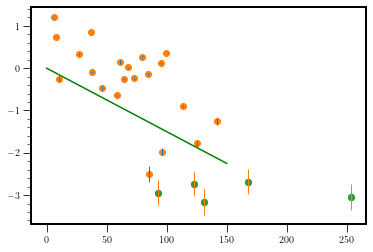

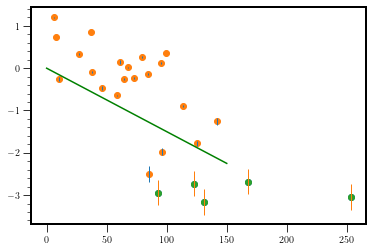

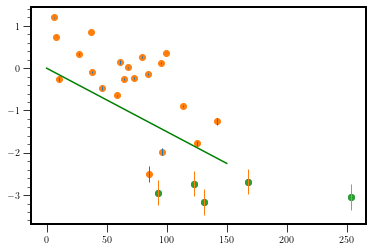

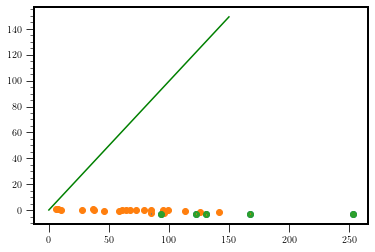

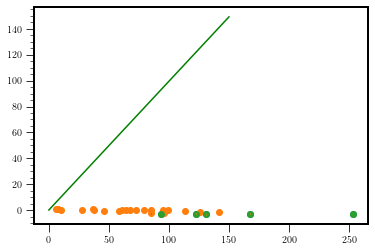

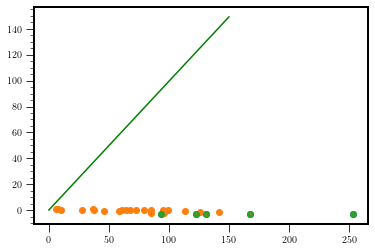

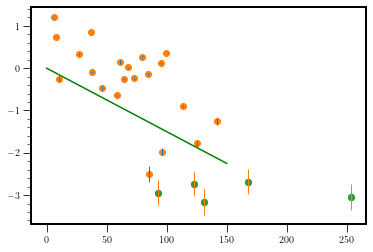

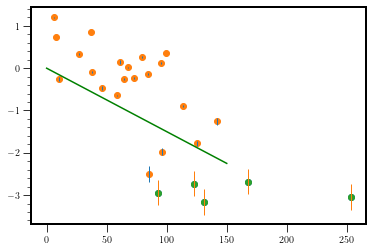

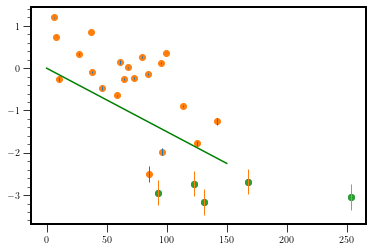

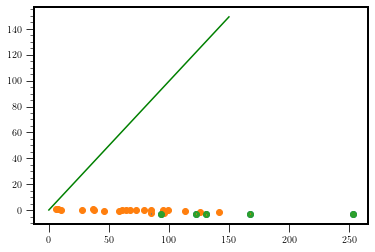

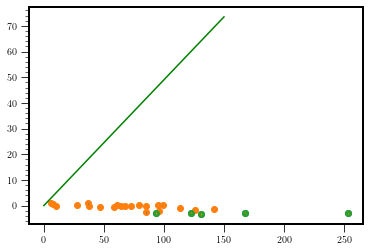

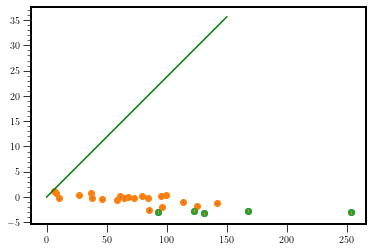

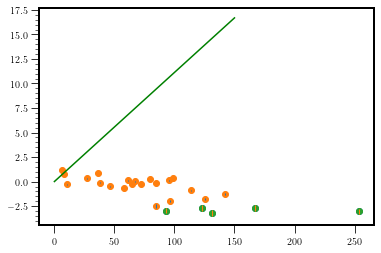

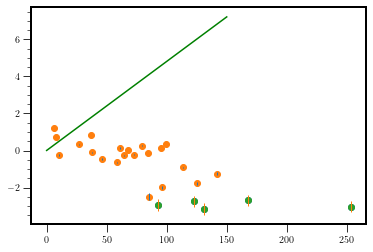

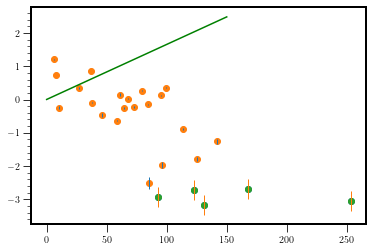

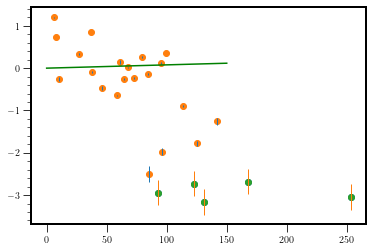

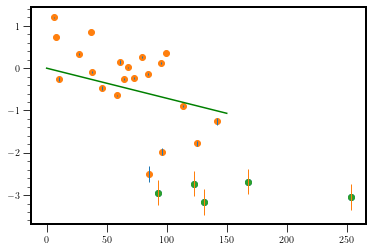

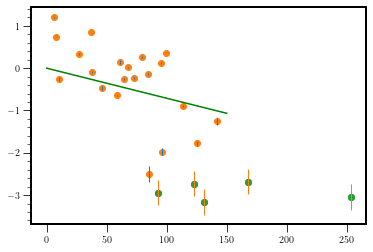

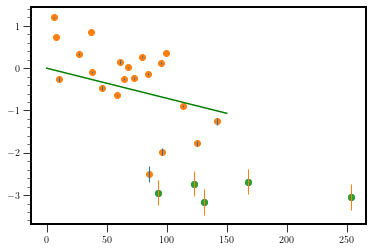

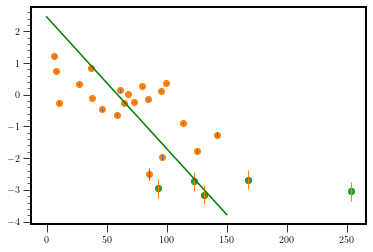

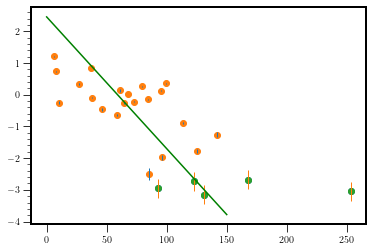

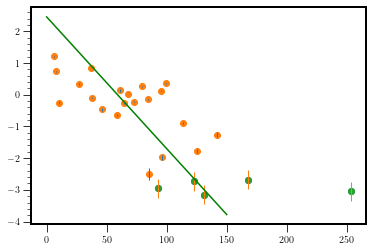

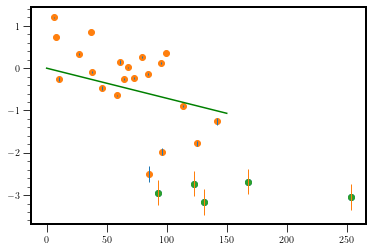

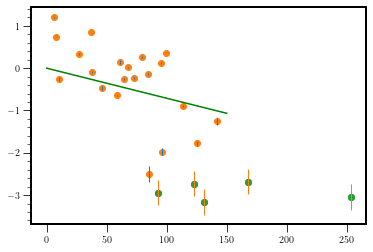

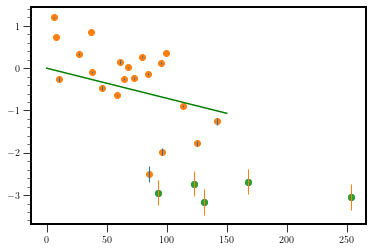

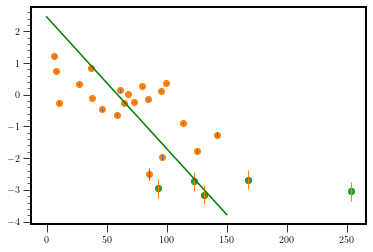

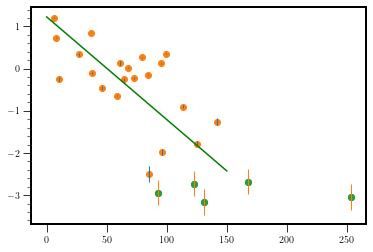

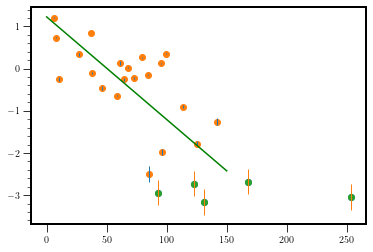

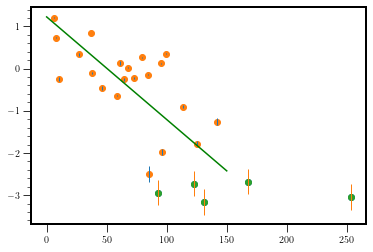

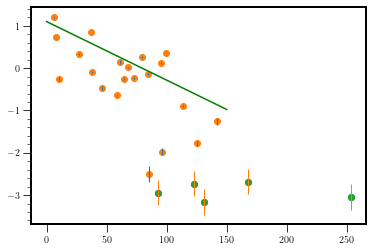

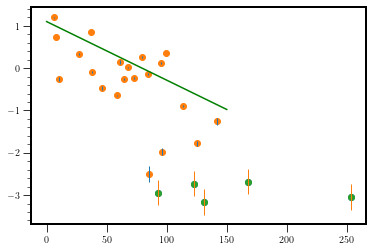

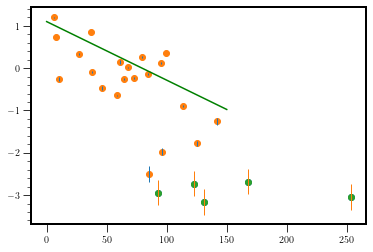

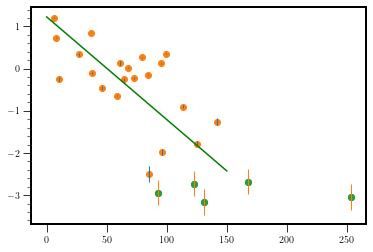

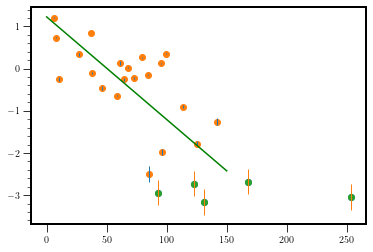

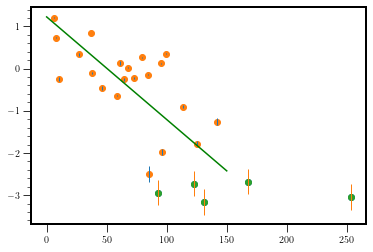

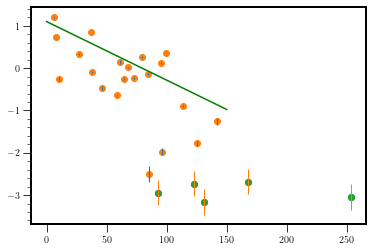

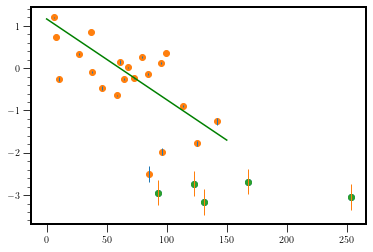

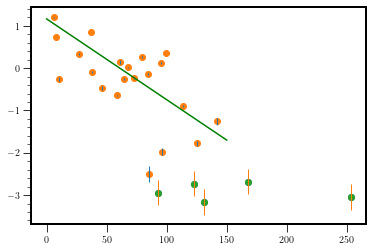

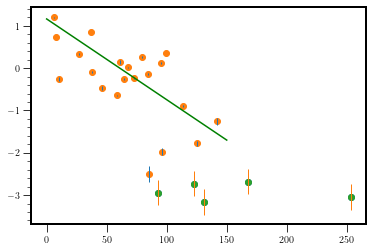

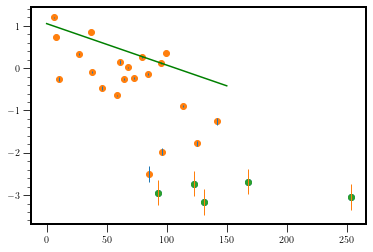

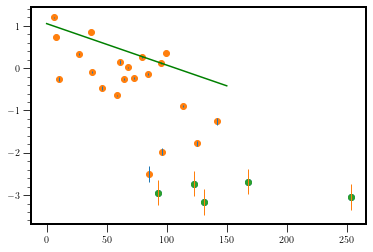

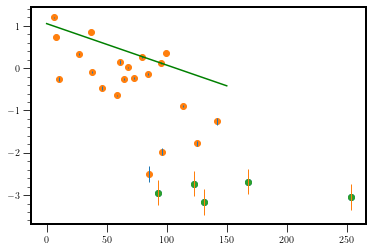

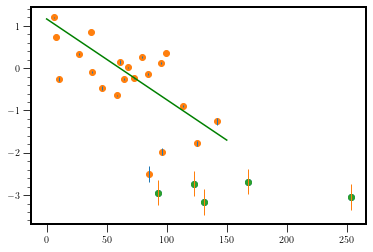

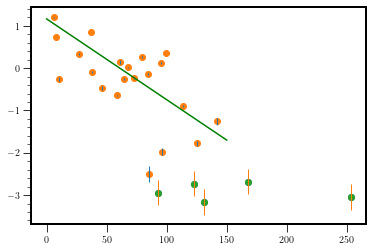

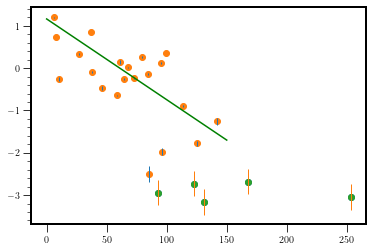

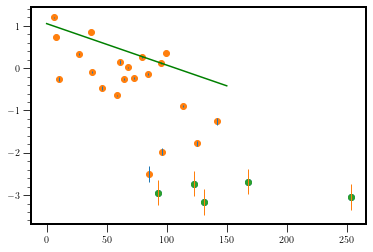

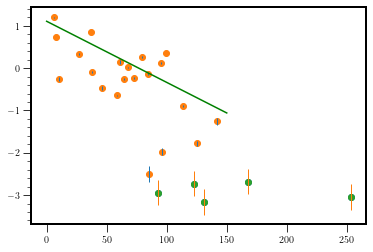

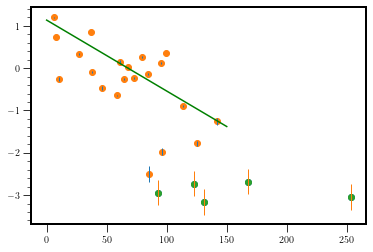

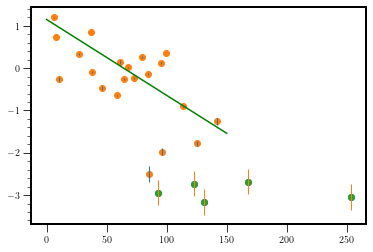

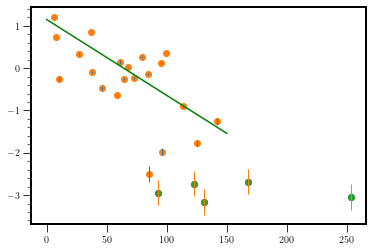

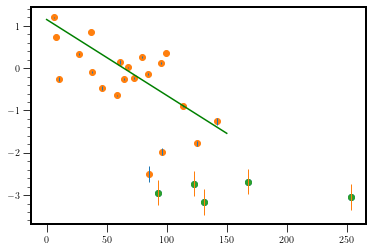

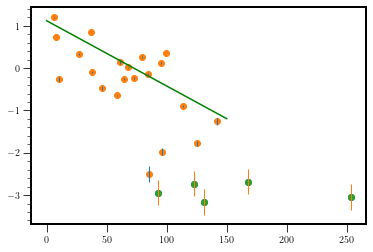

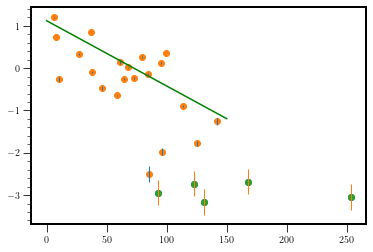

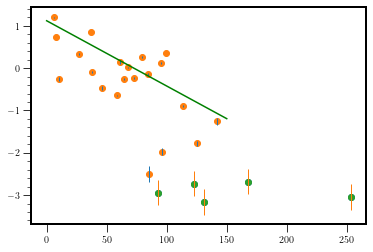

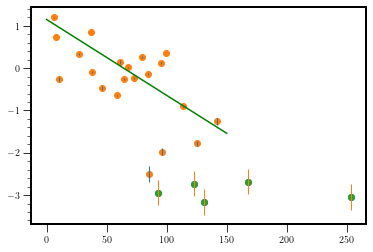

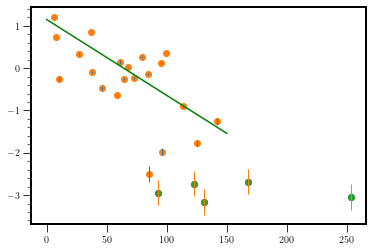

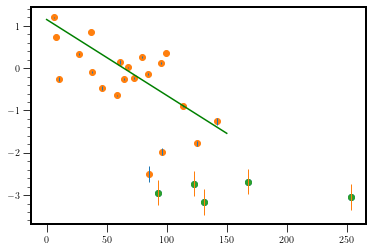

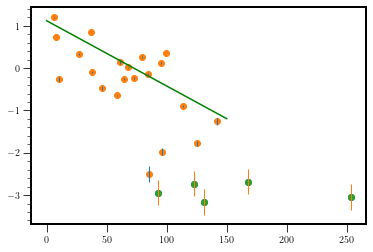

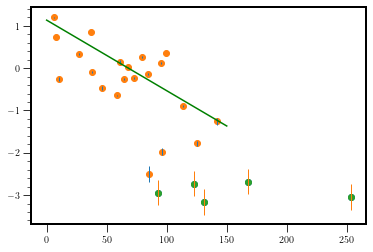

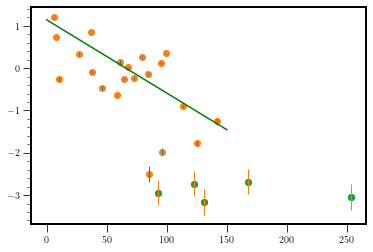

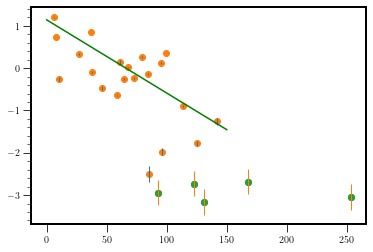

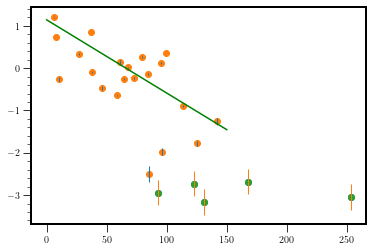

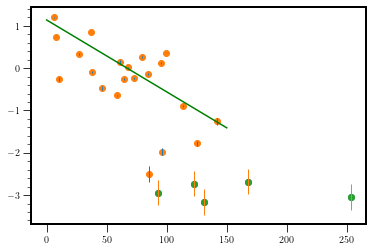

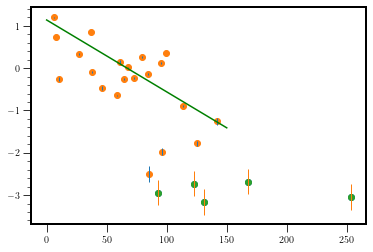

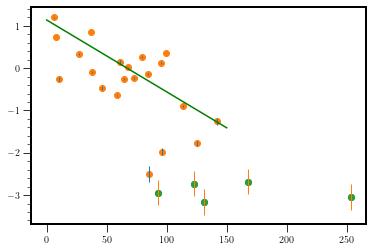

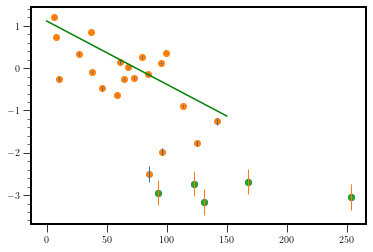

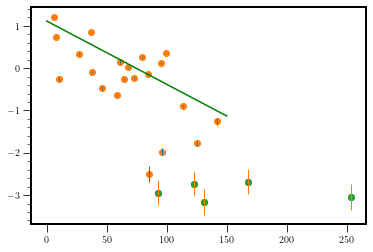

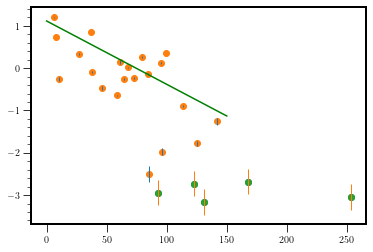

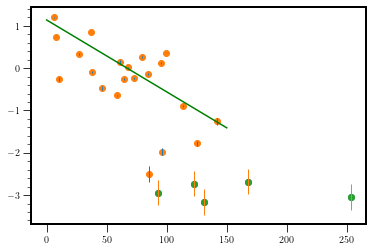

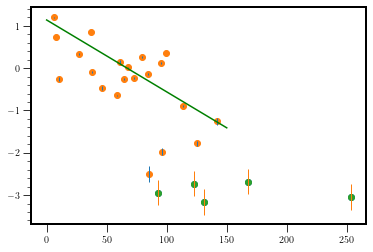

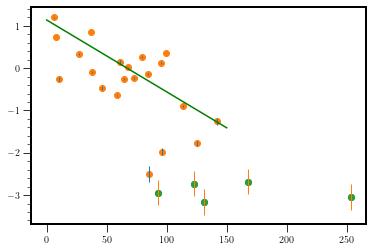

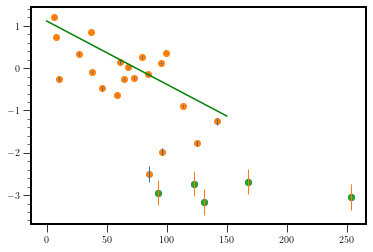

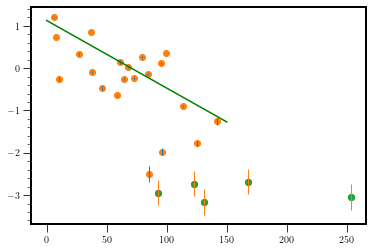

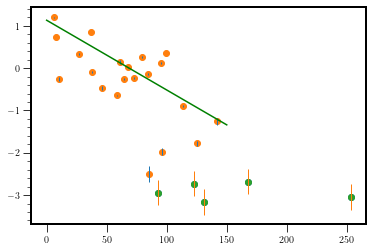

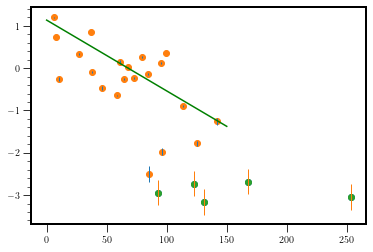

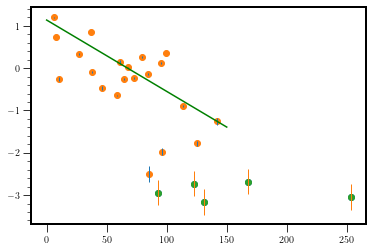

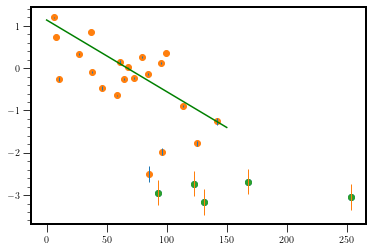

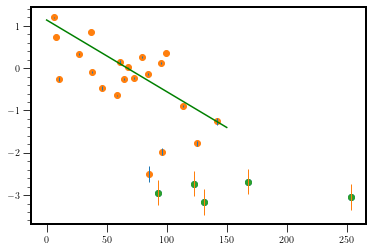

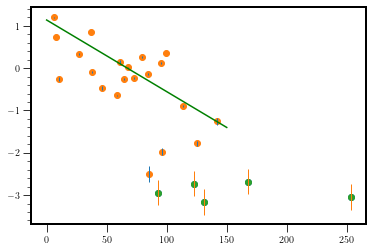

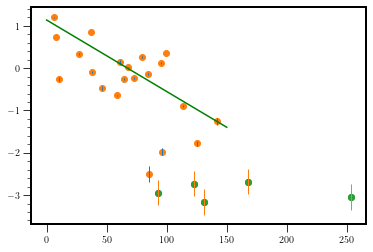

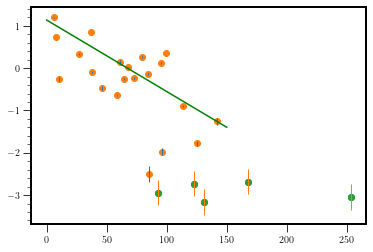

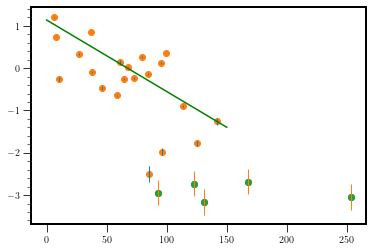

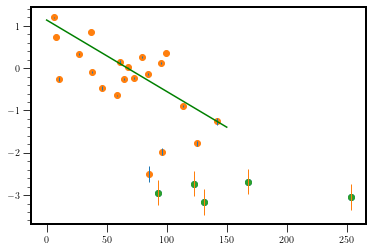

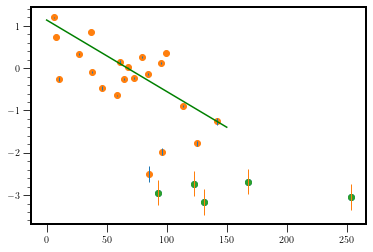

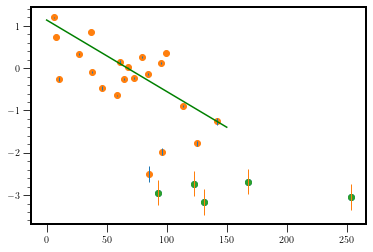

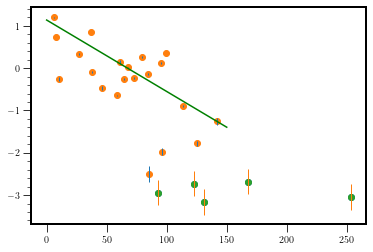

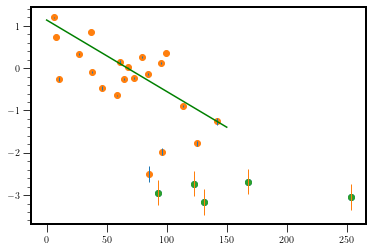

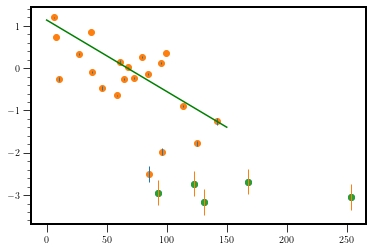

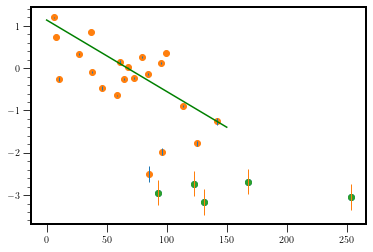

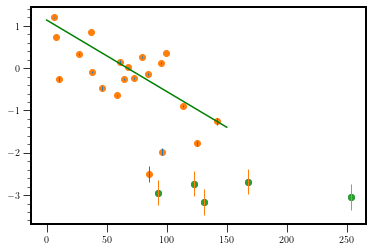

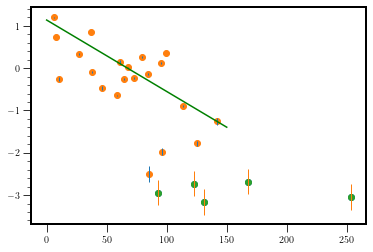

In [87]:
#LL_Hogg_total = minimize(logL_Hogg_total, np.array([0,-0.015]), method='L-BFGS-B')
#LL_Hogg_total = minimize(logL_Hogg_total, np.array([0,-0.015]), method='CG')
LL_Hogg_total_bmin = minimize(logL_Hogg_total, np.array([0,-0.015]), method='BFGS')

In [88]:
LL_Hogg_total_bmin

      fun: 17658.150086185295
 hess_inv: array([[ 2.07632743e-05, -2.91371319e-07],
       [-2.91371319e-07,  6.14418084e-09]])
      jac: array([  -36702.48999023, -2911282.38916016])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 91
      nit: 5
     njev: 23
   status: 2
  success: False
        x: array([ 1.13969254, -0.01699459])

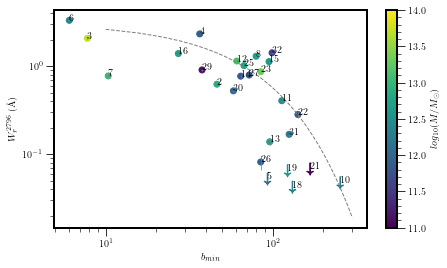

In [89]:
plt.figure(figsize = (7,4))
X = np.linspace(10, 300, 50)
plt.plot(X, np.exp(model(LL_Hogg_total_bmin['x'], X)), linewidth = 1.0, c = "gray", label = "best fit", \
         linestyle = "--")

plt.errorbar(G5_abs["b_min_kpc"], G5_abs["REW_2796"], xerr = G5_abs["b_center_kpc_norm2_err"],\
             yerr = G5_abs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8)
plt.scatter(G5_abs["b_min_kpc"], G5_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c = np.log10(G5_abs["Mvir_sigma2"]), vmin = 11, vmax = 14)
plt.colorbar(label = "$log_{10}(M/M_{\odot}$)")

plt.errorbar(G5_noabs["b_min_kpc"], G5_noabs["detection_limit"], xerr = G5_noabs["b_center_kpc_norm2_err"], \
             yerr = G5_noabs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8)
plt.scatter(G5_noabs["b_min_kpc"], G5_noabs["detection_limit"], marker = "$\downarrow$", s = 150,\
            label = "groups N >= 5", c = np.log10(G5_noabs["Mvir_sigma2"]),vmin = 11, vmax = 14)

X = np.array(G5_abs["b_min_kpc"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_min_kpc"])
Y = np.array(G5_noabs["detection_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{min}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")
#plt.xlim((0.1,5))

## now with the intrisic scatter computation

In [90]:
x1 = np.array(G5_abs["b_min_kpc"])
x2 = np.array(G5_noabs["b_min_kpc"])
y1 = np.array(np.log(G5_abs["REW_2796"]))
y2 = np.array(np.log(G5_noabs["detection_limit"]))
#sig_x1 = np.ones(len(x1))*10
#sig_x2 = np.ones(len(x2))*10
sig_x1 = np.zeros(len(x1))
sig_x2 = np.zeros(len(x2))
sig_y1 = np.array(G5_abs["sig_REW_2796"]/G5_abs["REW_2796"])
sig_y2 = np.array(np.ones(len(x2))*0.3)

In [91]:
def logL_Hogg_total(param):
    theta = np.arctan(param[1])
    #print(sig_y1[0])
    N1 = len(x1)
    LL = 0
    
    for i in range(N1):
        xi = x1[i]
        yi = y1[i]
        sig_xi = sig_x1[i]
        sig_yi = sig_y1[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
        LL += -Deltai_2/Sigmai_2/2
        
    N2 = len(x2)
    for i in range(N2):
        xi = x2[i]
        yi = y2[i]
        sig_xi = sig_x2[i]
        sig_yi = sig_y2[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
        X = -(Deltai_2/Sigmai_2/2)**0.5
        I = 0.5*(1 + math.erf(X))
        LL += np.log(I)    
    return -LL

In [92]:
N = 15
sigma_intrinsic_start = 0
sigma_intrinsic = sigma_intrinsic_start
sigma_intrisic_list = [sigma_intrinsic]
for i in range(N):
    print("N = ", i)
    sig_y1_mi = np.array(G5_abs["sig_REW_2796"]/G5_abs["REW_2796"])
    sig_y1 = (sig_y1_mi**2 + sigma_intrinsic**2)**0.5
    LL_model_Hogg_total = minimize(logL_Hogg_total, np.array([0,-0.015]), method='BFGS')
    sigma_intrinsic = calc_sigma_intrisic(y1, model(LL_model_Hogg_total['x'], x1), sig_y1_mi)
    print(sigma_intrinsic)
    sigma_intrisic_list.append(sigma_intrinsic)

N =  0
yi =  [-0.46680874  0.73476886  0.84844006  1.20447268 -0.24974423  0.2646693
 -0.89894209  0.13976194 -1.97328135 -0.25618341  0.12486898  0.3357577
 -1.25878104 -0.14041215  0.01980263 -2.50103603 -0.2269006  -0.09321238
 -0.64055473 -1.77785656  0.35557434]
modeled_yi =  [ 0.35165353  1.0076446   0.51786059  1.03670534  0.96362862 -0.21290666
 -0.78885323  0.1037025  -0.49280752  0.0459209  -0.47751239  0.67675998
 -1.26861043 -0.30229819 -0.00591259 -0.30246814 -0.09020574  0.49780698
  0.15026767 -0.993638   -0.54634047]
sigma_mi =  [0.04784689 0.00767386 0.00428082 0.00749625 0.04749679 0.02148887
 0.02948403 0.04347826 0.07913669 0.02842377 0.01500441 0.02573267
 0.07746479 0.01956272 0.0127451  0.18292683 0.01882058 0.02305159
 0.0170778  0.0591716  0.00630694]
mean_residual =  -0.3012378181292798
sigma_intrisic =  0.4689452458698493
0.4689452458698493
N =  1
yi =  [-0.46680874  0.73476886  0.84844006  1.20447268 -0.24974423  0.2646693
 -0.89894209  0.13976194 -1.9732813

yi =  [-0.46680874  0.73476886  0.84844006  1.20447268 -0.24974423  0.2646693
 -0.89894209  0.13976194 -1.97328135 -0.25618341  0.12486898  0.3357577
 -1.25878104 -0.14041215  0.01980263 -2.50103603 -0.2269006  -0.09321238
 -0.64055473 -1.77785656  0.35557434]
modeled_yi =  [-0.26513571  0.43493361 -0.08776064  0.46594704  0.38796005 -0.86763061
 -1.48227697 -0.52974741 -1.16633894 -0.59141155 -1.15001608  0.08181574
 -1.99427067 -0.96302866 -0.6467279  -0.96321002 -0.736685   -0.10916172
 -0.48005337 -1.70082192 -1.22346895]
sigma_mi =  [0.04784689 0.00767386 0.00428082 0.00749625 0.04749679 0.02148887
 0.02948403 0.04347826 0.07913669 0.02842377 0.01500441 0.02573267
 0.07746479 0.01956272 0.0127451  0.18292683 0.01882058 0.02305159
 0.0170778  0.0591716  0.00630694]
mean_residual =  0.33959489731411835
sigma_intrisic =  0.4124062256211112
0.4124062256211112
N =  13
yi =  [-0.46680874  0.73476886  0.84844006  1.20447268 -0.24974423  0.2646693
 -0.89894209  0.13976194 -1.97328135 -0.2

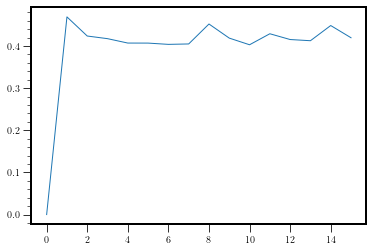

In [93]:
plt.plot(sigma_intrisic_list)

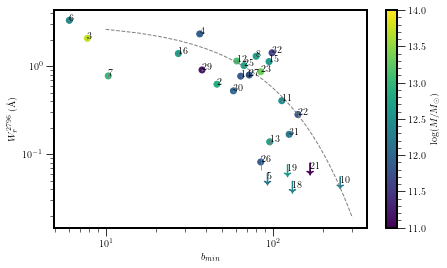

In [94]:
plt.figure(figsize = (7,4))
X = np.linspace(10, 300, 50)
plt.plot(X, np.exp(model(LL_Hogg_total_bmin['x'], X)), linewidth = 1.0, c = "gray", label = "best fit", \
         linestyle = "--")

plt.errorbar(G5_abs["b_min_kpc"], G5_abs["REW_2796"], xerr = G5_abs["b_center_kpc_norm2_err"],\
             yerr = G5_abs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8)
plt.scatter(G5_abs["b_min_kpc"], G5_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c = np.log10(G5_abs["Mvir_sigma2"]), vmin = 11, vmax = 14)
plt.colorbar(label = "log($M/M_{\odot}$)")

plt.errorbar(G5_noabs["b_min_kpc"], G5_noabs["detection_limit"], xerr = G5_noabs["b_center_kpc_norm2_err"], \
             yerr = G5_noabs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8)
plt.scatter(G5_noabs["b_min_kpc"], G5_noabs["detection_limit"], marker = "$\downarrow$", s = 150,\
            label = "groups N >= 5", c = np.log10(G5_noabs["Mvir_sigma2"]),vmin = 11, vmax = 14)

X = np.array(G5_abs["b_min_kpc"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_min_kpc"])
Y = np.array(G5_noabs["detection_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{min}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")
#plt.xlim((0.1,5))

In [95]:
LL_Hogg_total_bmin['x']

array([ 1.13969254, -0.01699459])

In [96]:
LL_Hogg_total_bmin

      fun: 17658.150086185295
 hess_inv: array([[ 2.07632743e-05, -2.91371319e-07],
       [-2.91371319e-07,  6.14418084e-09]])
      jac: array([  -36702.48999023, -2911282.38916016])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 91
      nit: 5
     njev: 23
   status: 2
  success: False
        x: array([ 1.13969254, -0.01699459])

In [97]:
(2.07785533e-05)**0.5

0.004558349843967661

In [98]:
(6.16777322e-09)**0.5

7.853517186585893e-05

# Normalized by the Rvir of the closest galaxy

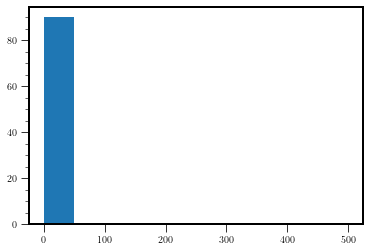

In [99]:
plt.hist(G3["Rvir_closest"], range = (0,  500));

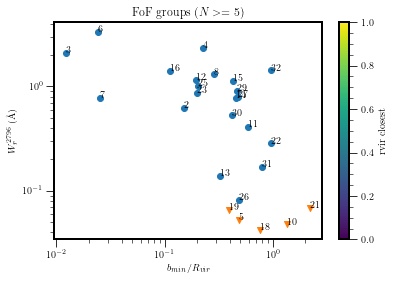

In [100]:
plt.title("FoF groups ($N >= 5$)")
#plt.errorbar(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none')
plt.scatter(G5_abs["b_min_kpc_norm2"], G5_abs["REW_2796"], marker = "o", label = "groups N >= 5")
plt.scatter(G5_noabs["b_min_kpc_norm2"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5")
plt.colorbar(label = "rvir closest")

X = np.array(G5_abs["b_min_kpc_norm2"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_min_kpc_norm2"])
Y = np.array(G5_noabs["detection_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{min}/R_{vir}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")

(0.01, 5)

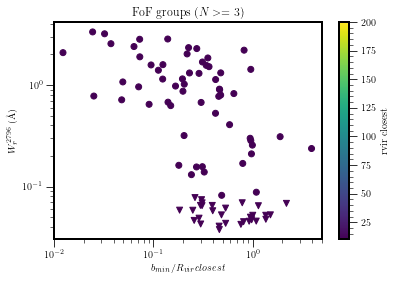

In [101]:
plt.title("FoF groups ($N >= 3$)")
#plt.errorbar(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none')
plt.scatter(G3_abs["b_min_kpc_norm2"], G3_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c=G3_abs["Rvir_closest"], vmin = 10, vmax = 200)
plt.scatter(G3_noabs["b_min_kpc_norm2"], G3_noabs["detection_limit"], marker = "v", label = "groups N >= 5", \
           c=G3_noabs["Rvir_closest"], vmin = 10, vmax = 200)
plt.colorbar(label = "rvir closest")

X = np.array(G3_abs["b_min_kpc_norm2"])
Y = np.array(G3_abs["REW_2796"])
txt = np.array(G3_abs["ID"])

#for i in range(len(G3_abs)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G3_noabs["b_min_kpc_norm2"])
Y = np.array(G3_noabs["detection_limit"])
txt = np.array(G3_noabs["ID"])

#for i in range(len(G3_noabs)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{min}/R_{vir} closest$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")
plt.xlim((0.01, 5))

# Investigation other parameters

### Group mass

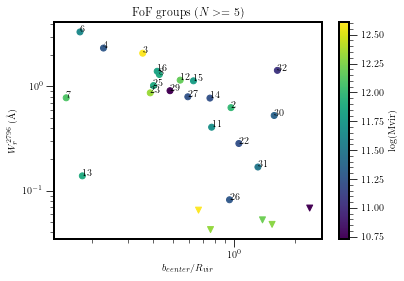

In [102]:
plt.title("FoF groups ($N >= 5$)")
#plt.errorbar(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none')
plt.scatter(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c = np.log10(G5_abs["Mvir_sigma2"]))
plt.scatter(G5_noabs["b_center_kpc_norm2"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5", \
             c = np.log10(G5_noabs["Mvir_sigma2"]))
plt.colorbar(label = "log(Mvir)")

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")

In [103]:
G[["ID", "N_gal", "mean_z", "zqso_sdss", "QSO_is_behind", "MgII_2796_lim", "REW_2796"]].head(30)

ID  N_gal    mean_z  zqso_sdss  QSO_is_behind  MgII_2796_lim  REW_2796
0    1     21  0.937542      0.938          False          10.52     0.118
1    2     21  0.987775      1.532           True          10.90     0.627
2    3     13  0.831174      1.927           True          10.71     2.085
3    4     11  0.744963      1.925           True            NaN     2.336
4    5     10  0.901378      1.925           True            NaN     0.000
5    6      9  0.637238      1.222           True          10.72     3.335
6    7      8  0.606026      1.798           True          11.01     0.779
7    8      7  0.970296      2.238           True          10.89     1.303
8    9      7  0.872727      0.875          False          10.63     0.000
9   10      7  1.099736      1.484           True          10.65     0.000
10  11      7  1.331220      1.605           True          10.52     0.407
11  12      7  1.432120      2.389           True          10.86     1.150
12  13      6  0.835952      1.595           True          10.47     0.139
13  14      6  0.940495      1.770           True          10.77     0.774
14  15      6  1.214250      1.669           True          10.61     1.133
15  16      6  1.137177      1.798           True          11.00     1.399
16  17      6  0.260037      1.618           True            inf     0.000
17  18      5  1.356080      1.927           True          10.67     0.000
18  19      5  0.533110      0.875           True          10.81     0.000
19  20      5  1.397632      1.927           True            inf     0.000
20  21      5  0.464324      0.875           True          10.81     0.000
21  22      5  0.823512      1.770           True          10.75     0.284
22  23      5  1.043106      1.669           True          10.59     0.869
23  24      5  0.630146      0.875           True            inf     0.000
24  25      5  0.607382      1.294           True            NaN     1.020
25  26      5  0.599996      1.294           True          10.61     0.082
26  27      5  0.806336      1.669           True          10.54     0.797
27  28      5  1.483590      1.484          False          10.42     0.000
28  29      5  0.987006      1.880           True          10.75     0.911
29  30      5  1.295142      1.925           True          10.38     0.527

Text(0, 0.5, 'M from M*')

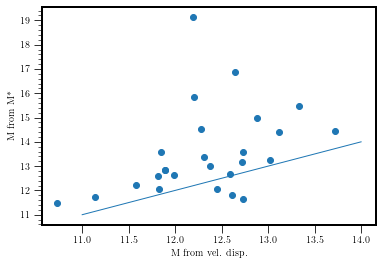

In [104]:
plt.scatter(np.log10(G5["Mvir_sigma2"]), G5["Mhalo"])
plt.plot([11, 14], [11, 14])
plt.xlabel("M from vel. disp.")
plt.ylabel("M from M*")

# Column density

In [105]:
G5_abs["NHI"], G5_abs["sigma_NHI"] = gid.Fukugita(G5_abs["REW_2796"], G5_abs["sig_REW_2796"], G5_abs["center_z"])
G5_abs["NHI_limit"], _ = gid.Fukugita(G5_abs["detection_limit"], 1, G5_abs["center_z"])
G5_noabs["NHI"], G5_noabs["sigma_NHI"] = gid.Fukugita(G5_noabs["REW_2796"], G5_noabs["sig_REW_2796"], G5_noabs["center_z"])
G5_noabs["NHI_limit"], G5_noabs["sigma_NHI"] = gid.Fukugita(G5_noabs["detection_limit"], \
                        0.2*G5_noabs["detection_limit"], G5_noabs["center_z"])

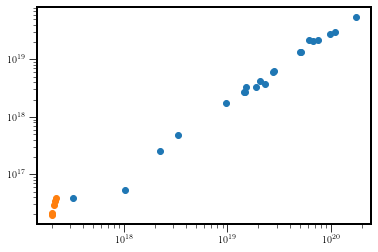

In [106]:
plt.scatter(G5_abs["NHI"], G5_abs["sigma_NHI"])
plt.scatter(G5_noabs["NHI_limit"], G5_noabs["sigma_NHI"])
plt.xscale("log")
plt.yscale("log")

In [107]:
G5_noabs["sigma_NHI"]

4     2.975192e+16
9     3.373966e+16
17    3.852419e+16
18    2.162482e+16
20    1.994972e+16
Name: sigma_NHI, dtype: float64

We cannot make a single plot with just 2 different y axis (1 for W2796 and 1 for NHI) because the NHI conversion depends on the redshift...

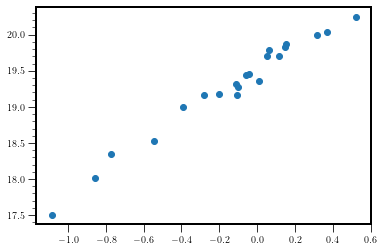

In [108]:
plt.scatter(np.log10(G5["REW_2796"]), np.log10(G5["NHI"]))

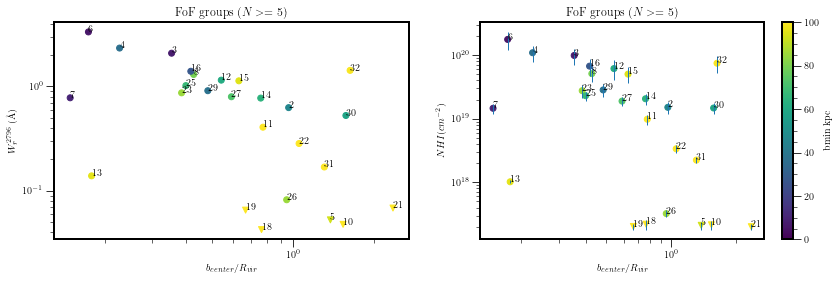

In [109]:
plt.figure(figsize = (14,4))
plt.subplot(121)
plt.title("FoF groups ($N >= 5$)")
##plt.errorbar(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none')
plt.scatter(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c = G5_abs["b_min_kpc"], vmin = 0, vmax = 100)
plt.scatter(G5_noabs["b_center_kpc_norm2"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5", \
             c = G5_noabs["b_min_kpc"], vmin = 0, vmax = 100)
#plt.colorbar(label = "bmin kpc")

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_center_kpc_norm2"])
Y = np.array(G5_noabs["detection_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")

plt.subplot(122)
plt.title("FoF groups ($N >= 5$)")
plt.errorbar(G5_abs["b_center_kpc_norm2"], G5_abs["NHI"], yerr = G5_abs["sigma_NHI"], fmt = 'none')
plt.scatter(G5_abs["b_center_kpc_norm2"], G5_abs["NHI"], marker = "o", label = "groups N >= 5", \
            c = G5_abs["b_min_kpc"], vmin = 0, vmax = 100)
plt.errorbar(G5_noabs["b_center_kpc_norm2"], G5_noabs["NHI_limit"], yerr = G5_noabs["sigma_NHI"], fmt = 'none')
plt.scatter(G5_noabs["b_center_kpc_norm2"], G5_noabs["NHI_limit"],\
            marker = "v", label = "groups N >= 5", \
             c = G5_noabs["b_min_kpc"], vmin = 0, vmax = 100)
plt.colorbar(label = "bmin kpc")

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["NHI"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_center_kpc_norm2"])
Y = np.array(G5_noabs["NHI_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$NHI (cm^{-2})$")
#plt.grid()
plt.xscale("log")
plt.yscale("log")

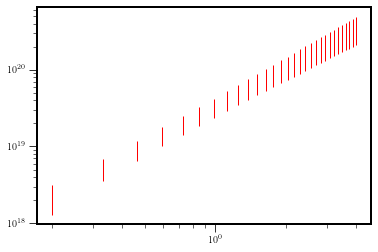

In [110]:
W = np.linspace(0.2, 4, 30)
N, sig = gid.Fukugita(W, 0.05, 1)
#plt.errorbar(G5_abs["REW_2796"], G5_abs["NHI"], yerr = G5_abs["sigma_NHI"], fmt = 'none')
#plt.scatter(G5_abs["REW_2796"], G5_abs["NHI"], c = G5_abs["center_z"])
plt.errorbar(W, N, yerr = sig, fmt = 'none', c = "r")
#plt.scatter(W, N)
#plt.colorbar()
plt.yscale("log")
plt.xscale("log")

In [111]:
G5[["REW_2796", "sig_REW_2796", "NHI", "sigma_NHI"]]

REW_2796  sig_REW_2796           NHI     sigma_NHI
1      0.627         0.030  1.508940e+19  3.312701e+18
2      2.085         0.016  9.870159e+19  2.806266e+19
3      2.336         0.010  1.089716e+20  3.040277e+19
4      0.000         0.000  0.000000e+00           NaN
5      3.335         0.025  1.764128e+20  5.507816e+19
6      0.779         0.037  1.457710e+19  2.700410e+18
7      1.303         0.028  5.111697e+19  1.367921e+19
9      0.000         0.000  0.000000e+00           NaN
10     0.407         0.012  9.805288e+18  1.750110e+18
11     1.150           NaN  6.141676e+19           NaN
12     0.139         0.011  1.018386e+18  5.444694e+16
13     0.774         0.022  2.057472e+19  4.259307e+18
14     1.133         0.017  5.022818e+19  1.367273e+19
15     1.399         0.036  6.705365e+19  2.060885e+19
17     0.000         0.000  0.000000e+00           NaN
18     0.000         0.000  0.000000e+00           NaN
20     0.000         0.000  0.000000e+00           NaN
21     0.284         0.022  3.363939e+18  4.762597e+17
22     0.869         0.017  2.758262e+19  6.126835e+18
24     1.020         0.013  2.297952e+19  3.711236e+18
25     0.082         0.015  3.220570e+17  3.872946e+16
26     0.797         0.015  1.890464e+19  3.287545e+18
28     0.911         0.021  2.832403e+19  6.399697e+18
29     0.527         0.009  1.472975e+19  2.747462e+18
30     0.169         0.010  2.234675e+18  2.578999e+17
31     1.427         0.009  7.458150e+19  2.150498e+19

# With DM profile

On the NHI vs b plot, we can add the standard NFW DM profile. But we must care about the fact that the NHI is a column density, ie a density integrated along the LOS. In order to compare things consistently, it is necessary to convert NFW density into a column density (a cut is necessary or it will diverge) or alternatively to convert the column density into a density (with a strong assumption of a spherical distribution of NHI?)...

In [112]:
from scipy import integrate

Text(0, 0.5, 'log10(rho)')

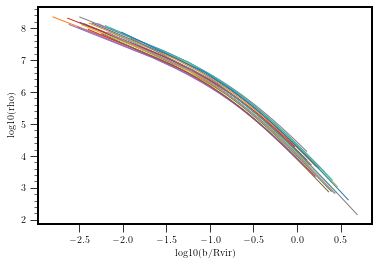

In [113]:
b = np.linspace(1, 400)
rho = gid.nfw_rho(b, 2e6, 30)
rvir = G5_abs["Mvir_sigma2"]
mvir = G5_abs["Mvir_sigma2"]

for i, g in G5_abs.iterrows():
    r = g["Rvir_sigma2"]
    m = g["Mvir_sigma2"]
    z = g["center_z"]
    rho0, rs = gid.get_nfw_param(m, z)
    rho = gid.nfw_rho(b, rho0, rs)
    plt.plot(np.log10(b/r), np.log10(rho))
plt.xlabel("log10(b/Rvir)")
plt.ylabel("log10(rho)")

In [114]:
def nfw_rho_2(theta, b, rhoO, rs):
    K = b/np.cos(theta)/rs
    D = K*(1+K)**2
    rho = rho0*b/D/((np.cos(theta))**2)
    return rho

Text(0, 0.5, 'rho')

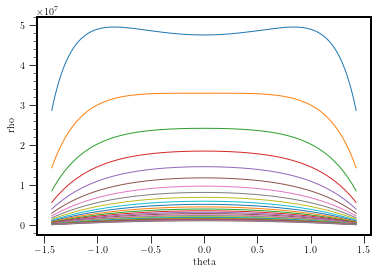

In [115]:
t = np.linspace(-np.pi/2.2, np.pi/2.2, num = 200)
for b in range(2, 30):
    plt.plot(t, nfw_rho_2(t, 10*b, 2e6, 30))
plt.xlabel("theta")
plt.ylabel("rho")

In [116]:
integrate.quad(nfw_rho_2, -np.pi/2, np.pi/2, args = (100, 2e6, 30))

(15735945.541255943, 1.0018451991041158e-06)

336.71036909029146


(0.0, 0.1)

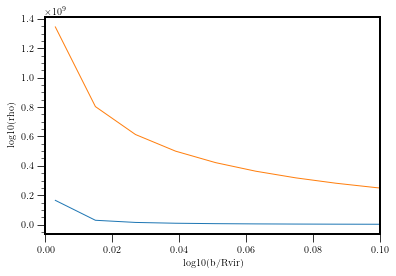

In [117]:
b = np.linspace(1, 400, 100)
mvir = 1e13
z = 1
rvir = gid.get_Rvir(mvir, z)
rho0, rs = gid.get_nfw_param(mvir, z)
print(rvir)
rho = gid.nfw_rho(b, rho0, rs)
rho_column = []
for bb in b:
    I = integrate.quad(nfw_rho_2, -np.pi/2, np.pi/2, args = (bb, rho0, rs))
    rho_column.append(float(I[0]))
#plt.plot(np.log10(b/r), np.log10(rho))
#plt.plot(np.log10(b/r), np.log10(rho_column))
plt.plot(b/rvir, rho)
plt.plot(b/rvir, rho_column)
plt.xlabel("log10(b/Rvir)")
plt.ylabel("log10(rho)")
plt.xlim((0, 0.1))

Text(0, 0.5, 'log10(rho)')

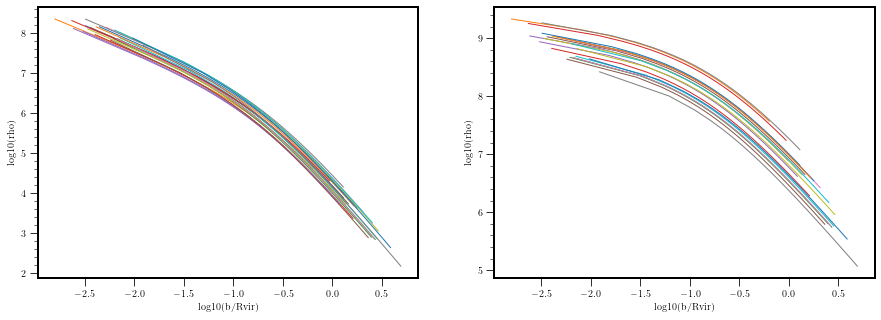

In [118]:
b = np.linspace(1, 400, 100)
rho = gid.nfw_rho(b, 2e6, 30)
rvir = G5_abs["Rvir_sigma2"]
mvir = G5_abs["Mvir_sigma2"]

plt.figure(figsize = (15,5))
plt.subplot(121)
for i, g in G5_abs.iterrows():
    r = g["Rvir_sigma2"]
    m = g["Mvir_sigma2"]
    z = g["center_z"]
    rho0, rs = gid.get_nfw_param(m, z)
    rho = gid.nfw_rho(b, rho0, rs)
    rho_column = []
    for bb in b:
        #print(bb)
        #print(bb, rho0, rs)
        I = integrate.quad(nfw_rho_2, -np.pi/2, np.pi/2, args = (bb, rho0, rs))
        #print(float(I[0]))
        rho_column.append(float(I[0]))
    #print(rho_column)
    plt.plot(np.log10(b/r), np.log10(rho))
    #plt.plot(np.log10(b/r), np.log10(rho_column))
plt.xlabel("log10(b/Rvir)")
plt.ylabel("log10(rho)")

plt.subplot(122)
for i, g in G5_abs.iterrows():
    r = g["Rvir_sigma2"]
    m = g["Mvir_sigma2"]
    z = g["center_z"]
    rho0, rs = gid.get_nfw_param(m, z)
    rho = gid.nfw_rho(b, rho0, rs)
    rho_column = []
    for bb in b:
        #print(bb)
        #print(bb, rho0, rs)
        I = integrate.quad(nfw_rho_2, -np.pi/2, np.pi/2, args = (bb, rho0, rs))
        #print(float(I[0]))
        rho_column.append(float(I[0]))
    #print(rho_column)
    #plt.plot(np.log10(b/r), np.log10(rho))
    plt.plot(np.log10(b/r), np.log10(rho_column))
plt.xlabel("log10(b/Rvir)")
plt.ylabel("log10(rho)")

# Combining the plots

2451039.5401724866 64.31044864616278
1572590.0608097657 145.4110942753745
2894301.729247351 26.930808460847228
2224505.205528957 43.25472662108799
1688218.9612210912 79.44813794348859
2561911.271956344 55.571757221790044
3605355.722796956 40.923707157891464
3120474.1947563635 73.75002207250166
2297738.179286191 57.489152580484664
3398491.724136341 24.6886419592296
3197565.9752582996 47.02097741386065
2968842.429470779 50.32047542424435
3140880.1781265447 24.943130770108155
2179566.5533671663 96.41373613341466
1894945.2551854965 60.32247666181128
2585240.611605945 27.74965915199512
3075677.718324164 25.602580275560012
4369363.723610986 13.147164901970294
4066347.01859533 27.089368546650906
3931186.6272744173 32.25081800843149
4406233.404088802 18.906049692960508


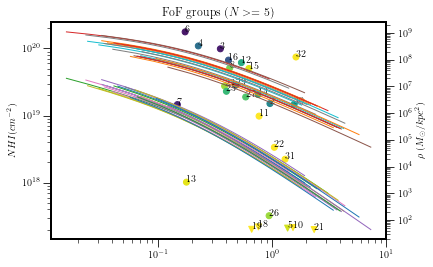

In [119]:
fig, ax1 = plt.subplots()

plt.title("FoF groups ($N >= 5$)")
#plt.errorbar(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none')
ax1.scatter(G5_abs["b_center_kpc_norm2"], G5_abs["NHI"], marker = "o", label = "groups N >= 5", \
            c = G5_abs["b_min_kpc"], vmin = 0, vmax = 100)
plt.scatter(G5_noabs["b_center_kpc_norm2"], G5_noabs["NHI_limit"],\
            marker = "v", label = "groups N >= 5", \
             c = G5_noabs["b_min_kpc"], vmin = 0, vmax = 100)
#plt.colorbar(label = "bmin kpc")

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["NHI"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_center_kpc_norm2"])
Y = np.array(G5_noabs["NHI_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))

plt.xscale("log")
plt.yscale("log")
plt.ylabel("$NHI (cm^{-2})$")
    
# -----------------------------------------------------------------------

ax2 = ax1.twinx()
b = np.linspace(10, 600, 100)
for i, g in G5_abs.iterrows():
    r = g["Rvir_sigma2"]
    m = g["Mvir_sigma2"]
    z = g["center_z"]
    rho0, rs = gid.get_nfw_param(m, z)
    rho = gid.nfw_rho(b, rho0, rs)
    print(rho0, rs)
    rho_column = []
    for bb in b:
        #print(bb)
        #print(bb, rho0, rs)
        I = integrate.quad(nfw_rho_2, -np.pi/2, np.pi/2, args = (bb, rho0, rs))
        #print(float(I[0]))
        rho_column.append(float(I[0]))
    #print(rho_column)
    plt.plot(b/r, rho)
    plt.plot(b/r, rho_column)
plt.xlabel("log10(b/Rvir)")
plt.ylabel("log10(rho)")
plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$\\rho$ $(M_{\odot}/kpc^2)$")
plt.xscale("log")
plt.yscale("log")

## Now with the equation from Bartelmann 1996:

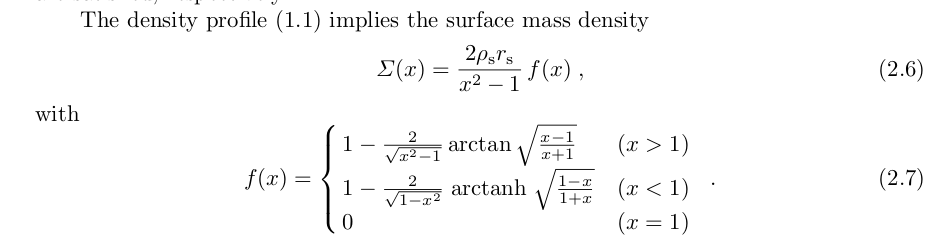

In [120]:
def calc_sigma_DM(r, rhos, rs):
    x = r/rs
    Sigma = 2* rhos*rs*ff(x)/(x**2-1)
    return Sigma

def ff(x):
    if x> 1: return (1-2*np.arctan(((x-1)/(x+1))**0.5)/((x**2-1)**0.5))
    elif x<1: return (1-2*np.arctanh(((1-x)/(x+1))**0.5)/((1-x**2)**0.5))
    elif x == 1: return 0
        

In [121]:
b = np.linspace(10, 600, 100)
mvir = 1e12
z = 1
rvir = gid.get_Rvir(mvir, z)
rho0, rs = gid.get_nfw_param(mvir, z)
rvir

156.28710893311342

In [122]:
print(np.arccos(0/rvir))

1.5707963267948966


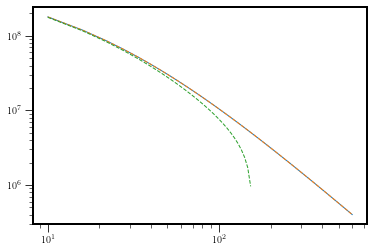

In [123]:
sig_dm = []
rho_column = []
rho_trunc = []
for bb in b:
    sig_dm.append(calc_sigma_DM(bb, rho0, rs))
    I = integrate.quad(nfw_rho_2, -np.pi/2, np.pi/2, args = (bb, rho0, rs))
    rho_column.append(float(I[0]))
    theta_lim = np.arccos(bb/rvir)
    I2 = integrate.quad(nfw_rho_2, -theta_lim, theta_lim, args = (bb, rho0, rs))
    rho_trunc.append(float(I2[0]))
sig_dm = np.array(sig_dm)
rho_column = np.array(rho_column)
rho_trunc = np.array(rho_trunc)

plt.loglog(b, sig_dm)
plt.loglog(b, rho_column, linestyle = "--")
plt.loglog(b, rho_trunc, linestyle = "--")

#### for a truncated NFW profile:

In [124]:
K= (1.66054e-27*u.kg/(u.cm**2)).to(u.kg/(u.kpc**2))
print(K)
K = K/const.M_sun
K

1.5810675746598502e+16 kg / kpc2


<Quantity 7.95141685e-15 1 / kpc2>

In [125]:
convert1 = ((const.M_sun/((1*u.kpc)**2)).to(u.kg/((u.cm)**2))).value
convert1

2.0883573729600368e-13

156.28710893311342 3346226.7715142868 28.545636311349668


(1e-10, 1e-06)

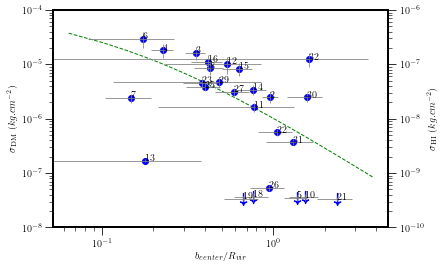

In [126]:

fig, ax1 = plt.subplots()
#plt.title("FoF groups ($N >= 5$)")
b = np.linspace(10, 600, 100)
mvir = 1e12
z = 1
rvir = gid.get_Rvir(mvir, z)
rho0, rs = gid.get_nfw_param(mvir, z)
print(rvir, rho0, rs)
rho = gid.nfw_rho(b, rho0, rs)
rho_column = []
for bb in b:
    I = integrate.quad(nfw_rho_2, -np.pi/2, np.pi/2, args = (bb, rho0, rs))
    rho_column.append(float(I[0]))
#plt.plot(np.log10(b/r), np.log10(rho))
#plt.plot(np.log10(b/r), np.log10(rho_column))
#plt.plot(b/rvir, rho, linestyle = "--", color = "gray", linewidth = 1, label = "rho column")
rho_column = np.array(rho_column)

convert1 = ((const.M_sun/((1*u.kpc)**2)).to(u.kg/((u.cm)**2))).value

plt.plot(b/rvir, rho_column*convert1, linestyle = "--", color = "green", linewidth = 1)
#plt.plot(b/rvir, sig_dm*convert1, linestyle = "-", color = "red", linewidth = 1)
plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$\sigma_{\mathrm{DM}}$ $(kg.cm^{-2})$")
#plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-8, 1e-4))

    
# -----------------------------------------------------------------------

u_to_kg = 1.67355755e-27

ax2 = ax1.twinx()
NHI_abs = G5_abs["NHI"]*u_to_kg
NHI_abs_sigma = G5_abs["sigma_NHI"]*u_to_kg
NHI_noabs = G5_noabs["NHI_limit"]*u_to_kg
NHI_noabs_sigma = G5_noabs["sigma_NHI"]*u_to_kg

ax2.errorbar(G5_abs["b_center_kpc_norm2"], NHI_abs, xerr = G5_abs["b_center_kpc_norm2_err"], yerr =NHI_abs_sigma,\
            fmt = " ", color = "gray", linewidth = 0.8)
ax2.scatter(G5_abs["b_center_kpc_norm2"], NHI_abs, marker = "o", label = "groups N >= 5", \
            c = "blue")
#plt.colorbar(label = "log($M/M_{\odot}$)")

ax2.errorbar(G5_noabs["b_center_kpc_norm2"], NHI_noabs, xerr = G5_noabs["b_center_kpc_norm2_err"], yerr = NHI_noabs_sigma,\
            fmt = " ", color = "gray", linewidth = 0.8)
ax2.scatter(G5_noabs["b_center_kpc_norm2"], NHI_noabs,\
            marker = "$\downarrow$", s = 150, label = "groups N >= 5", \
             c = "blue")
#plt.colorbar(label = "bmin kpc")

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["NHI"]*u_to_kg)
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_center_kpc_norm2"])
Y = np.array(G5_noabs["NHI_limit"])*u_to_kg
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.ylabel("$\sigma_{\mathrm{HI}}$ $(kg.cm^{-2})$")

plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-10, 1e-6))

In [127]:
G5_abs["NHI"], NHI_abs

(1     1.508940e+19
 2     9.870159e+19
 3     1.089716e+20
 5     1.764128e+20
 6     1.457710e+19
 7     5.111697e+19
 10    9.805288e+18
 11    6.141676e+19
 12    1.018386e+18
 13    2.057472e+19
 14    5.022818e+19
 15    6.705365e+19
 21    3.363939e+18
 22    2.758262e+19
 24    2.297952e+19
 25    3.220570e+17
 26    1.890464e+19
 28    2.832403e+19
 29    1.472975e+19
 30    2.234675e+18
 31    7.458150e+19
 Name: NHI, dtype: float64,
 1     2.525297e-08
 2     1.651828e-07
 3     1.823702e-07
 5     2.952370e-07
 6     2.439561e-08
 7     8.554719e-08
 10    1.640971e-08
 11    1.027845e-07
 12    1.704328e-09
 13    3.443299e-08
 14    8.405976e-08
 15    1.122181e-07
 21    5.629746e-09
 22    4.616110e-08
 24    3.845755e-08
 25    5.389810e-10
 26    3.163801e-08
 28    4.740189e-08
 29    2.465109e-08
 30    3.739857e-09
 31    1.248164e-07
 Name: NHI, dtype: float64)

In [128]:
x1 = np.array(G5_abs["b_center_kpc_norm2"])
x2 = np.array(G5_noabs["b_center_kpc_norm2"])
y1 = np.array(np.log(NHI_abs))
y2 = np.array(np.log(NHI_noabs))
sig_x1 = np.array(G5_abs["b_center_kpc_norm2_err"])
sig_x2 = np.array(G5_noabs["b_center_kpc_norm2_err"])
sig_y1 = np.array(NHI_abs_sigma/NHI_abs)
sig_y2 = np.array(NHI_noabs_sigma/NHI_noabs)

In [129]:
G5_noabs["sigma_NHI"]

4     2.975192e+16
9     3.373966e+16
17    3.852419e+16
18    2.162482e+16
20    1.994972e+16
Name: sigma_NHI, dtype: float64

In [130]:
def logL_Hogg_total(param):
    print("param = ", param[0], param[1])
    theta = np.arctan(param[1])
    print("theta = ", theta)
    
    LL1i = []
    LL2i = []
    
    N1 = len(x1)
    LL = 0
    
    for i in range(N1):
        xi = x1[i]
        yi = y1[i]
        sig_xi = sig_x1[i]
        sig_yi = sig_y1[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
        LL += -Deltai_2/Sigmai_2/2
        LL1i.append(-Deltai_2/Sigmai_2/2)
        
    N2 = len(x2)
    for i in range(N2):
        xi = x2[i]
        yi = y2[i]
        sig_xi = sig_x2[i]
        sig_yi = sig_y2[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
        X = -(Deltai_2/Sigmai_2/2)**0.5
        I = 0.5*(1 + math.erf(X))
        LL += np.log(I) 
        LL2i.append(np.log(I))
        
        
    print("LL = ", LL)
    print("LL1 terms: ", LL1i)
    print("LL2 terms: ", LL2i)
    
    X = np.linspace(0.05, 1.5, 50)
    plt.figure()
    plt.scatter(x1,y1)
    plt.scatter(x2,y2)
    plt.plot(X, model(param, X), linewidth = 1.5, c = "green")  
        
    return -LL

In [131]:
NHI_noabs_sigma

4     4.979154e-11
9     5.646527e-11
17    6.447245e-11
18    3.619039e-11
20    3.338700e-11
Name: sigma_NHI, dtype: float64

In [132]:
print(y1)

[-17.49432197 -15.61621314 -15.51722715 -15.03548751 -17.52886251
 -16.27419764 -17.92539242 -16.09063149 -20.19009499 -17.18425086
 -16.29173791 -16.00282119 -18.9952016  -16.89112835 -17.07371073
 -21.34134087 -17.26890665 -16.86460365 -17.51844482 -19.40421841
 -15.89642179]


N =  0
param =  -15.0 -4.0
theta =  -1.3258176636680326
LL =  -113.57908911433005
LL1 terms:  [-4.373173584707685, -2.731539327480321, -0.7973359893759407, -0.9546700806313888, -28.215970977267865, -0.5428890553071212, -0.002784993988857312, -0.3525879567711751, -15.096351335144183, -0.8418319394681163, -2.206928118325802, -1.0496870187704255, -0.025101073347925613, -0.3520879435059812, -0.7080387895327672, -4.309319967314481, -0.013551736654403873, -0.0009856382319034366, -3.417668210999625, -0.13426433289090856, -0.2525773928995463]
LL2 terms:  [-2.6289556988934013, -1.177160200371618, -15.720656185745149, -25.496648860425534, -2.176322706277912]
param =  -14.999999985098839 -4.0
theta =  -1.3258176636680326
LL =  -113.57909596755667
LL1 terms:  [-4.373173488774653, -2.731539225733956, -0.7973359285397049, -0.9546700375224992, -28.21597141209634, -0.5428890181950582, -0.002784993494171072, -0.3525879469982436, -15.096351435668572, -0.8418319099739694, -2.206928064658692, -1.049686971

param =  -14.169603489139345 -6.419851604785969
theta =  -1.4162712644775357
LL =  -76.25346527596453
LL1 terms:  [-8.739913393433023, -1.9579606521097368, -0.048347688478183465, -0.07218829462365935, -24.782649409976923, -0.6061091268834374, -0.056321954275007566, -0.2999854954981696, -6.968066316590073, -1.6573464770719404, -2.4209945424745754, -0.903254423494896, -0.7856757114646142, -0.08226377792841719, -0.15385076413656548, -0.3094074106353517, -0.3092099468957737, -0.014600103683402752, -4.289958759953398, -0.7677625509007429, -0.23689478915704115]
LL2 terms:  [-1.6937920702250022, -2.1086899537412847, -4.6732776199242805, -8.118556597711464, -4.196387444697572]
param =  -14.169603474238183 -6.419851604785969
theta =  -1.4162712644775357
LL =  -76.25346534174292
LL1 terms:  [-8.739913302328258, -1.957960581509, -0.04834767530758382, -0.07218828602947697, -24.78264971716626, -0.6061090986656522, -0.056321952886236634, -0.29998548974904327, -6.968066359198915, -1.6573464504626152,

param =  -13.368880950371562 -8.109822195212834
theta =  -1.4481083702678528
LL =  -73.10575715371648
LL1 terms:  [-9.468457899822974, -0.8461169464375075, -0.31335839498028595, -0.05186523037832995, -26.330075674437378, -0.3178352433064157, -0.07110768161229965, -0.2191227350663408, -5.309509254577899, -1.6730167836325054, -2.0354867405223698, -0.4889510491301826, -1.1201205956260067, -0.1401270927621701, -0.18618560099197087, -0.013878357805053643, -0.32477017584070594, -0.009868509544608281, -4.382537111438801, -1.0069696570909374, -0.2223041722518933]
LL2 terms:  [-2.8926509331532975, -3.0188713178601523, -2.754521398946307, -4.969759502989454, -4.938289093510632]
param =  -13.18713271331376 -8.788460071734814
theta =  -1.4574980365918044
LL =  -72.17259291175384
LL1 terms:  [-10.362638485655504, -0.9093908659412668, -0.3433286677257072, -0.07044791869126063, -24.41510573084393, -0.39354833201867157, -0.08721911273586368, -0.23106901246278705, -4.6243414546203345, -1.86686461427859

param =  -13.16857123252642 -9.29958172214126
theta =  -1.4636762223653184
LL =  -71.69887292922904
LL1 terms:  [-11.555331401551118, -1.288008094633219, -0.1626369391462485, -0.03888474684942823, -21.403392891164984, -0.6004938812335465, -0.10903839539918173, -0.26827855162269393, -4.020528417526339, -2.165343271341717, -2.4618352083863506, -0.7529833899209198, -1.5804997381500903, -0.01291196850870218, -0.023105242026970462, -0.05009411371196406, -0.6087333335111947, -0.026973455707184325, -4.7579590754723755, -1.288271947114658, -0.2285514682211274]
LL2 terms:  [-4.061886533214253, -3.837148560382299, -1.6869302666333315, -3.1700409561130183, -5.539011081686106]
param =  -13.188334129228815 -9.248214635619217
theta =  -1.463085826878327
LL =  -71.6978620995782
LL1 terms:  [-11.527948130808229, -1.3029828844265943, -0.15268193551573855, -0.03593618953869122, -21.426361848786293, -0.603356035151994, -0.10845120945241243, -0.26916025227575585, -4.0492354123751255, -2.161397430173562, -

param =  -15.709630057538725 -4.7186968633837125
theta =  -1.3619631493111313
LL =  -33.68921871914834
LL1 terms:  [-1.0373889335800013, -0.44092800187991393, -0.22796514145445923, -0.3037280210937385, -0.17954191787640353, -0.29207256167499174, -0.09857178877973251, -0.41961625869986807, -1.5314574036115916, -0.5570601540452452, -0.7417112154744006, -0.3841812596249373, -0.30182713783508397, -0.05632538064297742, -0.03797847321483814, -0.15205466969456072, -0.19654571927492814, -0.0979565309993557, -2.5052960547583103, -0.44248452135368144, -0.3112330682962147]
LL2 terms:  [-1.098739650977545, -1.604745534566496, -6.219507612859889, -10.72553214659702, -3.7247695602821618]
param =  -15.709630042637563 -4.7186968633837125
theta =  -1.3619631493111313
LL =  -33.68921873590871
LL1 terms:  [-1.0373889223801727, -0.44092799443136377, -0.2279651360767372, -0.30372801503731295, -0.17954192266527128, -0.29207255568374896, -0.09857178672997059, -0.41961625294750843, -1.531457416158645, -0.5570

param =  -13.405467490400587 -7.2132467536593365
theta =  -1.4330405470050336
LL =  -30.084807546160164
LL1 terms:  [-1.0280623232187749, -0.01638163529320402, -0.03187969223235212, -0.01801776791529396, -1.315712242776817, -0.006085008391707653, -0.028323625118425698, -0.08810172510547093, -2.7219334892535056, -0.3053647044180016, -0.31503228570396935, -0.02198531495366572, -0.3143804242434422, -0.0643357641108657, -0.07948607303322058, -0.10466015651998428, -0.017929467196127064, -2.2942985899039624e-05, -2.589739252305965, -0.5074678787139336, -0.20759902653311724]
LL2 terms:  [-1.8642041920645933, -2.243800199699086, -4.3358548772382495, -7.54216878056375, -4.316278696570743]
param =  -13.37906164542788 -7.429417444133165
theta =  -1.4370004056682626
LL =  -29.870923941540813
LL1 terms:  [-1.1536247646581115, -0.021472947930810175, -0.028880322774546184, -0.016850763707863953, -1.308418405716005, -0.010335025433985352, -0.034620504763911916, -0.09818715946701936, -2.647503898775098

param =  -13.706389715274028 -7.2835736414565835
theta =  -1.4343541292520445
LL =  -29.717441874133574
LL1 terms:  [-1.3068696899475878, -0.06219494267799783, -0.003521512843426864, -0.0005004907090346081, -1.0602002747638093, -0.03912667350389946, -0.049735507229582296, -0.14221282183384232, -2.402065734914221, -0.4441135278996459, -0.4585298306336462, -0.07112072307931801, -0.4388944703896877, -0.01829143315380185, -0.02664653095346695, -0.04620715226059374, -0.0621349999140164, -0.006032675881315033, -2.8562573376927545, -0.6218198378747757, -0.22236096823568444]
LL2 terms:  [-2.26603082360171, -2.5557608451207536, -3.6069583769774183, -6.376838924904161, -4.573015767137426]
param =  -13.70638973017519 -7.283573626555422
theta =  -1.4343541289763546
LL =  -29.717441874141613
LL1 terms:  [-1.3068696911156452, -0.06219494447583403, -0.0035215123294882714, -0.0005004905127610097, -1.0602002650740727, -0.03912667474041675, -0.04973550763608645, -0.14221282342236027, -2.40206572741902, 

param =  -12.814562066516437 -7.614005050767544
theta =  -1.4402068430336503
LL =  -35.79940075260368
LL1 terms:  [-1.4843780294780973, -0.002869603192787052, -0.25299670462451385, -0.17451554855701087, -3.403022983787377, -0.00957243311816835, -0.015122031022292155, -0.04872756178315671, -4.3796451534222465, -0.3114023606241767, -0.31150693646461747, -2.6852519754403175e-05, -0.33235505150515493, -0.2913724244744979, -0.3285782463748402, -0.19502349206046485, -0.00030481812615994463, -0.007394385835383666, -2.8759577276377195, -0.5205977312356749, -0.1905305583410502]
LL2 terms:  [-1.7480004688497202, -2.1501735883885473, -4.594000202813189, -7.932350436106056, -4.238975422261023]
param =  -12.814562051615276 -7.614005050767544
theta =  -1.4402068430336503
LL =  -35.79940082676322
LL1 terms:  [-1.4843780128109896, -0.002869604001747945, -0.2529967123607473, -0.1745155543546408, -3.403023012102742, -0.009572434514212297, -0.015122030442299846, -0.04872756006785116, -4.379645175120204, 

param =  -13.898011746462112 -6.680688478899102
theta =  -1.4222142942330394
LL =  -34.41670715477072
LL1 terms:  [-1.8009079764162914, -0.10927282936295195, -0.002847795474035231, -0.0001320809517821796, -1.8711925478291984, -0.055005635914557094, -0.041099579111791816, -0.16666451310511182, -3.6305493569405947, -0.5560907375324815, -0.6424197881652266, -0.10819173122014736, -0.43532582197702857, -0.04076276516882752, -0.059453732494806025, -0.1630921815855212, -0.06406481343677617, -0.004270523207830697, -3.168857287839982, -0.5938753107124738, -0.224285936386779]
LL2 terms:  [-1.7320973036241725, -2.1391311208092136, -4.598312784558684, -7.984548884275447, -4.22425411666901]
param =  -13.898011761363273 -6.6806884639979405
theta =  -1.4222142939064857
LL =  -34.41670715932399
LL1 terms:  [-1.800907978742715, -0.1092728326385515, -0.0028477948373480575, -0.00013208108687354542, -1.8711925302285262, -0.05500563790313069, -0.0410995795184533, -0.16666451522049994, -3.6305493478458226, 

param =  -13.679028227245222 -7.202713917053095
theta =  -1.432841645185384
LL =  -34.18944232492697
LL1 terms:  [-2.1095190145071316, -0.09721272620337154, -0.011069891040178028, -0.0024032261872907077, -2.0610823715947237, -0.05474856001103532, -0.04851661309094425, -0.1634465954118558, -3.517821958964151, -0.6332256058669694, -0.6899001716401647, -0.10524065823366562, -0.5441958193099, -0.04315954260256987, -0.060185111254248566, -0.08504122878773407, -0.08140823087327953, -0.004829681090699408, -3.3340892896358465, -0.6874030282558796, -0.2216736633354898]
LL2 terms:  [-2.136478446948976, -2.456711481420233, -3.8223336380392494, -6.725289835173078, -4.492455935448307]
param =  -13.679028242146384 -7.202713902151934
theta =  -1.4328416449035872
LL =  -34.18944232492736
LL1 terms:  [-2.109519017241725, -0.09721272928005346, -0.011069889788351646, -0.0024032256209367154, -2.0610823532473037, -0.054748561975264, -0.04851661351972546, -0.16344659740351805, -3.5178219505177175, -0.633225

param =  -15.709479390976304 -4.71884559801107
theta =  -1.3619695418797297
LL =  -40.51481191882643
LL1 terms:  [-2.001977322990077, -0.8842307030893934, -0.460931660416784, -0.5853796192529227, -0.36574043110901294, -0.5723093965306687, -0.11872757509941365, -0.6118299949769311, -2.5941591375883855, -1.0031420623857588, -1.374833311459156, -0.744636022102878, -0.4844606897089689, -0.11020397449314971, -0.07450646063934122, -0.25264216199089584, -0.3653631076555117, -0.1351441788040241, -3.4892481386976186, -0.594864170304414, -0.31743573302411987]
LL2 terms:  [-1.0987832000857496, -1.604784636415302, -6.219372739990425, -10.725296724411846, -3.7248087656036812]
param =  -15.709479376075143 -4.71884559801107
theta =  -1.3619695418797297
LL =  -40.514811873373205
LL1 terms:  [-2.0019773013763293, -0.8842306881513481, -0.4609316495423509, -0.5853796075793074, -0.3657404408631754, -0.5723093847902643, -0.11872757263045865, -0.6118299865893162, -2.5941591588413058, -1.0031420481868392, -1

param =  -13.833392512680003 -6.653168316497476
theta =  -1.4216087601391842
LL =  -35.01309583378915
LL1 terms:  [-1.774564457086952, -0.09068348536891267, -0.00860906012648841, -0.0004918917919986844, -2.090597977587284, -0.04102582437962354, -0.03563353787535741, -0.15210802303985024, -3.861433949027383, -0.5252323234916391, -0.6126235163260321, -0.08998071950627251, -0.406299399998964, -0.05989899853098029, -0.08292928272374525, -0.1970469325984603, -0.04945510002716469, -0.002119271141848435, -3.1346230468484615, -0.568054506787062, -0.22072411450419438]
LL2 terms:  [-1.6339529767638565, -2.0593962488212356, -4.821591495458263, -8.338711474476403, -4.1553082195007205]
param =  -13.833392527581164 -6.653168301596315
theta =  -1.4216087598099836
LL =  -35.013095835382806
LL1 terms:  [-1.7745644594784031, -0.09068348843851631, -0.008609058986753827, -0.0004918915251232549, -2.09059795845901, -0.04102582613994503, -0.03563353824660659, -0.15210802506594315, -3.86143393987761, -0.52523

param =  -13.681020397365364 -7.191560364826303
theta =  -1.4326303986756803
LL =  -34.65787618525276
LL1 terms:  [-2.2006700947878675, -0.10224340233232793, -0.011801619928325582, -0.002521258498855201, -2.1852149887149404, -0.05698328094303082, -0.048452626469881244, -0.16553190687642894, -3.6234690668458573, -0.6528125028681331, -0.7155228850616117, -0.10977094605128176, -0.5530592270260571, -0.04588418361894904, -0.0639119283449205, -0.08923149505682482, -0.08367399084530426, -0.004787749240963173, -3.3712628492755825, -0.6919288783181032, -0.22171620154936109]
LL2 terms:  [-2.1250084684675836, -2.4478902946185817, -3.842044503247178, -6.7572780251844575, -4.485203811080352]
param =  -13.681020412266525 -7.191560349925142
theta =  -1.4326303983930253
LL =  -34.657876185288295
LL1 terms:  [-2.2006700977415172, -0.10224340557997123, -0.0118016185973721, -0.0025212579044772247, -2.185214969289551, -0.05698328300090245, -0.048452626900646126, -0.1655319089059548, -3.623469058381145, -0

param =  -15.70947599622965 -4.718848933803143
theta =  -1.3619696852466265
LL =  -40.58998092876865
LL1 terms:  [-2.013594356555125, -0.8897804496744113, -0.46387224929155585, -0.5887662511310175, -0.3681100298837026, -0.5757362777333404, -0.11887821553438163, -0.6135730715017349, -2.6053782707931656, -1.008150668916466, -1.3821529109381863, -0.7489955741594885, -0.48628629846076227, -0.11086163642292718, -0.07495350312140174, -0.25368341397101474, -0.3673202718082004, -0.13546292035773536, -3.497771283647791, -0.5961378772411374, -0.3174747971499618]
LL2 terms:  [-1.0987841599920676, -1.6047854981371972, -6.219369774335663, -10.725291537701535, -3.7248096303086746]
param =  -15.70947601113081 -4.7188489189019815
theta =  -1.3619696846061995
LL =  -40.589981019598966
LL1 terms:  [-2.0135943588777145, -0.8897804595463478, -0.46387225779389235, -0.5887662611872585, -0.36811002158763495, -0.5757362847800801, -0.11887821670227333, -0.6135730774835785, -2.605378259217767, -1.00815067391881

param =  -13.828558728759768 -6.6265934675359075
theta =  -1.4210193585426651
LL =  -35.12512816410125
LL1 terms:  [-1.7474441668264764, -0.08679554668509841, -0.009782094268194869, -0.0007233611758874439, -2.1183339264457786, -0.03805410289970862, -0.03420375827293766, -0.1489044576037655, -3.9046080848689484, -0.5135285573255068, -0.6015954798793837, -0.08589002154366679, -0.3949116756734357, -0.0640651838362745, -0.08802470151321984, -0.20851032599122368, -0.04574491591337046, -0.0017360966073241917, -3.1154951436743725, -0.5580716639154739, -0.22006098000718508]
LL2 terms:  [-1.5977869048366722, -2.0297680287587414, -4.906958814929464, -8.474798687032205, -4.129331483616931]
param =  -13.82855874366093 -6.626593452634746
theta =  -1.4210193582108774
LL =  -35.125128165311104
LL1 terms:  [-1.7474441691939426, -0.08679554969750573, -0.00978209304941246, -0.0007233608512737652, -2.11833390712931, -0.03805410459980454, -0.0342037586352416, -0.1489044596107651, -3.904608075682695, -0.51

param =  -13.694842860583101 -7.161745220997848
theta =  -1.4320625358321957
LL =  -34.70902858156553
LL1 terms:  [-2.194944982664821, -0.10401959709313514, -0.011071439501679136, -0.0021344756299090735, -2.1851160889974217, -0.057627506981259874, -0.048166652032141405, -0.16630311166611392, -3.639374766953324, -0.6517012426629757, -0.7168986381806229, -0.11096296927395506, -0.5487105841321782, -0.045711301752066724, -0.06388861246570485, -0.0929962482944197, -0.08331663189011083, -0.004807031700571151, -3.3682275473505547, -0.6880044541939906, -0.22193010155192294]
LL2 terms:  [-2.1035484907579787, -2.4313780530437565, -3.8790091827113145, -6.817625832108238, -4.471553037975369]
param =  -13.694842875484262 -7.161745206096687
theta =  -1.4320625355472274
LL =  -34.70902858188653
LL1 terms:  [-2.1949449856206624, -0.10401960037985032, -0.011071438208299115, -0.0021344750810147256, -2.1851160695066163, -0.0576275090579502, -0.048166652462834615, -0.16630311370933767, -3.639374758453492,

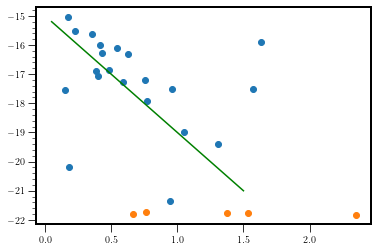

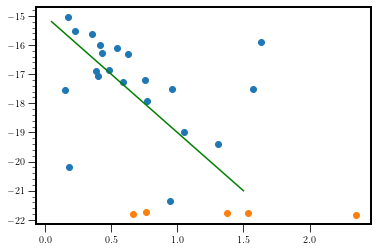

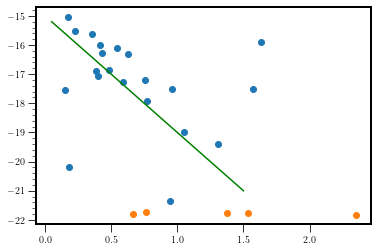

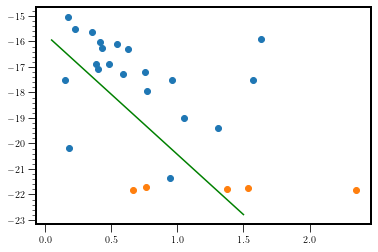

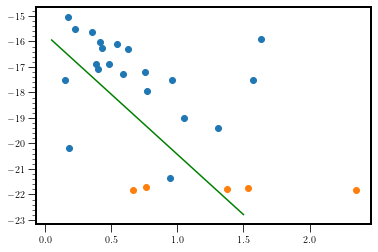

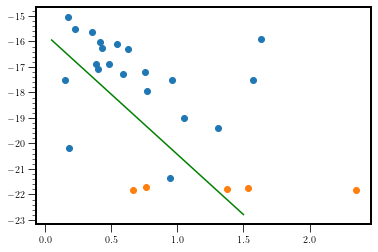

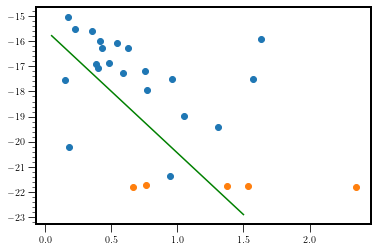

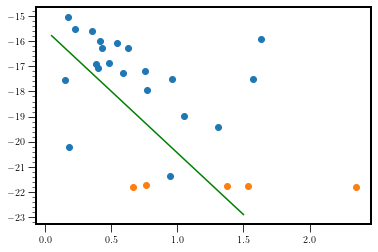

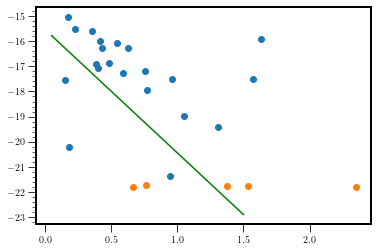

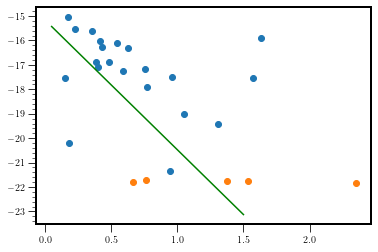

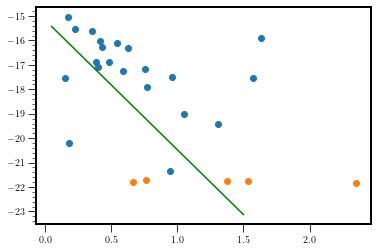

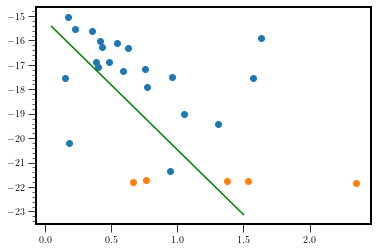

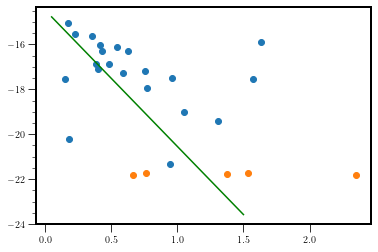

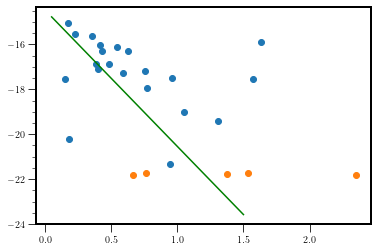

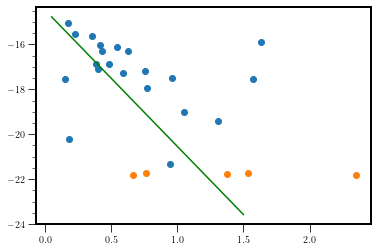

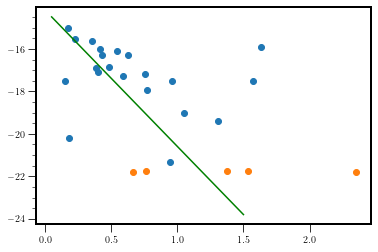

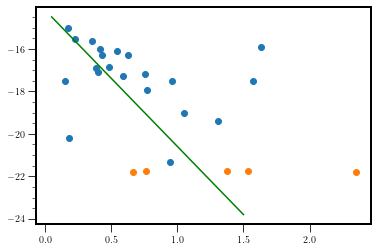

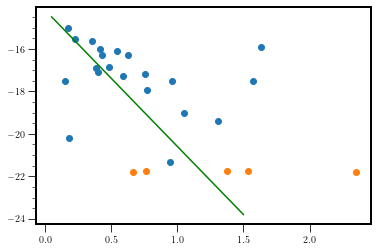

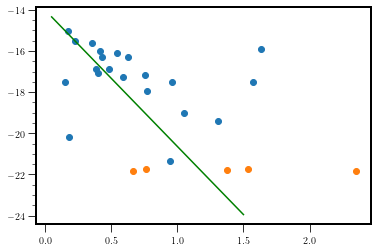

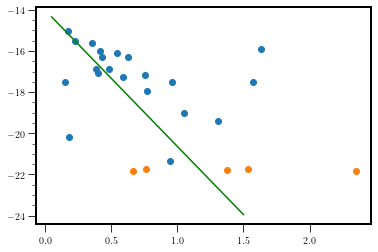

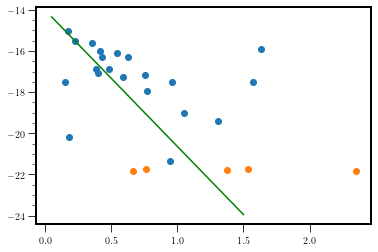

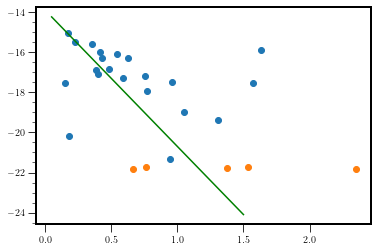

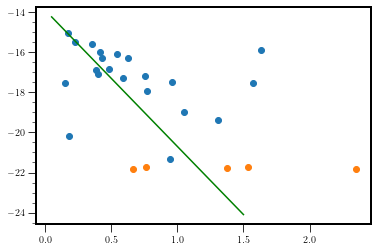

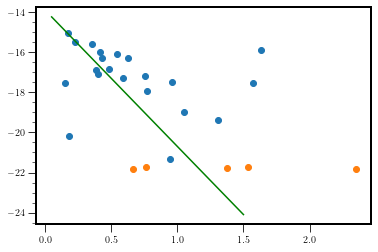

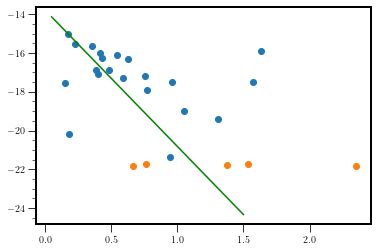

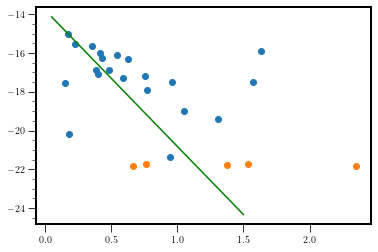

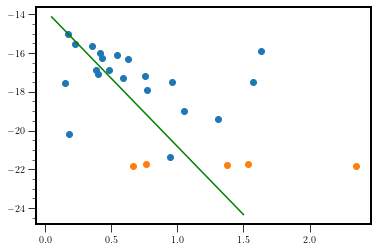

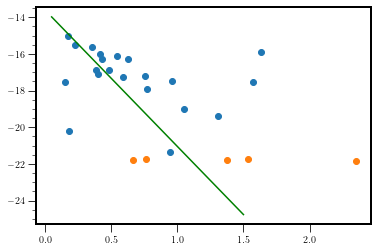

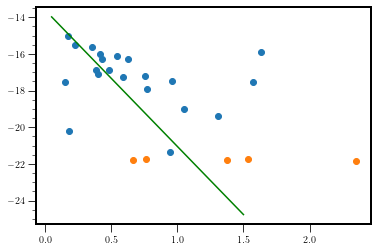

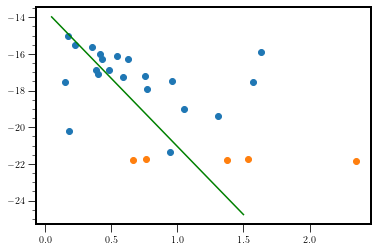

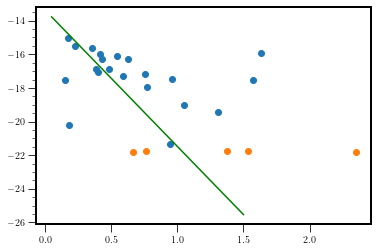

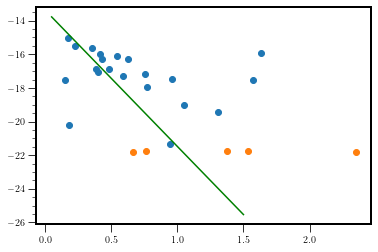

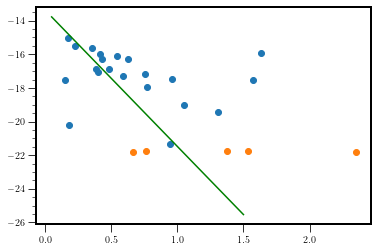

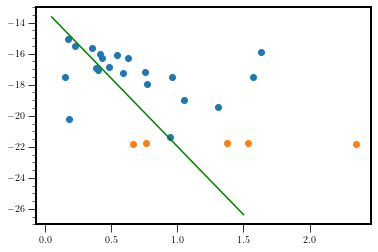

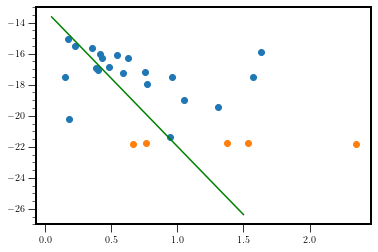

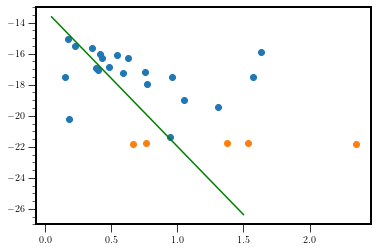

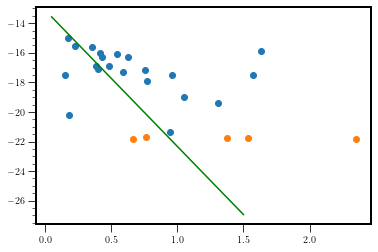

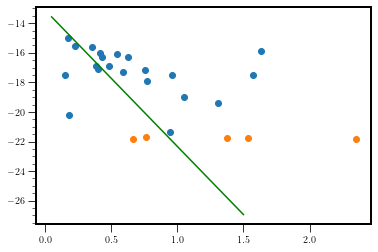

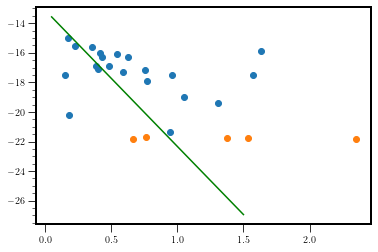

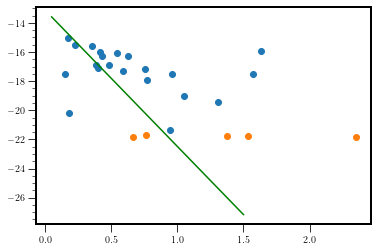

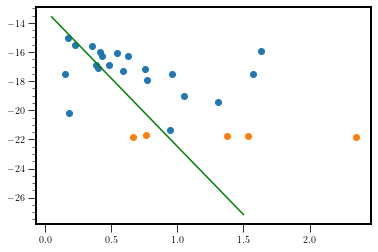

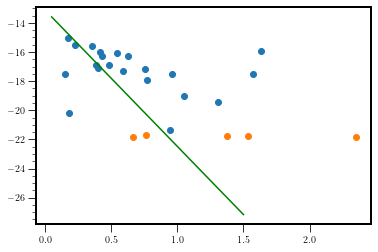

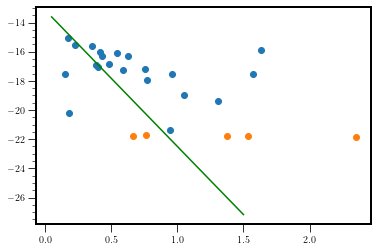

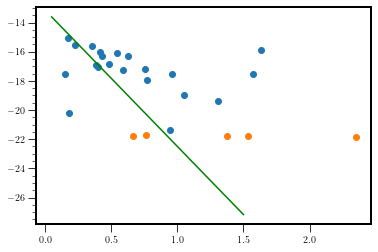

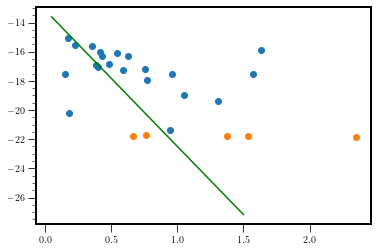

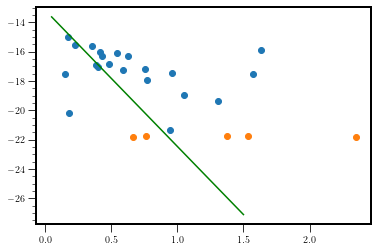

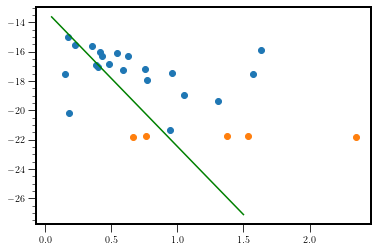

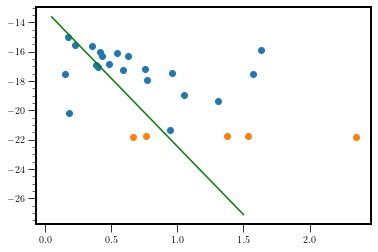

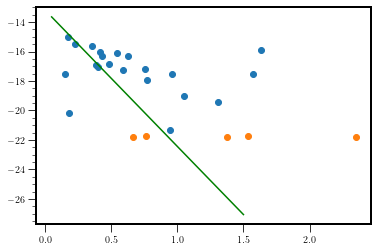

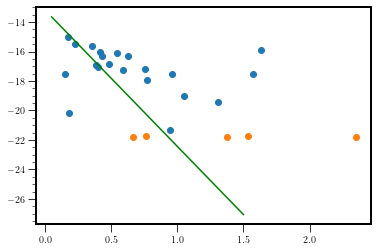

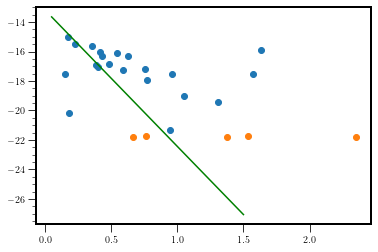

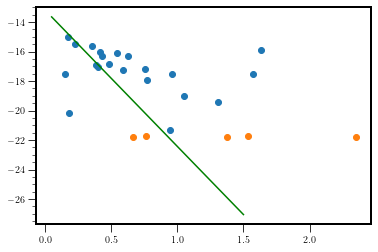

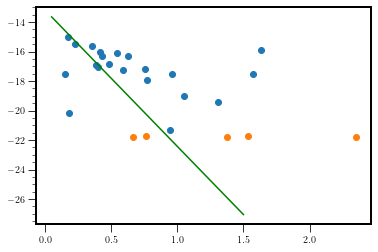

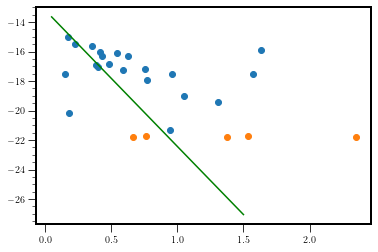

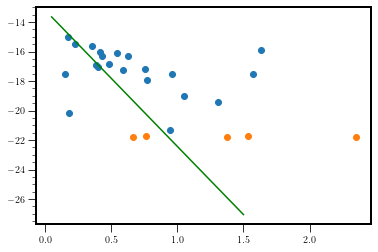

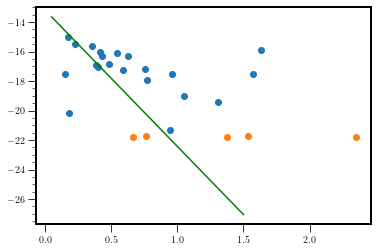

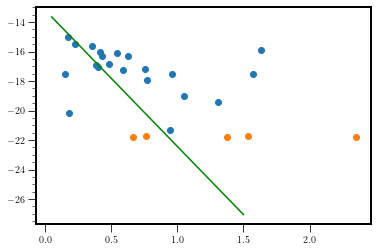

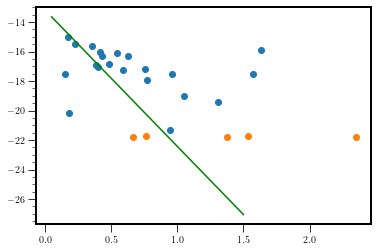

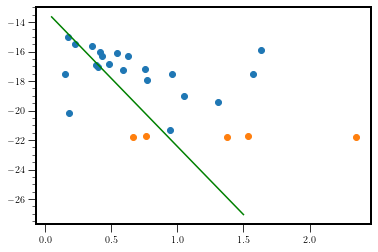

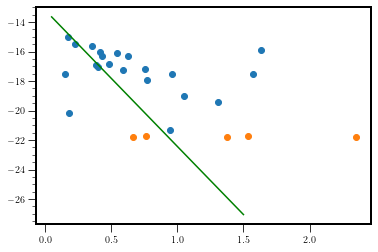

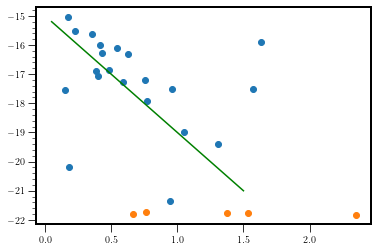

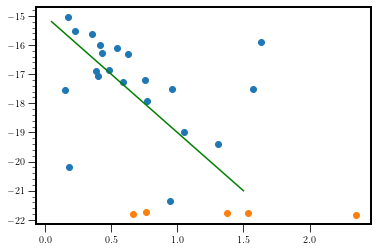

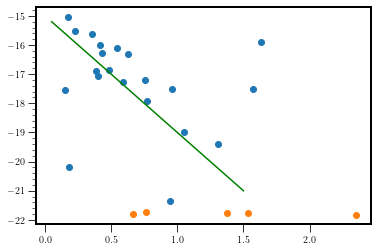

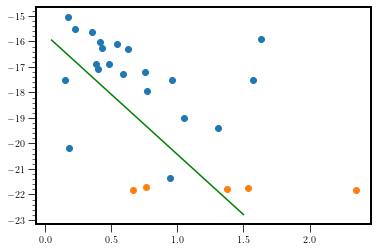

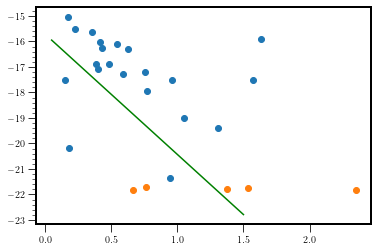

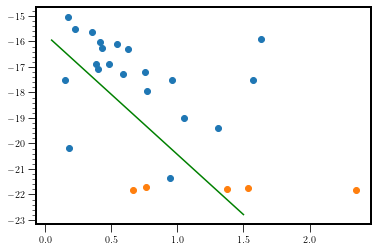

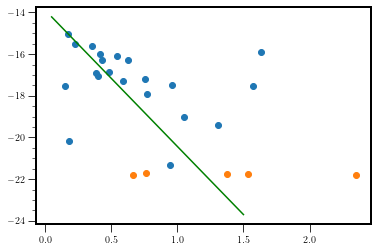

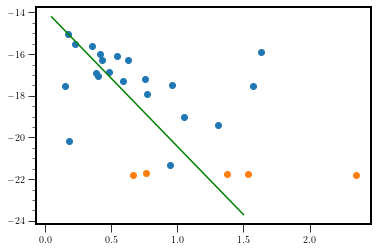

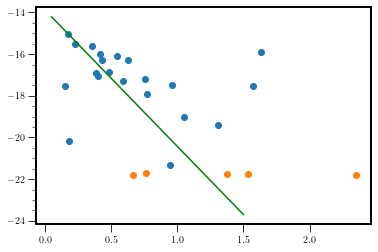

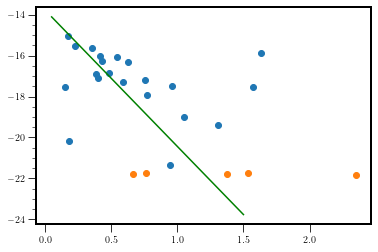

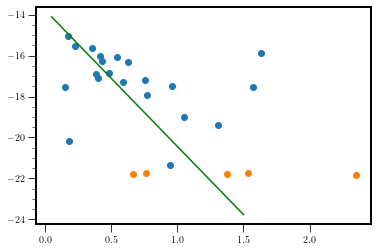

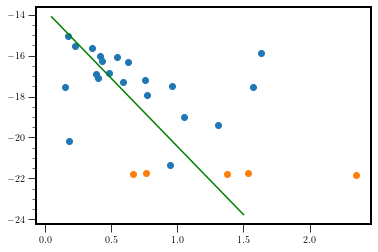

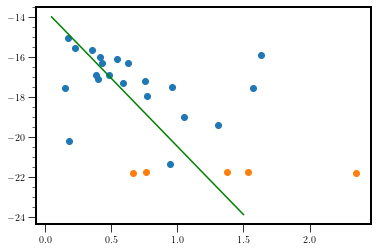

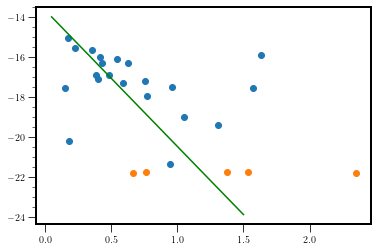

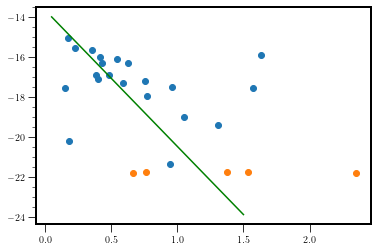

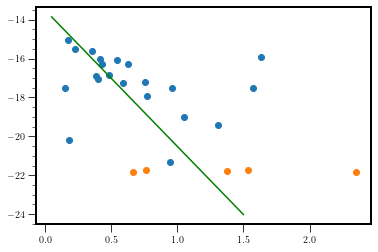

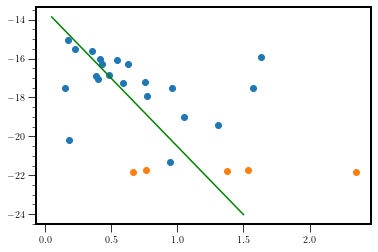

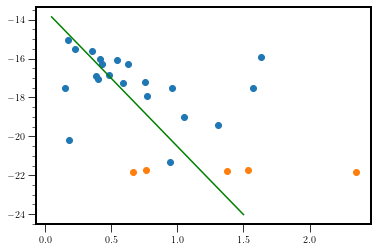

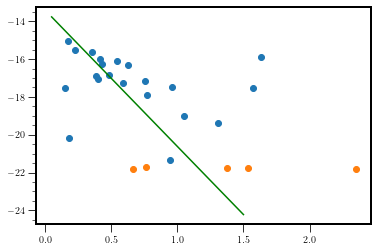

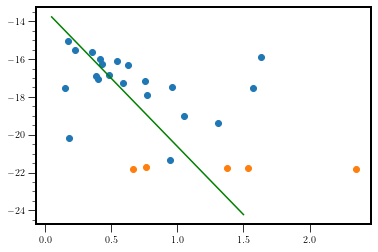

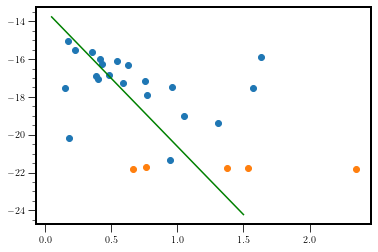

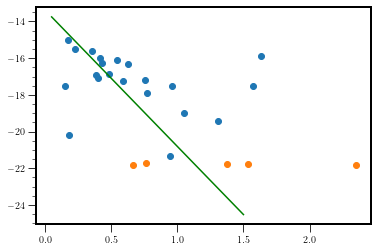

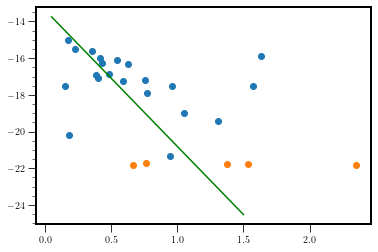

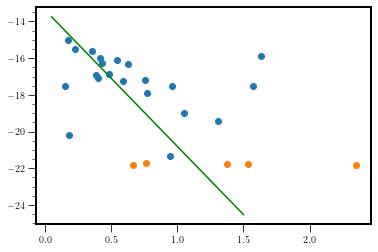

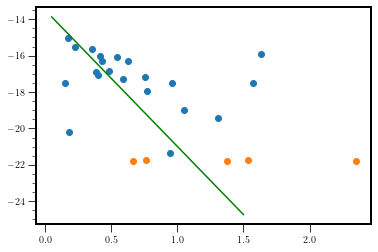

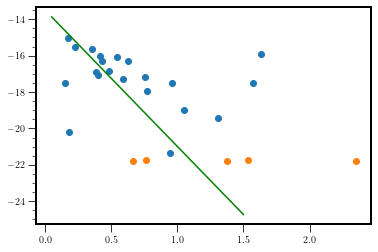

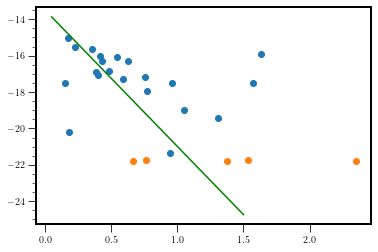

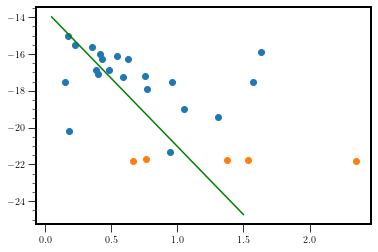

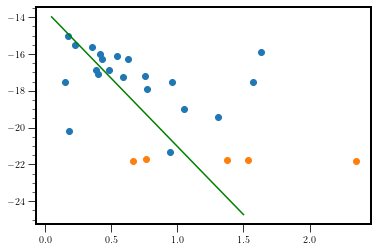

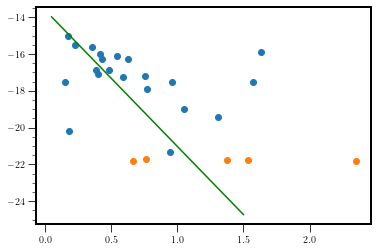

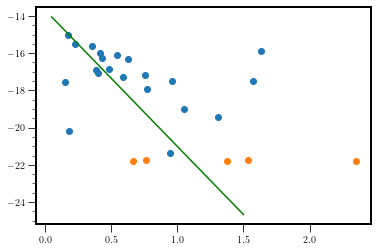

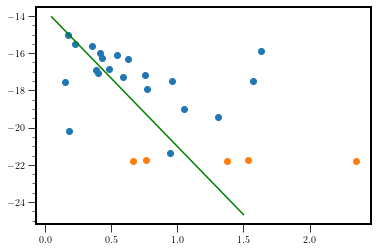

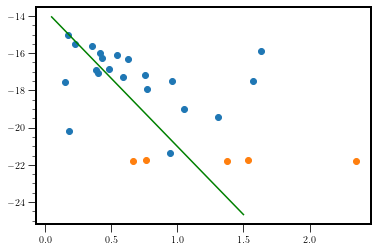

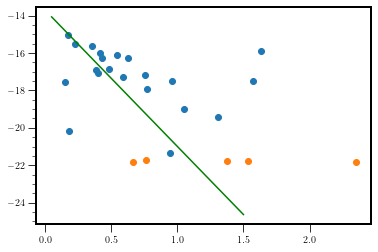

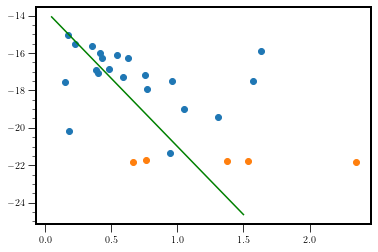

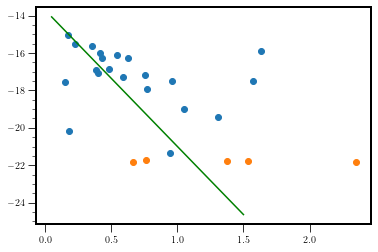

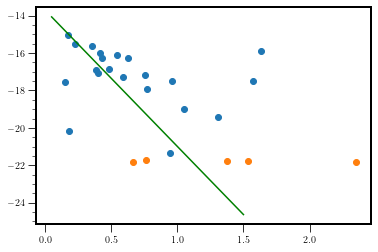

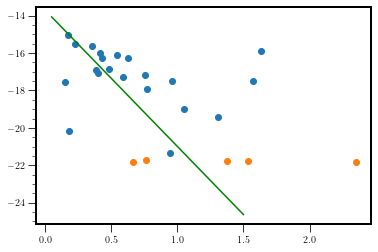

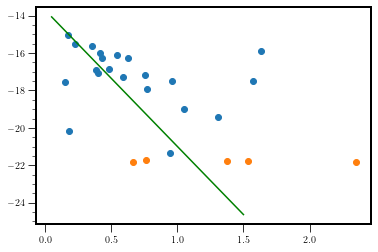

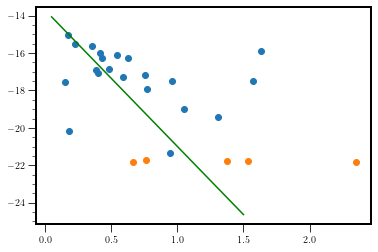

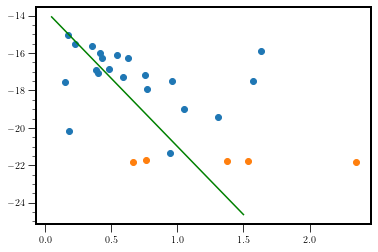

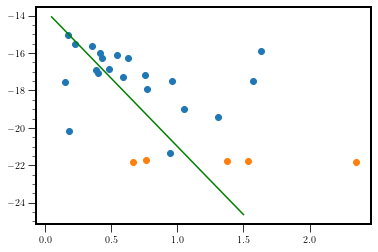

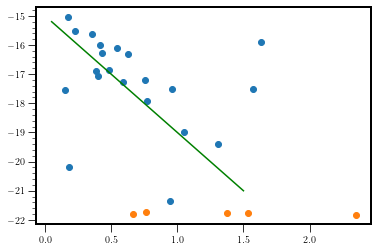

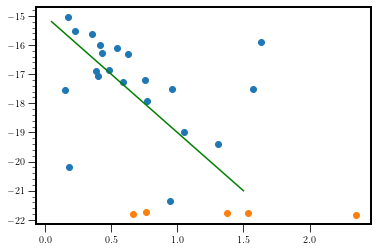

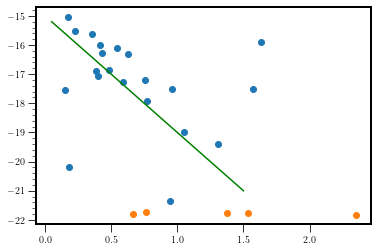

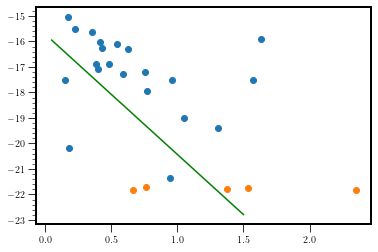

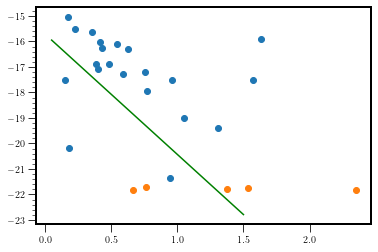

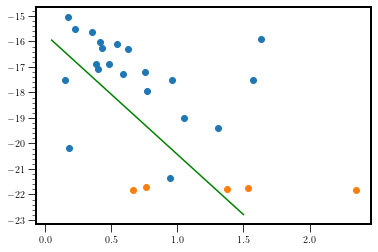

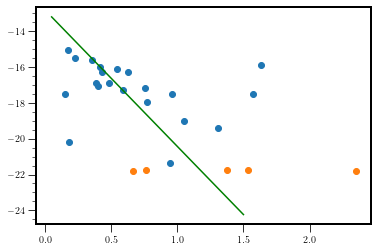

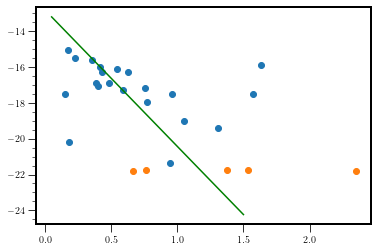

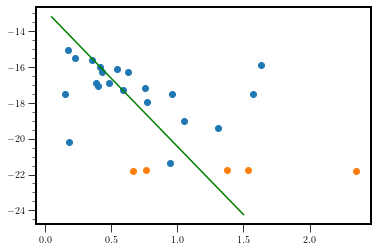

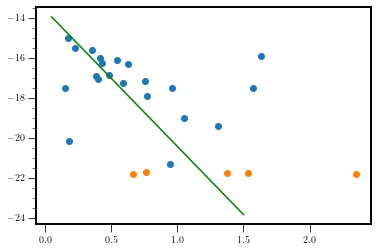

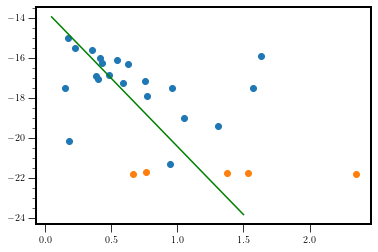

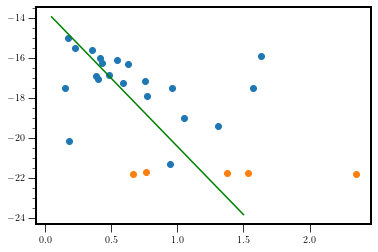

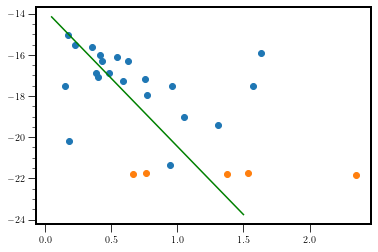

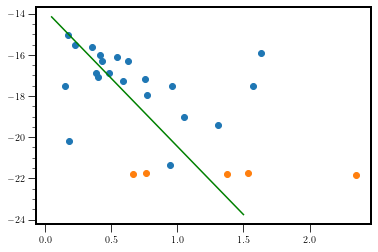

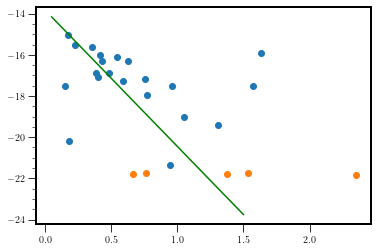

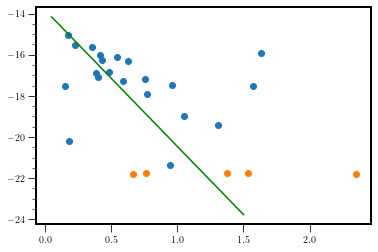

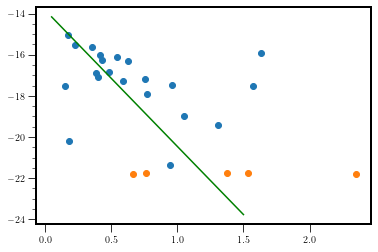

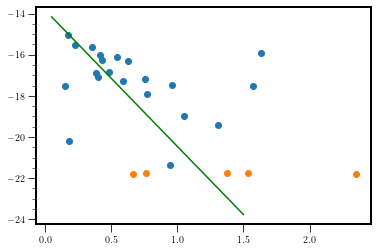

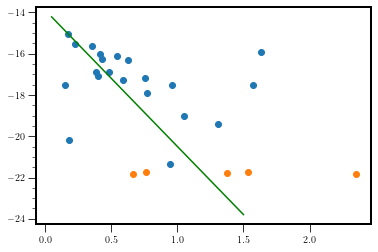

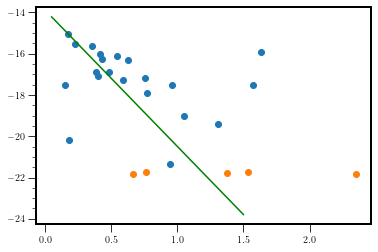

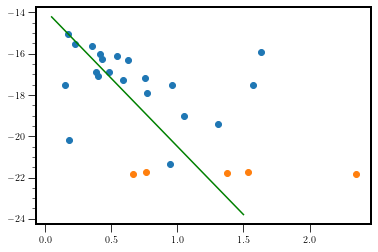

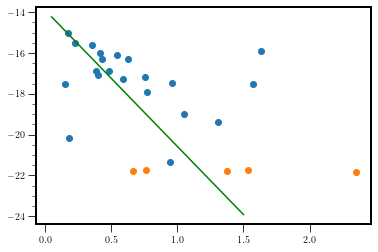

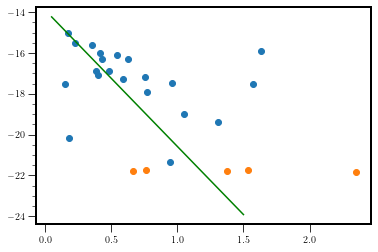

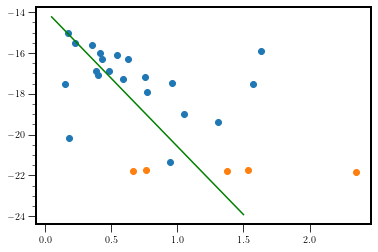

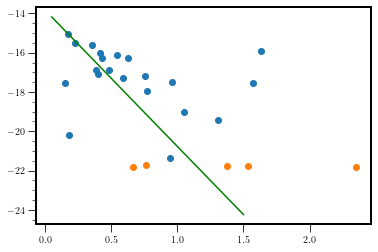

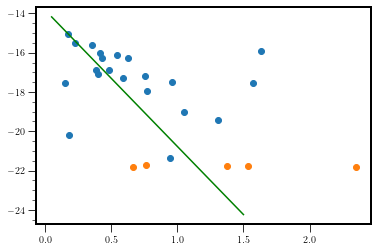

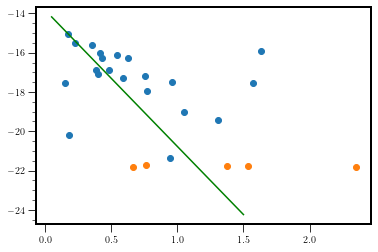

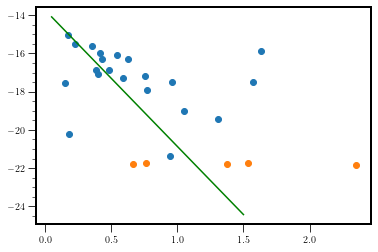

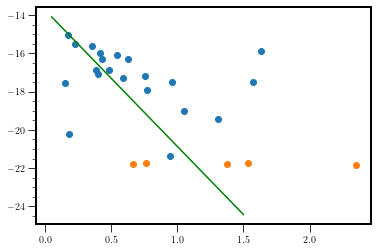

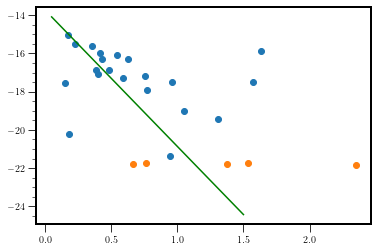

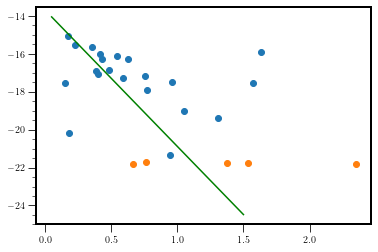

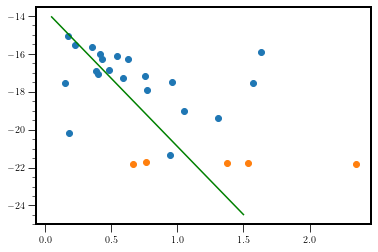

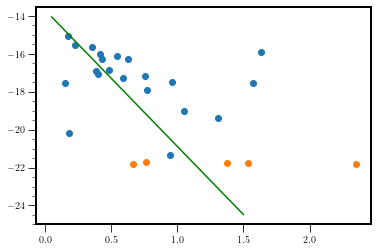

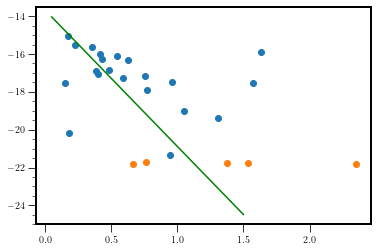

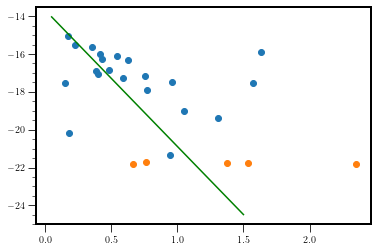

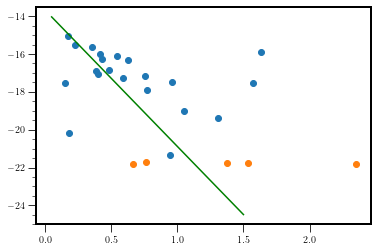

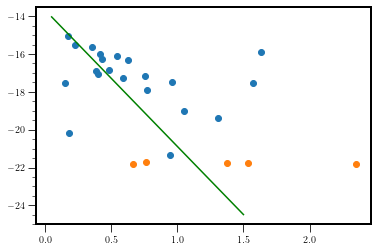

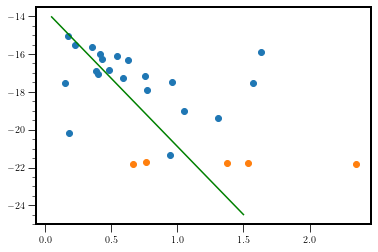

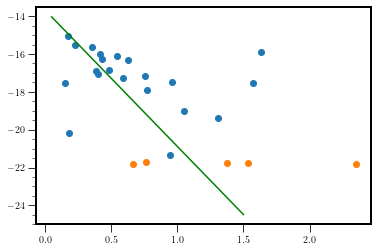

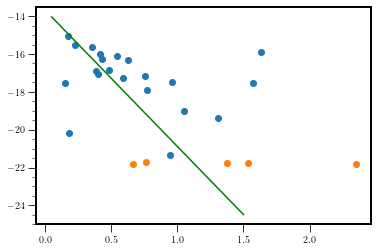

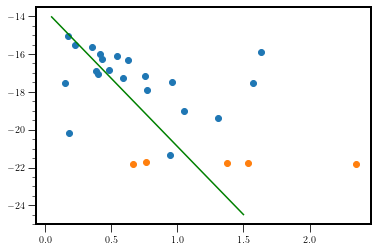

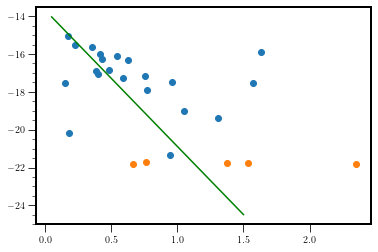

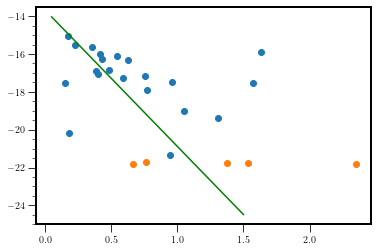

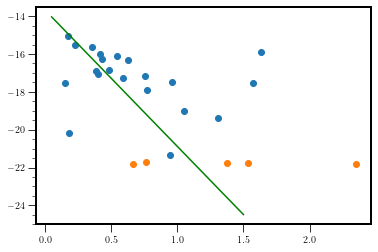

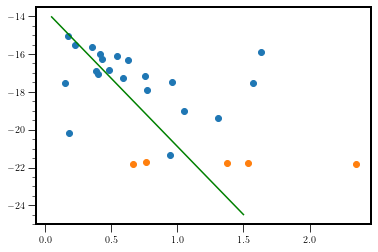

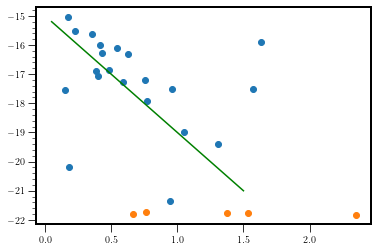

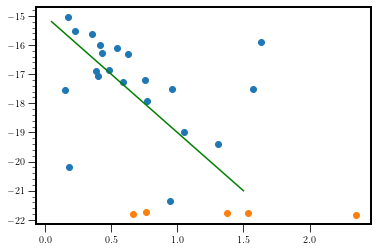

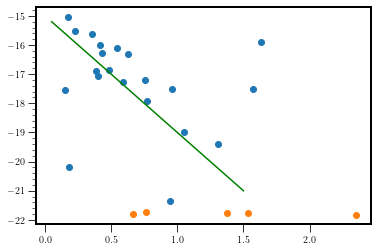

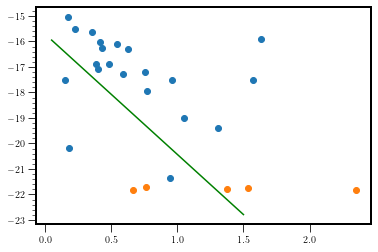

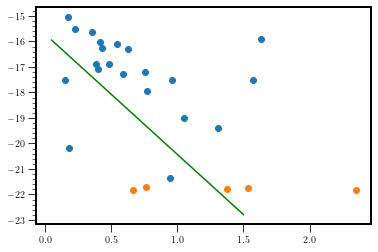

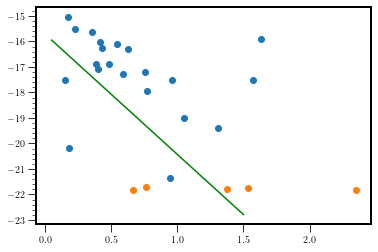

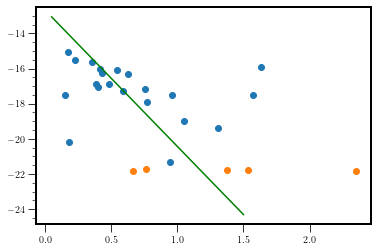

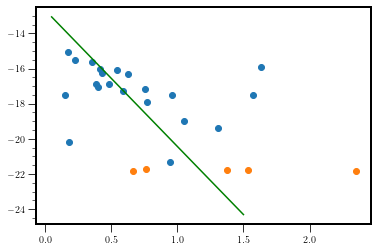

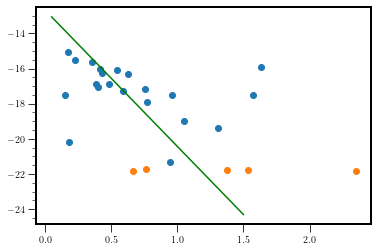

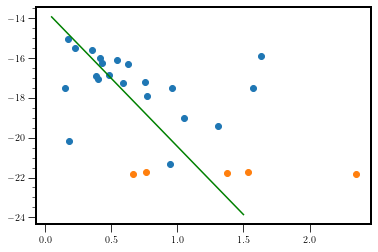

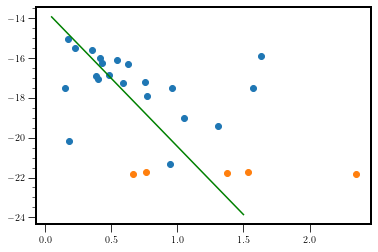

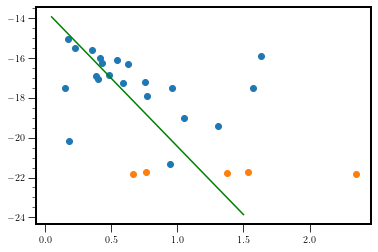

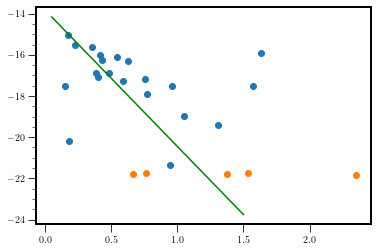

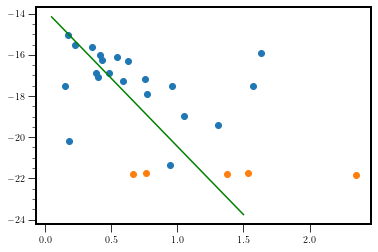

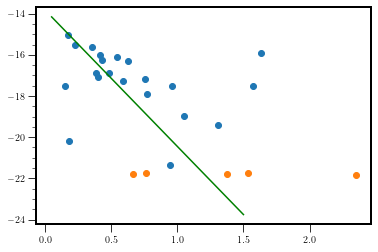

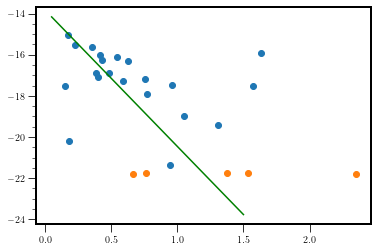

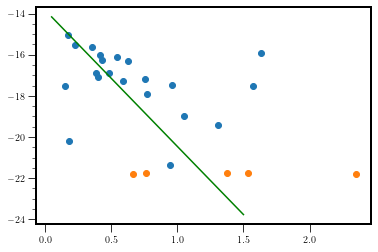

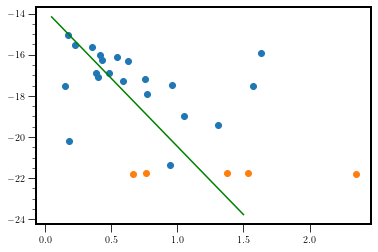

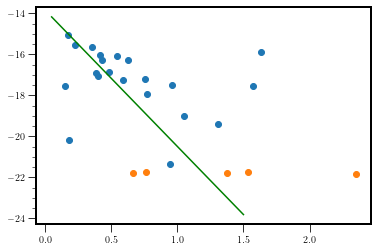

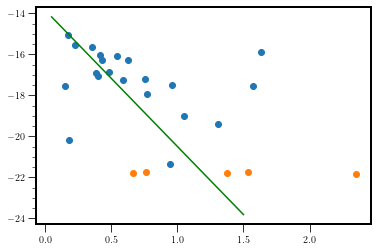

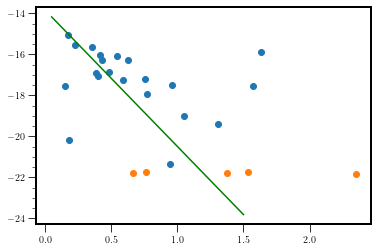

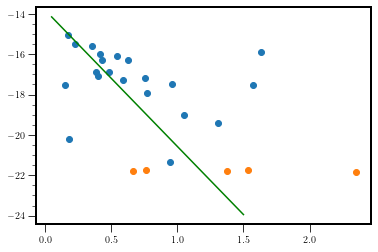

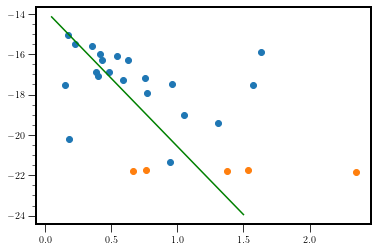

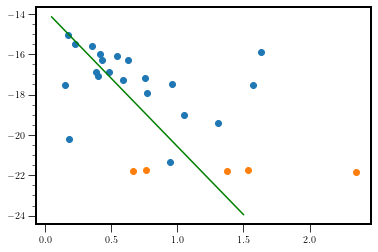

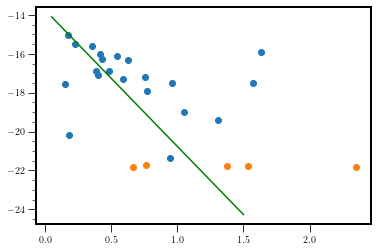

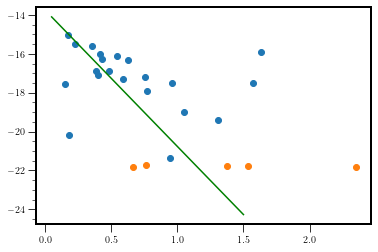

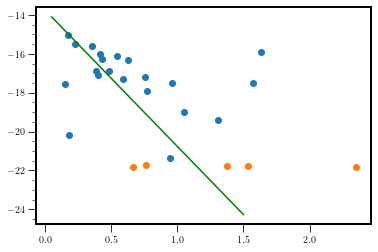

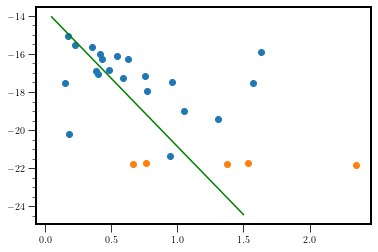

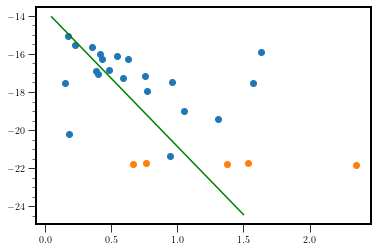

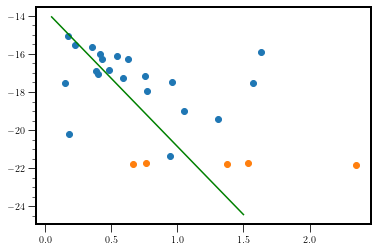

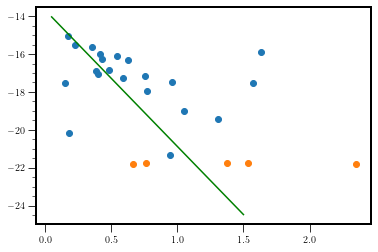

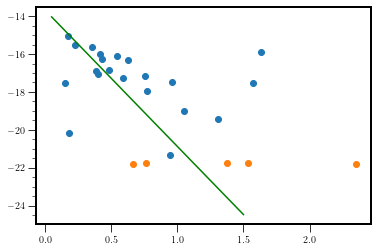

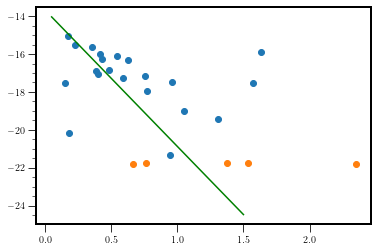

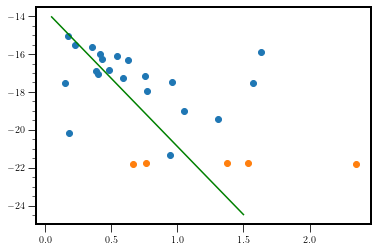

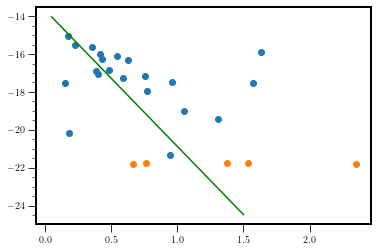

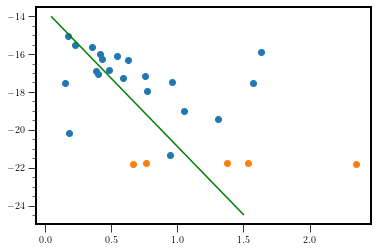

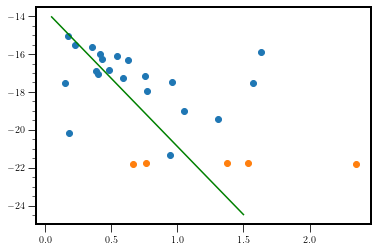

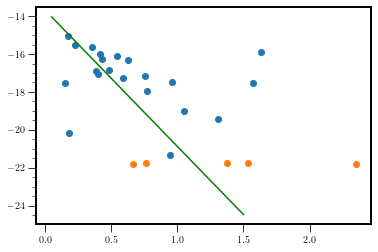

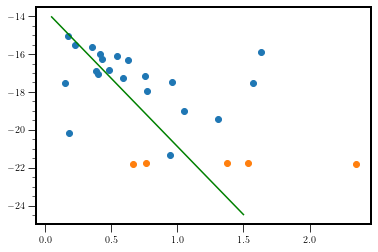

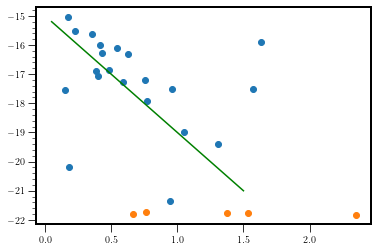

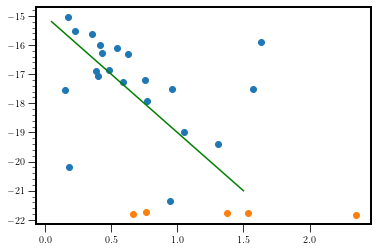

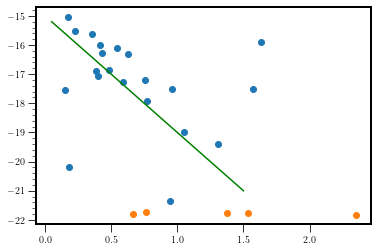

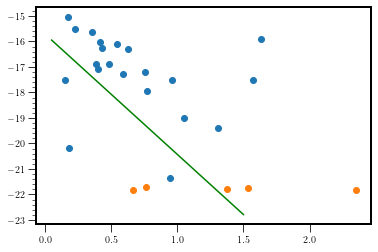

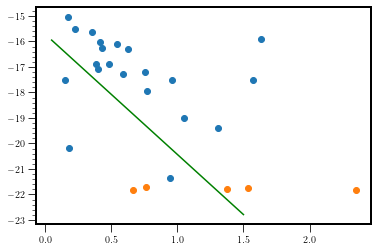

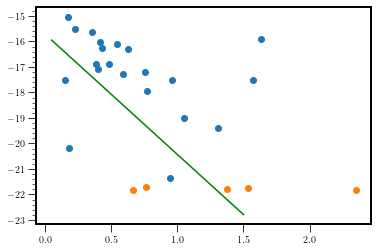

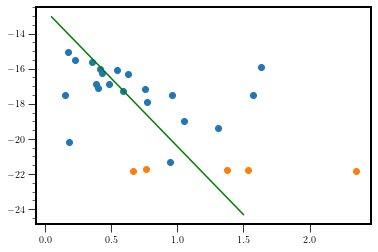

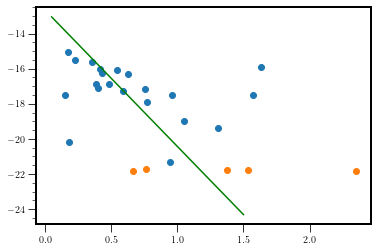

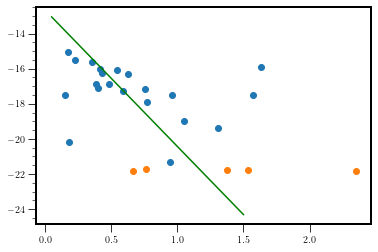

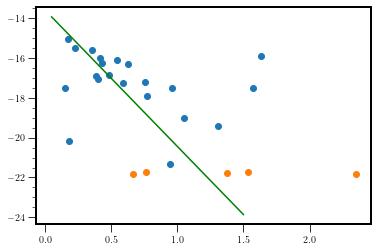

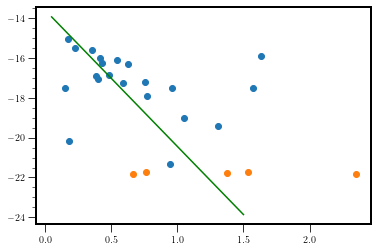

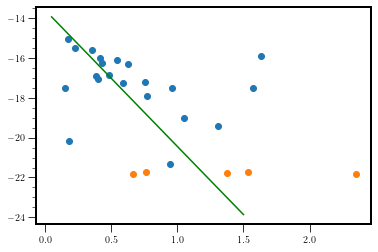

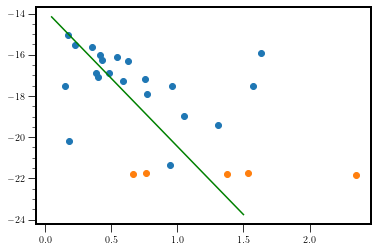

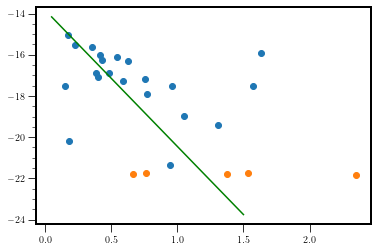

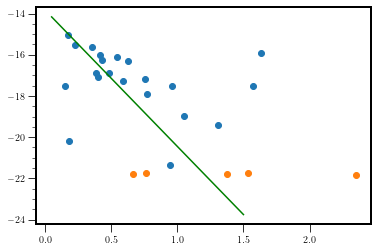

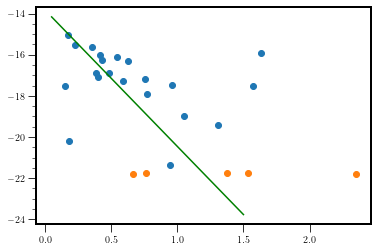

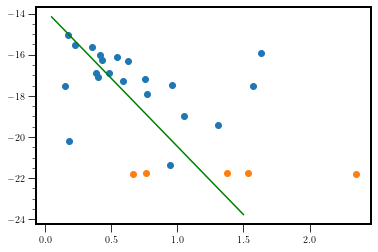

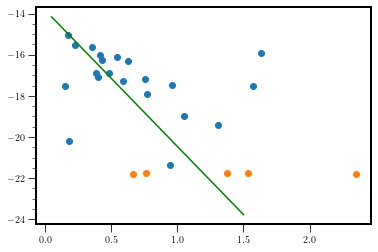

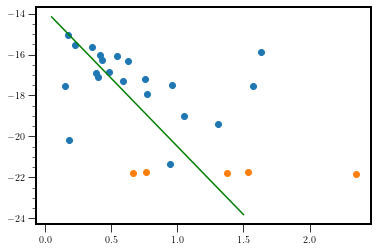

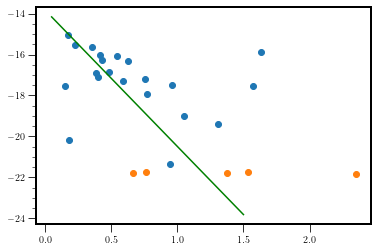

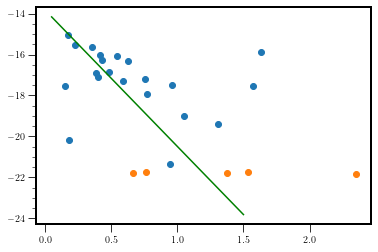

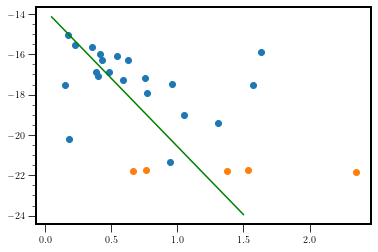

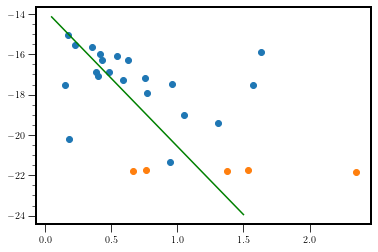

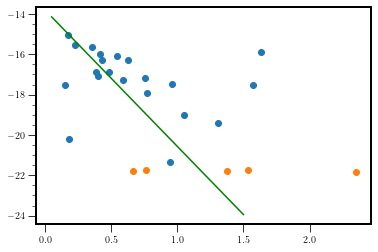

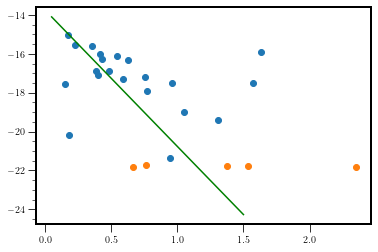

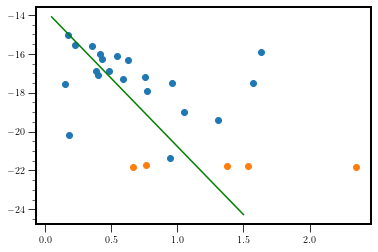

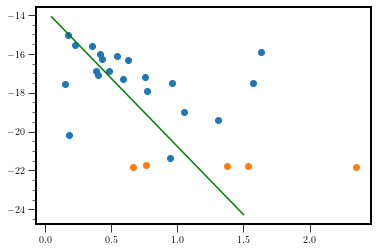

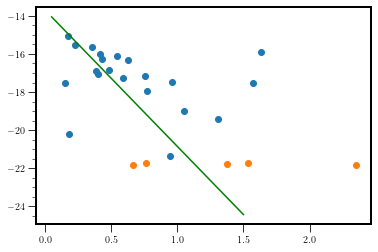

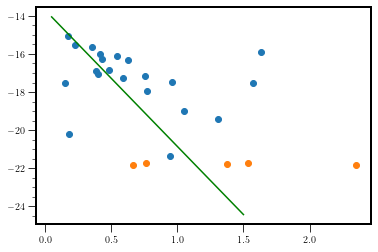

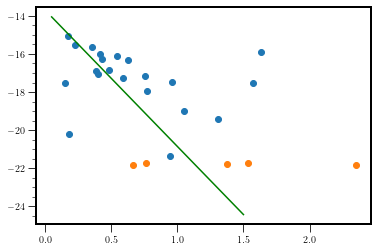

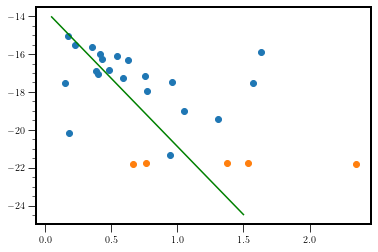

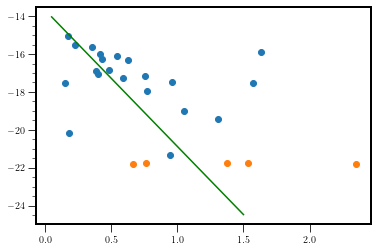

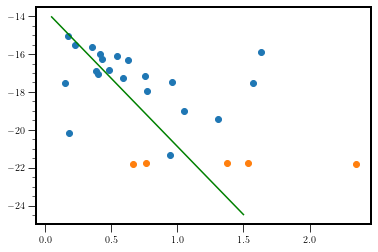

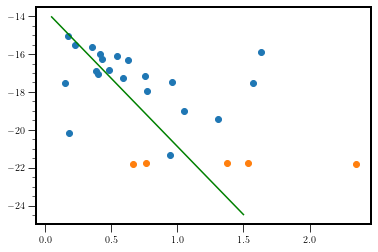

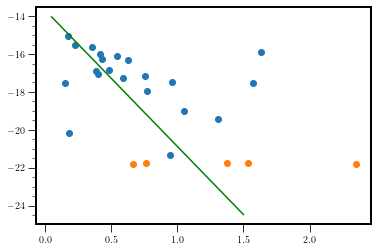

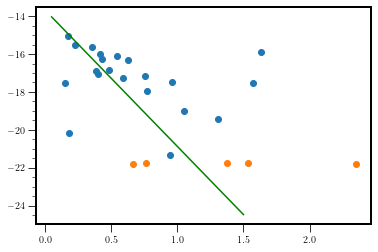

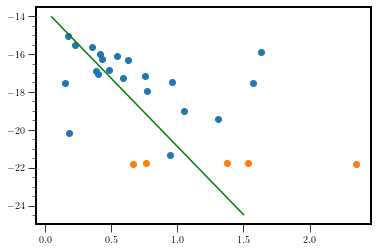

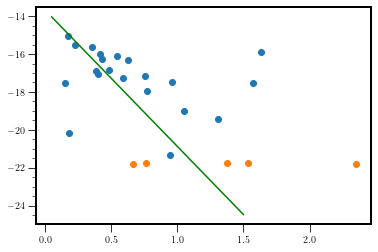

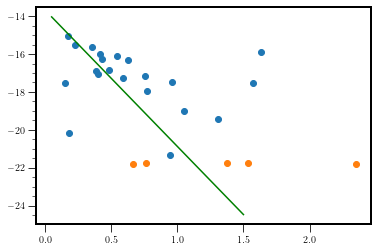

In [133]:
N = 5
sigma_intrinsic_start = 0
sigma_intrinsic = sigma_intrinsic_start
sigma_intrisic_list = [sigma_intrinsic]

for i in range(N):
    print("N = ", i)
    sig_y1_mi = np.array(NHI_abs_sigma/NHI_abs)
    sig_y1 = (sig_y1_mi**2 + sigma_intrinsic**2)**0.5
    LL_model_Hogg_total = minimize(logL_Hogg_total, np.array([-15,-4]), method='BFGS')
    print(LL_model_Hogg_total['x'])
    sigma_intrinsic = calc_sigma_intrisic(y1, model(LL_model_Hogg_total['x'], x1), sig_y1_mi)
    print(sigma_intrinsic)
    sigma_intrisic_list.append(sigma_intrinsic)

In [134]:
LL_model_Hogg_total

      fun: 34.70838501040568
 hess_inv: array([[ 0.44013348, -0.53793624],
       [-0.53793624,  0.87344322]])
      jac: array([-4.76837158e-07,  1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 39
      nit: 11
     njev: 13
   status: 0
  success: True
        x: array([-13.67972443,  -7.19304138])

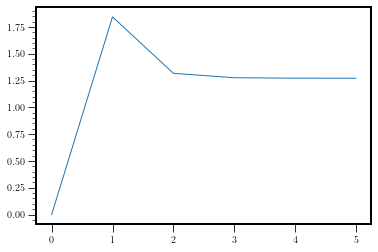

In [135]:
plt.plot(sigma_intrisic_list)

156.28710893311342 3346226.7715142868 28.545636311349668


(1e-10, 1e-06)

<Figure size 504x288 with 0 Axes>

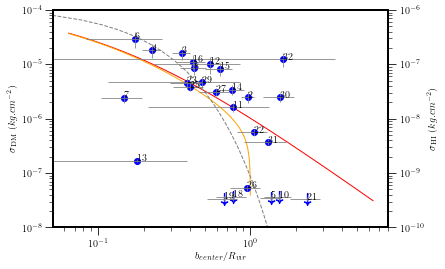

In [136]:
plt.figure(figsize = (7,4))

fig, ax1 = plt.subplots()
#plt.title("FoF groups ($N >= 5$)")
b = np.linspace(10, 1000, 5000)
mvir = 1e12
z = 1
rvir = gid.get_Rvir(mvir, z)
rho0, rs = gid.get_nfw_param(mvir, z)
print(rvir, rho0, rs)
rho = gid.nfw_rho(b, rho0, rs)
rho_column = []
rho_trunc = []
for bb in b:
    I = integrate.quad(nfw_rho_2, -np.pi/2, np.pi/2, args = (bb, rho0, rs))
    rho_column.append(float(I[0]))
    theta_lim = np.arccos(bb/rvir)
    I2 = integrate.quad(nfw_rho_2, -theta_lim, theta_lim, args = (bb, rho0, rs))
    rho_trunc.append(float(I2[0]))
#plt.plot(np.log10(b/r), np.log10(rho))
#plt.plot(np.log10(b/r), np.log10(rho_column))
#plt.plot(b/rvir, rho, linestyle = "--", color = "gray", linewidth = 1, label = "rho column")
rho_column = np.array(rho_column)
rho_trunc = np.array(rho_trunc)

convert1 = ((const.M_sun/((1*u.kpc)**2)).to(u.kg/((u.cm)**2))).value

plt.plot(b/rvir, rho_column*convert1, linestyle = "-", color = "red", linewidth = 1, label = "$\sigma_{NFW}$")
plt.plot(b/rvir, rho_trunc*convert1, linestyle = "-", color = "orange", linewidth = 1, label = "$\sigma_{NFW} trunc$")
#plt.plot(b/rvir, sig_dm*convert1, linestyle = "-", color = "red", linewidth = 1)
plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$\sigma_{\mathrm{DM}}$ $(kg.cm^{-2})$")
#plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-8, 1e-4))

    
# -----------------------------------------------------------------------

u_to_kg = 1.67355755e-27

ax2 = ax1.twinx()
NHI_abs = G5_abs["NHI"]*u_to_kg
NHI_abs_sigma = G5_abs["sigma_NHI"]*u_to_kg
NHI_noabs = G5_noabs["NHI_limit"]*u_to_kg
NHI_noabs_sigma = G5_noabs["sigma_NHI"]*u_to_kg

ax2.errorbar(G5_abs["b_center_kpc_norm2"], NHI_abs, xerr = G5_abs["b_center_kpc_norm2_err"], yerr =NHI_abs_sigma,\
            fmt = " ", color = "gray", linewidth = 0.8)
ax2.scatter(G5_abs["b_center_kpc_norm2"], NHI_abs, marker = "o", label = "groups N >= 5", \
            c = "blue")
#plt.colorbar(label = "log($M/M_{\odot}$)")

ax2.errorbar(G5_noabs["b_center_kpc_norm2"], NHI_noabs, xerr = G5_noabs["b_center_kpc_norm2_err"],\
             yerr = NHI_noabs_sigma,\
            fmt = " ", color = "gray", linewidth = 0.8)
ax2.scatter(G5_noabs["b_center_kpc_norm2"], NHI_noabs,\
            marker = "$\downarrow$", s = 150, label = "groups N >= 5", \
             c = "blue")


X = np.linspace(0.05, 1.4, 50)
ax2.plot(X, np.exp(model(LL_model_Hogg_total['x'], X)), linewidth = 1.0, c = "gray", label = "best fit", \
         linestyle = "--")

#plt.colorbar(label = "bmin kpc")

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["NHI"]*u_to_kg)
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_center_kpc_norm2"])
Y = np.array(G5_noabs["NHI_limit"])*u_to_kg
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.ylabel("$\sigma_{\mathrm{HI}}$ $(kg.cm^{-2})$")

plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-10, 1e-6))

# Group metallicity

We can use Zn/Fe in the UVES spectra to investigate groups metallicity.

In [138]:
#exp = G5[["group_id", "field_id", "N_gal", "center_z", "b_min_kpc", "b_center_kpc", "M_vel_disp"]]
#exp

In [140]:
#exp.to_csv("G5.csv", index = False)

We can look in Martin 2021 if some groups correspond to his sample: 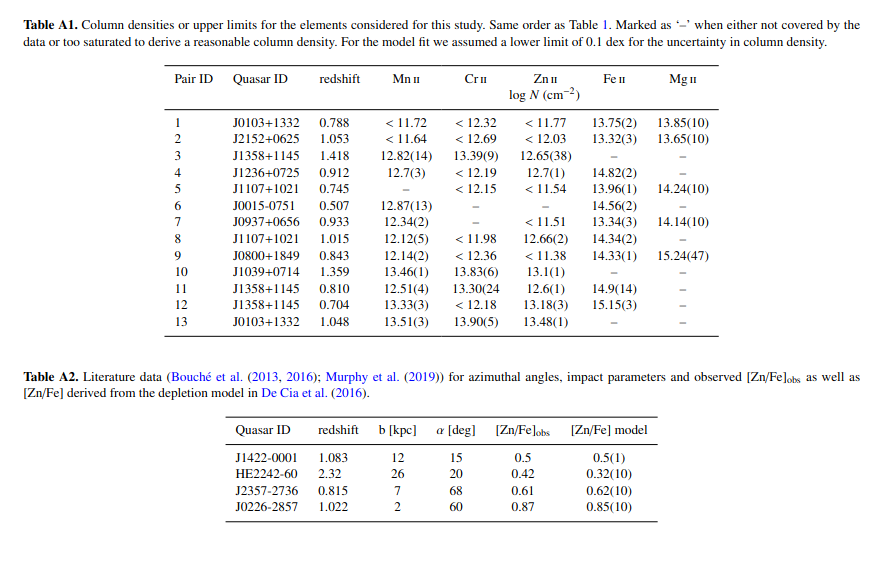

# Absorber kinematics

In [141]:
fff = "J1039p0714"
"j"+fff[1:]

'j1039p0714'

In [142]:
grplist = G5["group_id"]
Abs = pd.read_csv("MgII_all_absorption")

In [179]:
#for i in range(len(G5)):
#    gid.plot_group_absorption2(i, R, G5, Abs)

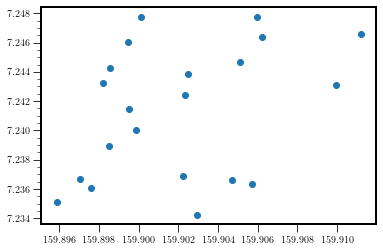

In [144]:
KK = G5.head(1)
KK = KK.squeeze()
RR = R[R["group_id"] == KK["group_id"]]
plt.scatter(RR["RA"]*u.degree, RR["DEC"]*u.degree)


In [ ]:
#gid.plot_groups_2(R, G5_raw, Nmin = 5, save = True, filename="catalog_article")

# Covering fraction

In [146]:
folder = "run_17"

In [147]:
G5_bmin_lin = G5[["b_min_kpc", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G5_bcenter_lin = G5[["b_center_kpc", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G5_bmin_norm_lin = G5[["b_min_kpc_norm2", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G5_bcenter_norm_lin = G5[["b_center_kpc_norm2", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G5_bmin_lin = G5_bmin_lin.rename(columns = {"b_min_kpc": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G5_bcenter_lin = G5_bcenter_lin.rename(columns = {"b_center_kpc": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G5_bmin_norm_lin = G5_bmin_norm_lin.rename(columns = {"b_min_kpc_norm2": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G5_bcenter_norm_lin = G5_bcenter_norm_lin.rename(columns = {"b_center_kpc_norm2": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})

G5_bmin_log = G5_bmin_lin.copy()
G5_bcenter_log = G5_bcenter_lin.copy()
G5_bmin_norm_log = G5_bmin_norm_lin.copy()
G5_bcenter_norm_log = G5_bcenter_norm_lin.copy()
G5_bmin_log["log10(b)"] = np.log10(G5_bmin_lin["b"])
G5_bcenter_log["log10(b)"] = np.log10(G5_bcenter_lin["b"])
G5_bmin_norm_log["log10(b)"] = np.log10(G5_bmin_norm_lin["b"])
G5_bcenter_norm_log["log10(b)"] = np.log10(G5_bcenter_norm_lin["b"])
G5_bmin_norm_lin["log10(b)"] = G5_bmin_norm_lin["b"]
G5_bcenter_norm_lin["log10(b)"] = G5_bcenter_norm_lin["b"]

In [148]:
G3_bmin_lin = G3[["b_min_kpc", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G3_bcenter_lin = G3[["b_center_kpc", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G3_bmin_norm_lin = G3[["b_min_kpc_norm2", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G3_bcenter_norm_lin = G3[["b_center_kpc_norm2", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G3_bmin_lin = G3_bmin_lin.rename(columns = {"b_min_kpc": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G3_bcenter_lin = G3_bcenter_lin.rename(columns = {"b_center_kpc": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G3_bmin_norm_lin = G3_bmin_norm_lin.rename(columns = {"b_min_kpc_norm2": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G3_bcenter_norm_lin = G3_bcenter_norm_lin.rename(columns = {"b_center_kpc_norm2": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})

G3_bmin_log = G3_bmin_lin.copy()
G3_bcenter_log = G3_bcenter_lin.copy()
G3_bmin_norm_log = G3_bmin_norm_lin.copy()
G3_bcenter_norm_log = G3_bcenter_norm_lin.copy()
G3_bmin_log["log10(b)"] = np.log10(G3_bmin_lin["b"])
G3_bcenter_log["log10(b)"] = np.log10(G3_bcenter_lin["b"])
G3_bmin_norm_log["log10(b)"] = np.log10(G3_bmin_norm_lin["b"])
G3_bcenter_norm_log["log10(b)"] = np.log10(G3_bcenter_norm_lin["b"])
G3_bmin_norm_lin["log10(b)"] = G3_bmin_norm_lin["b"]
G3_bcenter_norm_lin["log10(b)"] = G3_bcenter_norm_lin["b"]

In [149]:
G5_bmin_lin.to_csv(folder + "/G5_mgii_bmin_lin.csv", index = False)
G5_bcenter_lin.to_csv(folder + "/G5_mgii_bcenter_lin.csv", index = False)
G5_bmin_log.to_csv(folder + "/G5_mgii_bmin_log.csv", index = False)
G5_bcenter_log.to_csv(folder + "/G5_mgii_bcenter_log.csv", index = False)
G5_bmin_norm_lin.to_csv(folder + "/G5_mgii_bmin_norm_lin.csv", index = False)
G5_bcenter_norm_lin.to_csv(folder + "/G5_mgii_bcenter_norm_lin.csv", index = False)
G5_bmin_norm_log.to_csv(folder + "/G5_mgii_bmin_norm_log.csv", index = False)
G5_bcenter_norm_log.to_csv(folder + "/G5_mgii_bcenter_norm_log.csv", index = False)

In [150]:
G3_bmin_lin.to_csv(folder + "/G3_mgii_bmin_lin.csv", index = False)
G3_bcenter_lin.to_csv(folder + "/G3_mgii_bcenter_lin.csv", index = False)
G3_bmin_log.to_csv(folder + "/G3_mgii_bmin_log.csv", index = False)
G3_bcenter_log.to_csv(folder + "/G3_mgii_bcenter_log.csv", index = False)
G3_bmin_norm_lin.to_csv(folder + "/G3_mgii_bmin_norm_lin.csv", index = False)
G3_bcenter_norm_lin.to_csv(folder + "/G3_mgii_bcenter_norm_lin.csv", index = False)
G3_bmin_norm_log.to_csv(folder + "/G3_mgii_bmin_norm_log.csv", index = False)
G3_bcenter_norm_log.to_csv(folder + "/G3_mgii_bcenter_norm_log.csv", index = False)

### fc for N>=5

MgII_closest_onlyRobust_LR
Reading from None
LEN (Outcomes) 26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [p_out, f_out, beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:05<00:00, 1772.50draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


['alpha', 'beta', 'f_out', 'p_out']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -5.785313 -12.039374 -8.473073 -5.493525 -2.954547 -1.339416
beta   2.217351   1.906694  2.047026  2.175995  2.394640  2.811269
f_out  0.177509   0.006301  0.038747  0.148738  0.334485  0.465270
p_out  0.609392   0.050499  0.280473  0.654477  0.906974  0.987369
alpha -5.5 [-12.04--1.34] (95\%) 
beta 2.2 [1.91-2.81] (95\%) 
f_out 0.1 [0.01-0.47] (95\%) 
p_out 0.7 [0.05-0.99] (95\%) 

WAIC 22.99 +/- 4.22 peff 1.15
WAIC deviance 20.68352520687586
LOO 23.01 +/- 4.23 peff 1.16
WBIC  31.81334115183856
Deviance Lmax 32.0473
DIC Lmax 41.8062 4.88
Deviance best 32.0934
DIC best 41.7601 4.83
|               WAIC |                LOO |              WBIC |               DIC |
| 22.991277816975572 | 23.008374646804004 | 31.81334115183856 | 41.76011081091992 |
['alpha', 'beta', 'f_out', 'p_out']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -5.785313 -12.039374 -8.4

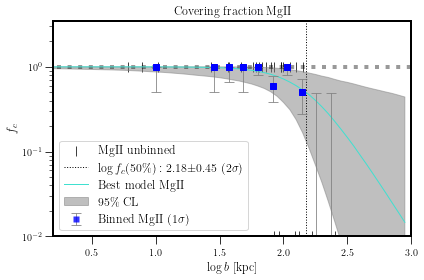

In [151]:
fc_G5_bmin_noz = run_covering_2.mgii(run = True, filename = folder + "/G5_mgii_bmin_log.csv", redshift = False, with_outliers = 'Robust_LR')

In [152]:
-11.97 +5.6

-6.370000000000001

In [153]:
-1.3 +5.6

4.3

In [154]:
1.85 - 2.1

-0.25

In [155]:
2.67 - 2.1

0.5699999999999998

In [156]:
0.47 - 0.2

0.26999999999999996

In [157]:
0.05 - 0.6

-0.5499999999999999

MgII_closest_only_redshiftRobust_LR
Reading from None
LEN (Outcomes) 26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [p_out, f_out, zalpha, beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:16<00:00, 537.08draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


['alpha', 'beta', 'zalpha', 'f_out', 'p_out']
            mean        2.5      16.0      50.0      84.0       97.5
alpha  -5.238751 -12.038103 -8.316371 -5.033620 -2.246625  -0.288108
beta    1.451930   0.302025  0.871303  1.460106  2.004911   2.608376
zalpha  3.179476  -1.566579  0.947475  2.942030  5.761978  10.663628
f_out   0.179375   0.005524  0.041270  0.151504  0.334128   0.463553
p_out   0.572724   0.049642  0.247084  0.602596  0.879055   0.979150
alpha -5.0 [-12.04--0.29] (95\%) 
beta 1.5 [0.30-2.61] (95\%) 
zalpha 2.9 [-1.57-10.66] (95\%) 
f_out 0.2 [0.01-0.46] (95\%) 
p_out 0.6 [0.05-0.98] (95\%) 

WAIC 22.84 +/- 4.76 peff 1.90
WAIC deviance 19.036889094579642
LOO 22.90 +/- 4.78 peff 1.93
WBIC  31.973461569277383
Deviance Lmax 30.6037
DIC Lmax 44.4678 6.93
Deviance best 31.4493
DIC best 43.6222 6.09
|               WAIC |                LOO |               WBIC |                DIC |
| 22.836933905269493 | 22.898080937608945 | 31.973461569277383 | 43.622169185009334 |
['alph

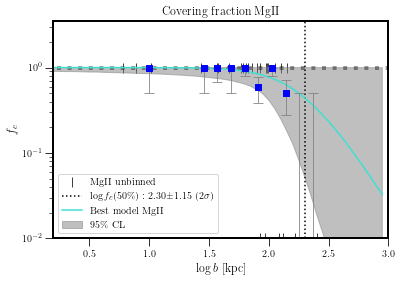

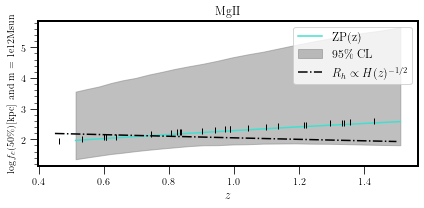

In [173]:
fc_G5_bmin_z = run_covering_2.mgii(run = True, filename = folder + "/G5_mgii_bmin_log.csv", redshift = True, with_outliers = 'Robust_LR')

MgII_closest_onlyRobust_LR
Reading from None
LEN (Outcomes) 26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [p_out, f_out, beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:06<00:00, 1410.28draws/s]
The acceptance probability does not match the target. It is 0.7000363231936433, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


['alpha', 'beta', 'f_out', 'p_out']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -3.894893 -10.884497 -7.222937 -4.092111 -1.461260  6.522149
beta   2.309861   0.543596  2.183052  2.432330  2.688358  2.929484
f_out  0.230097   0.010092  0.065700  0.220205  0.402717  0.486257
p_out  0.600612   0.052136  0.274382  0.643635  0.900774  0.984159
alpha -4.1 [-10.89-6.52] (95\%) 
beta 2.4 [0.54-2.93] (95\%) 
f_out 0.2 [0.01-0.49] (95\%) 
p_out 0.6 [0.05-0.98] (95\%) 

WAIC 27.37 +/- 4.51 peff 1.33
WAIC deviance 24.713014774170023
LOO 27.39 +/- 4.52 peff 1.34
WBIC  32.975127793006614
Deviance Lmax 36.1026
DIC Lmax 46.9060 5.40
Deviance best 36.2983
DIC best 46.7104 5.21
|               WAIC |                LOO |               WBIC |               DIC |
| 27.367525783431716 | 27.392143601437844 | 32.975127793006614 | 46.71035674423538 |
['alpha', 'beta', 'f_out', 'p_out']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -3.894893 -10.884497 -

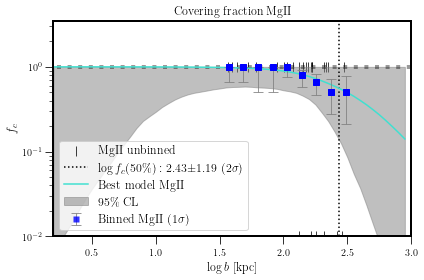

In [174]:
fc_G5_bcenter_noz = run_covering_2.mgii(run = True, filename = folder + "/G5_mgii_bcenter_log.csv", redshift = False, with_outliers = 'Robust_LR')

MgII_closest_only_redshiftRobust_LR
Reading from None
LEN (Outcomes) 26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [p_out, f_out, zalpha, beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:15<00:00, 575.46draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


['alpha', 'beta', 'zalpha', 'f_out', 'p_out']
            mean        2.5      16.0      50.0      84.0       97.5
alpha  -3.162540 -11.560345 -7.363242 -3.460558  0.871641   7.529997
beta    1.520286   0.248705  0.808094  1.506096  2.239804   2.843265
zalpha  2.534562 -19.091929 -4.011756  3.742915  8.050336  16.951454
f_out   0.234046   0.015760  0.074105  0.229459  0.391546   0.482555
p_out   0.503908   0.040820  0.198997  0.506438  0.802005   0.963886
alpha -3.5 [-11.56-7.52] (95\%) 
beta 1.5 [0.25-2.84] (95\%) 
zalpha 3.7 [-19.09-16.93] (95\%) 
f_out 0.2 [0.02-0.48] (95\%) 
p_out 0.5 [0.04-0.96] (95\%) 

WAIC 26.97 +/- 5.59 peff 2.20
WAIC deviance 22.565659766898612
LOO 27.04 +/- 5.63 peff 2.24
WBIC  32.98443211925411
Deviance Lmax 32.8253
DIC Lmax 50.2597 8.72
Deviance best 34.2166
DIC best 48.8684 7.33
|               WAIC |                LOO |              WBIC |                DIC |
| 26.973571610586674 | 27.039077943596713 | 32.98443211925411 | 48.868388171280635 |
['alpha',

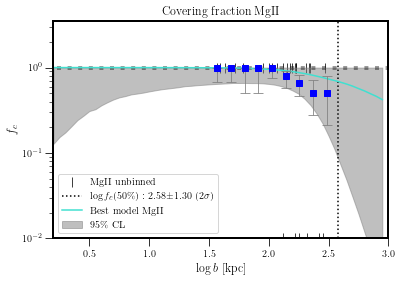

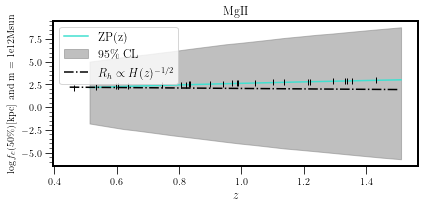

In [175]:
fc_G5_bcenter_z = run_covering_2.mgii(run = True, filename = folder + "/G5_mgii_bcenter_log.csv", redshift = True, with_outliers = 'Robust_LR')

MgII_closest_only
Reading from None
LEN (Outcomes) 26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:03<00:00, 2531.31draws/s]
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -2.007341 -4.207328 -2.961811 -1.883027 -1.047564 -0.555289
beta   1.704704  1.067879  1.294136  1.601782  2.143535  2.965060
alpha -1.9 [-4.21--0.56] (95\%) 
beta 1.6 [1.07-2.96] (95\%) 

WAIC 25.84 +/- 5.98 peff 1.63
WAIC deviance 22.583229836046193
LOO 25.91 +/- 6.00 peff 1.66
WBIC  29.04223232951547
Deviance Lmax 25.0133
DIC Lmax 29.8672 2.43
Deviance best 25.0398
DIC best 29.8406 2.40
|               WAIC |               LOO |              WBIC |              DIC |
| 25.839753759244292 | 25.90745089016142 | 29.04223232951547 | 29.8406476405365 |
['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -2.007341 -4.207328 -2.961811 -1.883027 -1.047564 -0.555289
beta   1.704704  1.067879  1.294136  1.601782  2.143535  2.965060


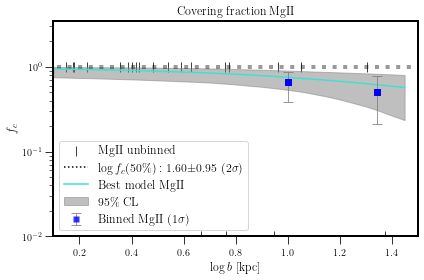

In [176]:
fc_G5_bcenter_norm_raw = run_covering_2.mgii(run = True, filename = folder + "/G5_mgii_bcenter_norm_lin.csv", \
                                         redshift = False, xlim = [0.1, 1.5])

MgII_closest_onlyRobust_LR
Reading from None
LEN (Outcomes) 26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [p_out, f_out, beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:06<00:00, 1384.42draws/s]
The number of effective samples is smaller than 25% for some parameters.


['alpha', 'beta', 'f_out', 'p_out']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -3.332042 -9.413801 -5.262915 -2.759769 -1.387635 -0.647745
beta   1.704517  0.836052  1.210136  1.656570  2.229898  2.800674
f_out  0.238595  0.011944  0.078568  0.234635  0.403023  0.483200
p_out  0.557070  0.046747  0.240616  0.580903  0.858554  0.980631
alpha -2.8 [-9.41--0.65] (95\%) 
beta 1.7 [0.84-2.80] (95\%) 
f_out 0.2 [0.01-0.48] (95\%) 
p_out 0.6 [0.05-0.98] (95\%) 

WAIC 26.73 +/- 5.42 peff 1.61
WAIC deviance 23.504222760296514
LOO 26.77 +/- 5.43 peff 1.63
WBIC  32.231813929604165
Deviance Lmax 33.4554
DIC Lmax 43.6105 5.08
Deviance best 33.7759
DIC best 43.2900 4.76
|               WAIC |                LOO |               WBIC |               DIC |
| 26.725350236035652 | 26.773382825940285 | 32.231813929604165 | 43.29004228200118 |
['alpha', 'beta', 'f_out', 'p_out']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -3.332042 -9.413801 -5.26291

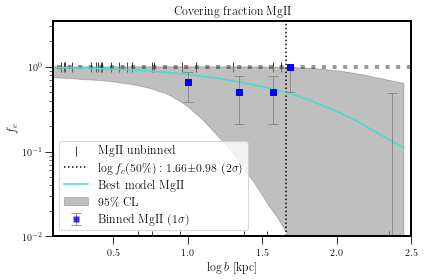

In [177]:
fc_G5_bcenter_norm = run_covering_2.mgii(run = True, filename = folder + "/G5_mgii_bcenter_norm_lin.csv", \
                                         redshift = False, with_outliers = 'Robust_LR', xlim = [0.1, 2.5])

In [178]:
9.54 - 2.4

7.139999999999999

In [ ]:
9.54 - 2.4

In [ ]:
1.5 - 0.67

In [ ]:
2.79 - 1.5

In [ ]:
0.02 - 0.3

In [ ]:
0.49 - 0.3

In [ ]:
0.06 - 0.6

In [ ]:
0.98 - 0.6

### fc for N>=3

In [ ]:
fc_G3_bmin_noz = run_covering_2.mgii(run = True, filename = folder + "/G3_mgii_bmin_log.csv", redshift = False, with_outliers = 'Robust_LR')

In [ ]:
fc_G3_bmin_z = run_covering_2.mgii(run = True, filename = folder + "/G3_mgii_bmin_log.csv", redshift = True, with_outliers = 'Robust_LR')

In [ ]:
#fc_G3_bcenter_noz = run_covering_2.mgii(run = True, filename = folder + "/G3_mgii_bcenter_log.csv", redshift = False, with_outliers = 'Robust_LR')

In [ ]:
#fc_G3_bcenter_z = run_covering_2.mgii(run = True, filename = folder + "/G3_mgii_bcenter_log.csv", redshift = True, with_outliers = 'Robust_LR')

## Comparison with other results

In [180]:
logb = np.linspace(0.5, 3, 50)
logb_norm = np.linspace(0.05, 4)

#### Dutta 2020

In [233]:
Dutta_2020 = pd.read_csv("Dutta_2020.csv", index_col = False)
Dutta_2020_fcdiff = pd.read_csv("Dutta_2020_fcdiff.csv", index_col = False)

#### Schroetter 2021

In [182]:
def logistic(t):
    return 1/(1+np.exp(-t))
    
def logistic_eq6(A, C, logb):
    return logistic(A*(logb - C))

def logistic_eq7(A, B, C, logb, z):
    return logistic(A*(logb - B*np.log10(1+z) - C))

Il_6 = logistic_eq6(-4.6, 1.6, logb)
Il_7 = logistic_eq7(-4.2, 2.0, 1.0, logb, 1.2)
Il = np.array([logb, Il_6, Il_7])

Schroetter_2021 = pd.DataFrame(Il.T, columns = ["logb", "best_fit_b", "best_fit_bz"])

In [183]:
# For the CL intervals:
Schroetter_fc_sup = pd.read_csv("Schroetter_fc_sup.csv", index_col = False)
Schroetter_fc_inf = pd.read_csv("Schroetter_fc_inf.csv", index_col = False)

In [184]:
Sc_logb_sup = np.interp(logb, Schroetter_fc_sup["log_b_sup"], Schroetter_fc_sup["log_fc_sup"])
Sc_logb_inf = np.interp(logb, Schroetter_fc_inf["log_b_inf"], Schroetter_fc_inf["log_fc_inf"])

#### Nielsen 2013

In [185]:
Niels_b = [12.5, 37.5, 75, 150]
Niels_01 = [1, 0.94, 0.61, 0.29]
Niels_03 = [0.96, 0.79, 0.40, 0.25]
Niels_1 = [0.39, 0.31, 0.13, 0.06]
Niels = np.array([Niels_b, Niels_01, Niels_03, Niels_1])
Nielsen_2013 = pd.DataFrame(Niels.T, columns = ["b", "fc01", "fc03", "fc1"])

#### Bordoloi 2011

In [186]:
bordoloi_b = [20 ,50, 70, 100, 140, 180]
bordoloi_rew_group = [0.33 , 0.46, 0.39, 0.16, 0.15, 0.046] #upper limit for the last value
bordoloi_rew_nongroup = [0.48 , 0.38, 0.18, 0.04, 0.012, 0] #upper limit for the last value
bordoloi_sig_group = [0.09 , 0.07, 0.05, 0.04, 0.03, 0]
bordoloi_sig_nongroup = [0.05 , 0.05, 0.05, 0.02, 0, 0]
d = np.array([bordoloi_b, bordoloi_rew_group, bordoloi_rew_nongroup, bordoloi_sig_group, bordoloi_sig_nongroup])
bordoloi = pd.DataFrame(d.T, columns = ["bcenter_kpc", "rew_group", "rew_nongroup", "sigma_group", "sigma_nongroup"])
bordoloi

bcenter_kpc  rew_group  rew_nongroup  sigma_group  sigma_nongroup
0         20.0      0.330         0.480         0.09            0.05
1         50.0      0.460         0.380         0.07            0.05
2         70.0      0.390         0.180         0.05            0.05
3        100.0      0.160         0.040         0.04            0.02
4        140.0      0.150         0.012         0.03            0.00
5        180.0      0.046         0.000         0.00            0.00

#### Huang 2021

In [187]:
Huang_b = [20, 70, 200, 500]
Huang_all = [0.87, 0.49, 0.19, 0.06]
Huang_all_sigma = [0.05, 0.06, 0.12, 0.06]
Huang_blue = [0.92, 0.56, 0.19, 0.08]
Huang_red = [0.67, 0.41, 0.09, 0.04]
Huang = np.array([Huang_b, Huang_all, Huang_all_sigma, Huang_blue, Huang_red])
Huang_2021 = pd.DataFrame(Huang.T, columns = ["b", "all","all_sigma", "blue", "red"])

In [188]:
pbest, plow, phigh = fc_G5_bcenter_norm.predict_2d(logb_norm, 1.0, params=fc_G5_bcenter_norm.trace)

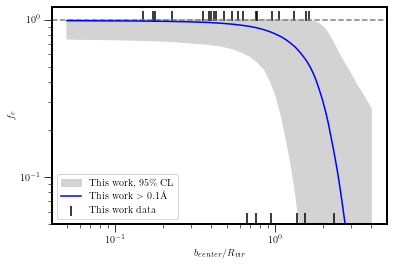

In [189]:
plt.rcParams['lines.linewidth']=1.5
plt.axhline(0.0, color = "grey", linestyle = "--")
plt.axhline(1, color = "grey", linestyle = "--")
plt.fill_between(logb_norm, plow, phigh, color = 'lightgray', label = "This work, 95\% CL")
plt.plot(logb_norm, pbest, label= "This work $> 0.1$\AA", color = "blue")
plt.scatter(fc_G5_bcenter_norm.log_flux, fc_G5_bcenter_norm.outcomes+0.055, marker = "|", color = "black", s = 100, label = "This work data")
#plt.axhline(0.5, color = "gray", linestyle = "--", linewidth = 1, label = "$P = 50\%$")

#plt.plot(Schroetter_2020["logb"], Schroetter_2020["best_fit_bz"], linestyle = "-.",  color = "darkviolet", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
#plt.legend(bbox_to_anchor=(0.5, 1.25), loc = 'center', ncol = 2)
plt.legend()
plt.ylim((0.05,1.2))
plt.yscale("log")
plt.xlabel("$b_{center}/ R_{vir}$")
plt.ylabel("$f_c$")
plt.xscale("log")

In [190]:
#pbest, plow, phigh = fc_G3_bmin_noz.predict_2d(logb, 1.0, params=fc_G3_bmin_noz.trace)

plt.rcParams['lines.linewidth']=1.5
plt.axhline(0.0, color = "grey", linestyle = "--")
plt.axhline(1, color = "grey", linestyle = "--")
plt.fill_between(10**logb, plow, phigh, color = 'lightgray')
plt.plot(10**logb, pbest, label= "This work $> 0.1$\AA", color = "blue")
plt.scatter(10**fc_G3_bmin_noz.log_flux, fc_G3_bmin_noz.outcomes+0.01, marker = "|", color = "black", s = 100)
#plt.scatter(np.log10(G3["b_min_kpc"]), G3["bool_absorption"])

#Dutta 2020
#plt.plot(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_groups"], linestyle = "--", color = "orange", marker = "o", label = "Dutta 2020 groups")
#plt.vlines(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_groups_inf"], Dutta_2020["fc_groups_sup"], color = "orange", lw=1)
#plt.plot(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_isol"], linestyle = "--",  color = "red", marker = "o", label = "Dutta 2020 isolated")
#plt.vlines(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_isol_inf"], Dutta_2020["fc_isol_sup"], color = "red", lw=1)

#Schroetter 2020
#plt.plot(Schroetter_2020["logb"], Schroetter_2020["best_fit_b"], linestyle = "-.",  color = "green", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
plt.plot(10**Schroetter_2021["logb"], Schroetter_2021["best_fit_bz"], linestyle = "-.",  color = "darkviolet", marker = " ", label = "Schroetter 2021, $> 0.1$\AA")

#Nielsen 2013
plt.scatter(Nielsen_2013["b"], Nielsen_2013["fc01"],  color = "tomato", marker = "x", label = "Nielsen 2013, $> 0.1$\AA")
plt.scatter(Nielsen_2013["b"], Nielsen_2013["fc03"],  color = "orange", marker = "s", label = "Nielsen 2013, $> 0.3$\AA")
#plt.plot(Nielsen_2013["b"], Nielsen_2013["fc1"],  color = "skyblue", marker = "x", label = "Nielsen 2013, 1.0A")

#Huang 2021
#plt.errorbar(np.log10(Huang_2021["b"]), Huang_2021["all"], yerr= Huang_2021["all_sigma"], linestyle = '', color = "crimson", marker = "s", label = "Huang 2021, $> 0.3$\AA")



#plt.legend(bbox_to_anchor=(0.5, 1.12), loc = 'center', ncol = 2)
plt.legend()
plt.ylim((0.01,2))
plt.xlim((1, 500))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("distance to closest galaxy (kpc)")
plt.ylabel("$f_c$")

In [224]:
pbest, plow, phigh = fc_G5_bmin_noz.predict_2d(logb, 1.0, params=fc_G5_bmin_noz.trace)

In [203]:
b = np.linspace(0,350, 100)

In [204]:
pbest, plow, phigh = fc_G5_bmin_noz.predict_2d(b, 1.0, params=fc_G5_bmin_noz.trace)

In [211]:
fc_cum = []
step = (b[1:] - b[:-1]).mean()
print(step)
for i in b:
    pbest_list = pbest[b<=i]
    fc_cum.append(pbest_list.sum()/(len(pbest_list)))

3.5353535353535355


In [231]:
rr = Dutta_2020["R(kpc)"].tolist()
fcc = Dutta_2020["fc_groups"].tolist()
rr = np.array([0] + rr)
fcc = np.array([0] + fcc)
fcdiff = (fcc[1:]*rr[1:]**2 - fcc[:-1]*rr[:-1]**2)/(rr[1:]**2-rr[:-1]**2)
fcdiff
rrr = (rr[1:] + rr[:-1])/2

Text(0, 0.5, '$f_c$')

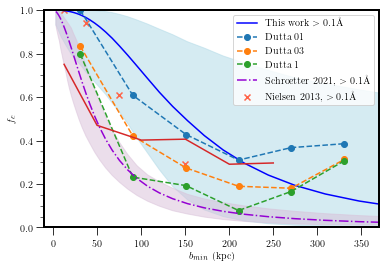

In [237]:
plt.rcParams['lines.linewidth']=1.5
plt.axhline(0.0, color = "grey", linestyle = "--")
plt.axhline(1, color = "grey", linestyle = "--")
plt.fill_between(10**logb, plow, phigh, color = 'lightblue', alpha = 0.5)
plt.plot(10**logb, pbest, label= "This work $> 0.1$\AA", color = "blue")
#plt.scatter(10**fc_G5_bmin_noz.log_flux, fc_G5_bmin_noz.outcomes+0.055, marker = "|", color = "black", s = 100)
#plt.scatter(b, fc_cum)

#Dutta 2020
#plt.plot(Dutta_2020["R(kpc)"], Dutta_2020["fc_groups"], linestyle = "--", color = "orange", marker = "o", label = "Dutta 2020 groups")
#plt.vlines(Dutta_2020["R(kpc)"], Dutta_2020["fc_groups_inf"], Dutta_2020["fc_groups_sup"], color = "orange", lw=1)
#plt.plot(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_isol"], linestyle = "--",  color = "red", marker = "o", label = "Dutta 2020 isolated")
#plt.vlines(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_isol_inf"], Dutta_2020["fc_isol_sup"], color = "red", lw=1)
plt.plot(Dutta_2020_fcdiff["R(kpc)"], Dutta_2020_fcdiff["fc01"], linestyle = "--", marker = "o", label = "Dutta 01")
plt.plot(Dutta_2020_fcdiff["R(kpc)"], Dutta_2020_fcdiff["fc03"], linestyle = "--", marker = "o", label = "Dutta 03")
plt.plot(Dutta_2020_fcdiff["R(kpc)"], Dutta_2020_fcdiff["fc1"], linestyle = "--", marker = "o", label = "Dutta 1")



plt.plot(rrr, fcdiff)

#Schroetter 2020
#plt.plot(Schroetter_2020["logb"], Schroetter_2020["best_fit_b"], linestyle = "-.",  color = "green", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
plt.plot(10**Schroetter_2021["logb"], Schroetter_2021["best_fit_bz"], linestyle = "-.",  color = "darkviolet", marker = " ", label = "Schroetter 2021, $> 0.1$\AA")
#plt.plot(10**Schroetter_fc_sup["log_b_sup"], 10**Schroetter_fc_sup["log_fc_sup"])
#plt.plot(10**Schroetter_fc_inf["log_b_inf"], 10**Schroetter_fc_inf["log_fc_inf"])
#plt.plot(10**logb, 10**Sc_logb_sup)
#plt.plot(10**logb, 10**Sc_logb_inf)
plt.fill_between(10**logb, 10**Sc_logb_inf, 10**Sc_logb_sup, color = 'thistle', alpha = 0.5)

#Nielsen 2013
plt.scatter(Nielsen_2013["b"], Nielsen_2013["fc01"],  color = "tomato", marker = "x", label = "Nielsen 2013, $> 0.1$\AA")
#plt.scatter(Nielsen_2013["b"], Nielsen_2013["fc03"],  color = "orange", marker = "s", label = "Nielsen 2013, $> 0.3$\AA")
#plt.plot(Nielsen_2013["b"], Nielsen_2013["fc1"],  color = "skyblue", marker = "x", label = "Nielsen 2013, 1.0A")

#Huang 2021
#plt.errorbar(np.log10(Huang_2021["b"]), Huang_2021["all"], yerr= Huang_2021["all_sigma"], linestyle = '', color = "crimson", marker = "s", label = "Huang 2021, $> 0.3$\AA")



#plt.legend(bbox_to_anchor=(0.5, 1.12), loc = 'center', ncol = 2)
plt.legend()
#plt.ylim((0.05,1.5))
#plt.xlim((2, 700))
plt.ylim((0.0,1.0))
plt.xlim((-10, 370))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("$b_{min}$ (kpc)")
plt.ylabel("$f_c$")

We would like to compare with Dutta 2020. For that we need to compute the cumulative covering fraction. A method would be to bin by impact parameter, and to count the number of absorbers. But it should be possible to do derive it directly from the differential fc. the differential fc is equivalent to :
\begin{equation}
fc = lim \frac{N_{abs}(b-db; b+db)}{N_{tot}(b-db; b+db)}
 \end{equation}
 
 The cumulative fc is:
 \begin{equation}
fc = lim \frac{N_{abs}(0; b)}{N_{tot}(0; b)}
 \end{equation}
 
 If we use bins. the cumulative fc is the sum of the differential fc with lower b.

In [194]:
pbest, plow, phigh = fc_G5_center_noz.predict_2d(logb, 1.0, params=fc_G5_bmin_noz.trace)

NameError: name 'fc_G5_center_noz' is not defined

In [ ]:
plt.rcParams['lines.linewidth']=1.5
plt.axhline(0.0, color = "grey", linestyle = "--")
plt.axhline(1, color = "grey", linestyle = "--")
plt.fill_between(10**logb, plow, phigh, color = 'lightgray')
plt.plot(10**logb, pbest, label= "This work $> 0.1$\AA", color = "blue")
plt.scatter(10**fc_G5_bmin_noz.log_flux, fc_G5_bmin_noz.outcomes+0.01, marker = "|", color = "black", s = 100)
#plt.scatter(np.log10(G3["b_min_kpc"]), G3["bool_absorption"])

#Dutta 2020
#plt.plot(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_groups"], linestyle = "--", color = "orange", marker = "o", label = "Dutta 2020 groups")
#plt.vlines(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_groups_inf"], Dutta_2020["fc_groups_sup"], color = "orange", lw=1)
#plt.plot(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_isol"], linestyle = "--",  color = "red", marker = "o", label = "Dutta 2020 isolated")
#plt.vlines(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_isol_inf"], Dutta_2020["fc_isol_sup"], color = "red", lw=1)

#Schroetter 2020
#plt.plot(Schroetter_2020["logb"], Schroetter_2020["best_fit_b"], linestyle = "-.",  color = "green", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
plt.plot(10**Schroetter_2020["logb"], Schroetter_2020["best_fit_bz"], linestyle = "-.",  color = "darkviolet", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")

#Nielsen 2013
plt.scatter(Nielsen_2013["b"], Nielsen_2013["fc01"],  color = "tomato", marker = "x", label = "Nielsen 2013, $> 0.1$\AA")
plt.scatter(Nielsen_2013["b"], Nielsen_2013["fc03"],  color = "orange", marker = "s", label = "Nielsen 2013, $> 0.3$\AA")
#plt.plot(Nielsen_2013["b"], Nielsen_2013["fc1"],  color = "skyblue", marker = "x", label = "Nielsen 2013, 1.0A")

#Huang 2021
#plt.errorbar(np.log10(Huang_2021["b"]), Huang_2021["all"], yerr= Huang_2021["all_sigma"], linestyle = '', color = "crimson", marker = "s", label = "Huang 2021, $> 0.3$\AA")



#plt.legend(bbox_to_anchor=(0.5, 1.12), loc = 'center', ncol = 2)
plt.legend()
plt.ylim((0.01,2))
plt.xlim((1, 500))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$b_{min}$ (kpc)")
plt.ylabel("$f_c$")

In [ ]:
r = np.linspace(1, 300, 100)*u.kpc
gid.NFW_escape_vel_from_Mvir(r, 1e12*u.solMass, z = 1)

In [ ]:
gid.plot_groups_2(R, G5, Nmin = 5, save = True, filename = "group_catalog.pdf")

# Additional plots

In [ ]:

plt.hist(Abs["z_abs"]);
plt.hist(G5_raw["center_z"], range = (0,4), bins = 4*4);

In [ ]:
field_lst = Abs["field_name"].unique()

In [ ]:
Abs.columns

In [ ]:
oii = 3737
mgii = 2796
uves_min = 3000
uves_max = 11000
muse_min = 4700
muse_max = 9350
zmin_oii = muse_min/oii - 1 
zmax_oii = muse_max/oii - 1
zmin_mgii = uves_min/mgii - 1 
zmax_mgii = uves_max/mgii - 1

In [ ]:
plt.rcParams['xtick.labelsize']='medium'
plt.rcParams['ytick.labelleft']=False
plt.rcParams['ytick.labelsize']='medium'
plt.rcParams['xtick.minor.visible']=False
plt.rcParams['ytick.minor.visible']=False
plt.rcParams['xtick.minor.size']=4.0
plt.rcParams['xtick.major.size']=8.0
plt.rcParams['ytick.minor.size']=0
plt.rcParams['ytick.major.size']=0
plt.rcParams['ytick.left']= False
plt.rcParams['ytick.major.left']= False

In [ ]:
fig = plt.figure(figsize = (12,22*0.5))

i = 1
for f in field_lst:
    plt.subplot(22, 1, i)
    plt.subplots_adjust(wspace=0, hspace=0)
    ab = Abs[Abs["field_name"] == f]
    ab = ab[ab["REW_2796"]>=0.1]
    qso = fields_info[fields_info["field_id"] == f]
    grp = G5_raw[G5_raw["field_id"] == f]
    plt.scatter(grp["center_z"], grp["center_z"]/grp["center_z"], marker = "o", \
                 edgecolors = "b", s = 100)
    plt.hlines(y = 1, xmin = 0, xmax = qso["zqso_sdss"], linestyle = ":", color = "r")
    plt.scatter(ab["z_abs"], ab["z_abs"]/ab["z_abs"], marker = "|", s = 100, c = "r")
    plt.scatter(qso["zqso_sdss"], qso["zqso_sdss"]/qso["zqso_sdss"], marker = "*", c = "r", s = 150)
    #plt.yticks = [1.0]
    plt.xticks(ticks = [0., 0.5, 1.0, 1.5, 2, 2.5, 3, 3.5])
    plt.xlim((-0.8,4))
    plt.axvline(zmin_oii, linestyle = ":", c = "blue", linewidth = 2)
    plt.axvline(zmax_oii, linestyle = ":", c = "blue", linewidth = 2)
    plt.axvline(zmin_mgii, linestyle = ":", c = "green", linewidth = 2)
    plt.axvline(zmax_mgii, linestyle = ":", c = "green", linewidth = 2)
    plt.axvline(0, c = "black")
    plt.text(-0.7, 0.98, f, fontsize=17)
    
    i += 1

In [ ]:
plt.figure()
plt.tick_params(left = False, bottom = False)
plt.scatter([12,42,32,59,8],[18,39,20,19,44])
plt.text(0,0,"hello", fontsize = 14, transform=transAxes)

In [ ]:
3727*(1+0.988)

In [ ]:
const.c.to(u.km/u.s)

In [ ]:
gid.plot_groups(R, G, Nmin = 5)

In [ ]:
grp = G5[G5["ID"] == 10]
grp

In [ ]:
rr = R[R["group"] == 267]
rr[["ID", "Psat"]]

In [ ]:
plt.scatter(rr["r_to_gcenter"], rr["vlos_to_gcenter"], c = rr["Psat"], vmin = 0, vmax = 1)

In [ ]:
GG = G[G["N_gal"]>=5]
GG = GG[["ID", "group_id", "field_id", "center_z", "mean_z", "vlos_spread", "z_min", "z_max", "lambda_oii_a"]]
GG["min_oii"] = 3727*(1+GG["z_min"])
GG["max_oii"] = 3727*(1+GG["z_max"])
GG

In [ ]:
GG.to_csv("G5_for_oii_maps2.csv", index = False)

In [ ]:
R[R["group"] == 190]

In [ ]:
G.columns

In [ ]:
G[["field_id", "ID",  "N_gal", "REW_2796", "center_z", "zqso_sdss","QSO_is_behind"]].head(30)

In [ ]:
G3.head(50)

In [ ]:
plt.scatter(G5["REW_2796"], np.log10(G5["M_vel_disp"]))

In [ ]:
alpha -4.8 [-11.74--0.53] (95\%) 
beta 2.1 [1.54-2.85] (95\%) 
f_out 0.2 [0.01-0.48] (95\%) 
p_out 0.6 [0.04-0.98] (95\%)

In [ ]:
print(11.7 - 4.8)
print(0.53-4.8)

In [ ]:
print(2.1 - 1.54)
print(2.85-2.1)

In [ ]:
print(0.2 - 0.01)
print(0.48 - 0.2)

In [ ]:
print(0.6 - 0.04)
print(0.6 - 0.98)

In [ ]:
alpha -4.6 [-11.38--0.45] (95\%) 
beta 1.1 [0.63-2.43] (95\%) 
f_out 0.2 [0.01-0.48] (95\%) 
p_out 0.6 [0.04-0.98] (95\%)

In [ ]:
print(11.38 - 4.6)
print(0.45 - 4.6)

In [ ]:
print(1.1 - 0.63)
print(2.43-1.1)

In [ ]:
print(0.2 - 0.01)
print(0.48 - 0.2)

In [ ]:
gid.plot_groups_2(R, G5)

In [ ]:
len(G5)

In [ ]:
cosmo.H0

In [ ]:
from astropy.cosmology import Planck18

In [ ]:
G5["Rvir"]

In [ ]:
len(G5)

In [ ]:
G5.columns

In [ ]:
G5["logM"] = np.log10(G5["Mvir_sigma2"])

In [ ]:
G5[["ID", "field_id", "N_gal", "center_z", "center_ra", "center_dec", "logM", "Rvir_sigma2", "REW_2796",\
    "detection_limit","m1_m2_ratio", "b_center_kpc_norm2", "b_min_kpc"]]

In [ ]:
len(G5[G5["REW_2796"]>=1])

In [ ]:
len(G5[G5["REW_2796"]>=0.1])